# ICS5110: Applied Machine Learning

Experiments Notebook

By Albert Bezzina, Daniel Farrugia, Ivan Salomone

January 2019

In [1]:
import functools
import os

import numpy as np
import pandas as pd

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.io import arff

from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.metrics import auc, accuracy_score, confusion_matrix, f1_score, make_scorer, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer, QuantileTransformer, StandardScaler

from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

%load_ext autoreload
%autoreload 2
from IPython.core.display import HTML

from CustomClassifiers import CustomLogitRegression, CustomDecisionTree, CustomBagging

In [2]:
mpl.rcParams['figure.figsize'] = (8, 5)
np.random.seed(0)

## Performance Evaluation Functions

In [3]:
def plot_confusion_matrix(cm, title):
    """Plots a confusion matrix.

    Parameters
    ----------
        cm : matrix
            Confusion matrix values.
        title: string
            Plot title.

    Based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    classes = ['Bankrupt', 'Solvent']

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.RdBu)
    plt.title('Confusion Matrix ({})'.format(title))
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 5.
    low_thresh = cm.min() + thresh
    up_thresh = cm.max() - thresh
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], '.2f'),
                     horizontalalignment='center',
                     color='white' if cm[i, j] > up_thresh or cm[i, j] < low_thresh else 'black')

    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')

    plt.tight_layout()
    plt.show()

In [4]:
def plot_roc_curve(y, y_score, title):
    """Plots a ROC curve.

    Parameters
    ----------
        y : list
            True class values.
        y_score : list
            Classifier class scores.
        title: string
            Plot title.

    Based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    """

    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic ({})'.format(title))
    plt.legend(loc="lower right")
    plt.show()

In [5]:
def plot_corr_heatmap(corr, title):
    """Plots a correlation heatmap.

    Parameters
    ----------
        corr : array
            Correlation matrix.
        title: string
            Plot title.

    Based on https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    """
        
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title(title)

In [6]:
def print_performance_metrics(y, y_hat, y_score):
    print('ACC: {}'.format(accuracy_score(y, y_hat)))
    print('Sensitivity: {}'.format(recall_score(y, y_hat)))
    print('Specificity: {}'.format(specificity_score(y, y_hat)))
    print('F1-Score: {}'.format(f1_score(y, y_hat)))
    print('AUC: {}'.format(roc_auc_score(y, y_score)))

In [7]:
def print_and_create_results_df(results):
    metrics = []
    for model, experiments in results.items():
        for experiment, years in experiments.items():

            # Collect results for all folds
            aggregate = {
                'y'      : [],
                'y_hat'  : [],
                'y_score': [],
            }

            for year_idx, year in enumerate(years):
                print('+'*80)
                print('Year {} ({} | {})'.format(year_idx, model, experiment))
                print_performance_metrics(year['y'], year['y_hat'], year['y_score'])

                cm = confusion_matrix(year['y'], year['y_hat'])
                plot_confusion_matrix(cm, '{} | {}'.format(model, experiment))
                plot_roc_curve(year['y'], year['y_score'], '{} | {}'.format(model, experiment))

                # Compute performance metrics from the results
                metrics += [{
                    'model':       model,
                    'experiment':  experiment,
                    'year':        year_idx+1,
                    'accuracy':    accuracy_score(year['y'], year['y_hat']),
                    'sensitivity': recall_score(year['y'], year['y_hat']),
                    'specificity': specificity_score(year['y'], year['y_hat']),
                    'f1-score':    f1_score(year['y'], year['y_hat']),
                    'auc':         roc_auc_score(year['y'], year['y_score'])
                }]

                aggregate['y'] += year['y'].tolist()
                aggregate['y_hat'] += year['y_hat'].tolist()
                aggregate['y_score'] += year['y_score'].tolist()

            print('+'*80)
            print('Aggregate Metrics ({} | {})'.format(model, experiment))
            print_performance_metrics(aggregate['y'], aggregate['y_hat'], aggregate['y_score'])

            cm = confusion_matrix(aggregate['y'], aggregate['y_hat'])
            plot_confusion_matrix(cm, '{} | {}'.format(model, experiment))
            plot_roc_curve(aggregate['y'], aggregate['y_score'], '{} | {}'.format(model, experiment))

            metrics += [{
                'model':       model,
                'experiment':  experiment,
                'year':        'aggregate',
                'accuracy':    accuracy_score(aggregate['y'], aggregate['y_hat']),
                'sensitivity': recall_score(aggregate['y'], aggregate['y_hat']),
                'specificity': specificity_score(aggregate['y'], aggregate['y_hat']),
                'f1-score':    f1_score(aggregate['y'], aggregate['y_hat']),
                'auc':         roc_auc_score(aggregate['y'], aggregate['y_score'])
            }]
    return pd.DataFrame(metrics)

In [8]:
def specificity_score(y, y_pred, **kwargs):
    """Custom score function which computes the specificity metric (not implemented in the sklearn library)."""
    TN, FP, FN, _ = confusion_matrix(y, y_pred).ravel()
    return TN / (TN + FP)

## Data Preprocessing

In [9]:
class FeatureTransformer(object):
    """Cleans data by imputing/dropping missing values.

    Parameters
    ----------
        df_raw : DataFrame
            Raw data.
        columns_to_drop : list
            Columns with too many missing values.
    """

    def __init__(self, df_raw, columns_to_drop):
        data_missing_count   = { year: FeatureTransformer._add_missing_count(df, columns_to_drop) for year, df in df_raw.items() }
        self.data = {
            'mean'           : { year: FeatureTransformer._mean(df) for year, df in data_missing_count.items() },
            'median'         : { year: FeatureTransformer._median(df) for year, df in data_missing_count.items() },
            'mean_by_class'  : { year: FeatureTransformer._mean_by_class(df) for year, df in data_missing_count.items() },
            'median_by_class': { year: FeatureTransformer._median_by_class(df) for year, df in data_missing_count.items() },
        }

    ####################
    # Internal functions
    
    # Add a new feature with a count of missing values and drop features with too many missing values
    def _add_missing_count(df, columns_to_drop):
        df_new = df.drop(columns_to_drop, axis=1)
        df_new.insert(len(df_new.columns) - 1, 'missing', pd.Series(df.T.isna().sum().T, dtype='float'))
        return df_new

    # Impute missing values 
    def _mean(df):
        df_new = df.copy()
        df_new.iloc[:,0:-1] = df.transform(lambda x: x.fillna(x.mean()))
        return df_new

    def _median(df):
        df_new = df.copy()
        df_new.iloc[:,0:-1] = df.transform(lambda x: x.fillna(x.median()))
        return df_new

    def _mean_by_class(df):
        df_new = df.copy()
        df_new.iloc[:,0:-1] = df.groupby('class', as_index=False).transform(lambda x: x.fillna(x.mean()))
        return df_new

    def _median_by_class(df):
        df_new = df.copy()
        df_new.iloc[:,0:-1] = df.groupby('class', as_index=False).transform(lambda x: x.fillna(x.median()))
        return df_new

    ###########
    # Accessors

    def mean(self):
        """Replace missing values with the feature's mean."""
        return self.data['mean']

    def median(self):
        """Replace missing values with the feature's median."""
        return self.data['median']

    def mean_by_class(self):
        """Replace missing values with the feature & class mean."""
        return self.data['mean_by_class']

    def median_by_class(self):
        """Replace missing values with the feature & class median."""
        return self.data['median_by_class']

### Data Extraction

Download the [polish companies bankruptcy](https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data) dataset and extract it into a sub-directory called `data`. This directory should contain 5 [ARFF](https://www.cs.waikato.ac.nz/ml/weka/arff.html) files.

In [10]:
data_raw = {}
data_dir = './data/'

# Iterate files in data directory
for filename in os.listdir(data_dir):
    # Ignore non-ARFF files
    if filename.endswith('arff'):
        # Load ARFF file as a DataFrame
        df = pd.DataFrame(arff.loadarff(data_dir + filename)[0])
        # Set correct column types
        for column in df.columns:
            if column == 'class':
                # Class (0/1 label indicating if the company is solvent/bankrupt) should be of int type
                df[column] = df[column].astype(int)
            else:
                # Features should be of float type
                df[column] = df[column].astype(float)
        # Keep track of the year the data belongs to
        year = filename[0]
        data_raw[year] = df

### Data Analysis

Attr21 Attr24  Attr27  Attr37 Attr41 Attr45 Attr60
solvent     28.0      2     3.0    61.0      1      2      2
bankrupt     2.0      -     2.0     2.0      -      -      -
total       30.0      2     5.0    64.0      1      2      2

Attr4 Attr8 Attr9 Attr11 Attr12 Attr15 Attr16 Attr17 Attr20 Attr21  \
class                                                                      
0         -     -     -      -      -      -      -      -      -      -   
1         1     1     1      6      2      2      2      1      5      4   

       ...   Attr49 Attr50 Attr53  Attr54 Attr55 Attr56 Attr59 Attr61 Attr63  \
class  ...                                                                     
0      ...        -    2.0      -       -    1.0      -      -      -    1.0   
1      ...        1    1.0      2       3    1.0      6      4      3    1.0   

      Attr64  
class         
0          -  
1          3  

[2 rows x 34 columns]

Feature pairs above 0.999 correlation
Attr14  Attr18    1.000000
Attr7   Attr14    1.000000
        Attr18    1.000000
Attr56  Attr58    1.000000
Attr20  Attr56    0.999996
        Attr58    0.999996
Attr10  Attr38    0.999990
Attr19  Attr31    0.999987
Attr43  Attr44    0.999956
Attr53  Attr54    0.999917
Attr9   Attr36    0.999916
Attr39  Attr42    0.999870
Attr30  Attr49    0.999782
        Attr44    0.999764
Attr20  Attr43    0.999633
Attr43  Attr58    0.999559
        Attr56    0.999559
Attr30  Attr43    0.999528
Attr20  Attr44    0.999336
Attr44  Attr58    0.999238
        Attr56    0.999238
        Attr49    0.999173
Attr3   Attr51    0.999136
dtype: float64


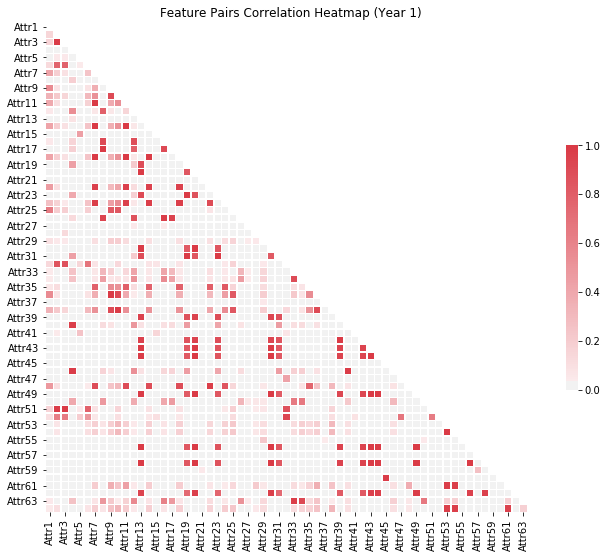

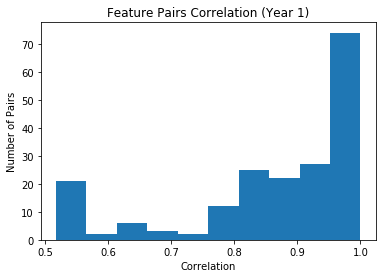

Attr21 Attr24  Attr27 Attr28  Attr37 Attr41 Attr45 Attr53 Attr54  \
solvent     43.0      2     6.0      2    77.0      2      5      2      2   
bankrupt     2.0      -     2.0      -     3.0      -      -      -      -   
total       45.0      2     7.0      2    80.0      2      6      2      2   

         Attr60 Attr64  
solvent       5      2  
bankrupt      -      -  
total         6      2

Attr1 Attr4 Attr7 Attr14 Attr15 Attr16 Attr18 Attr20 Attr21 Attr22  \
class                                                                      
0         -     -     -      -      -      -      -      -      -      -   
1         1     1     1      1      3      1      1      4      3      2   

       ...   Attr43  Attr44 Attr45 Attr46 Attr49 Attr50 Attr55 Attr56 Attr57  \
class  ...                                                                     
0      ...        -       -      -      -      -      -    1.0      -      -   
1      ...        3       2      1      2      5      1    2.0      3      1   

      Attr61  
class         
0          -  
1          2  

[2 rows x 25 columns]

Feature pairs above 0.999 correlation
Attr7   Attr14    1.000000
Attr8   Attr17    0.999998
Attr32  Attr52    0.999998
Attr19  Attr31    0.999998
Attr9   Attr36    0.999960
Attr13  Attr19    0.999939
Attr23  Attr31    0.999855
Attr19  Attr23    0.999855
Attr47  Attr52    0.999524
Attr32  Attr47    0.999505
Attr33  Attr63    0.999343
Attr3   Attr51    0.999303
Attr10  Attr38    0.999290
dtype: float64


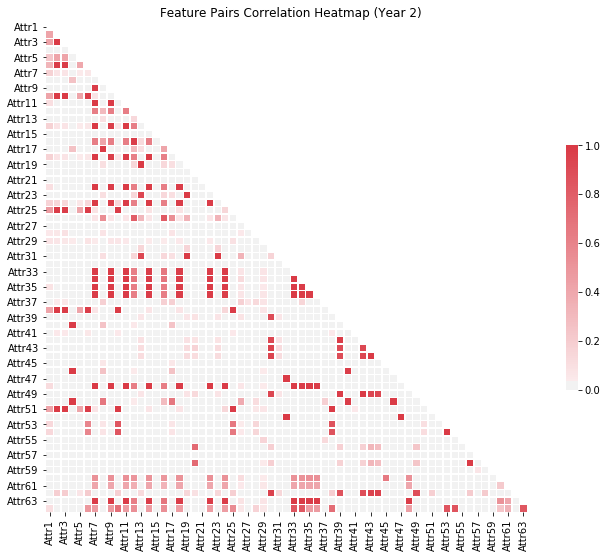

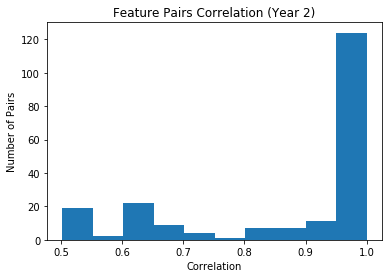

Attr21 Attr24  Attr27 Attr28  Attr37 Attr41 Attr45 Attr53 Attr54  \
solvent      7.0      2     6.0      2    78.0      2      6      2      2   
bankrupt     1.0      -     2.0      -     4.0      -      -      -      -   
total        8.0      2     7.0      2    82.0      2      6      2      2   

         Attr60 Attr64  
solvent       6      2  
bankrupt      -      -  
total         6      2

Attr5 Attr9 Attr20 Attr21 Attr22  Attr29 Attr34 Attr35  Attr36 Attr37  \
class                                                                         
0         -     -      -      -      -     5.0      -      -     1.0      -   
1         3     3      3      2      1     6.0      2      4     1.0      1   

        ...   Attr52 Attr53 Attr54 Attr55  Attr56 Attr57 Attr58 Attr60 Attr61  \
class   ...                                                                     
0       ...        -      -      -    1.0       -      -      -      -      -   
1       ...        1      1      1    2.0       1      1      1      1      4   

       Attr64  
class          
0           -  
1           1  

[2 rows x 26 columns]

Feature pairs above 0.999 correlation
Attr7   Attr14    0.999999
Attr4   Attr46    0.999933
Attr2   Attr10    0.999671
Attr38  Attr51    0.999200
Attr8   Attr17    0.999169
Attr10  Attr38    0.999098
dtype: float64


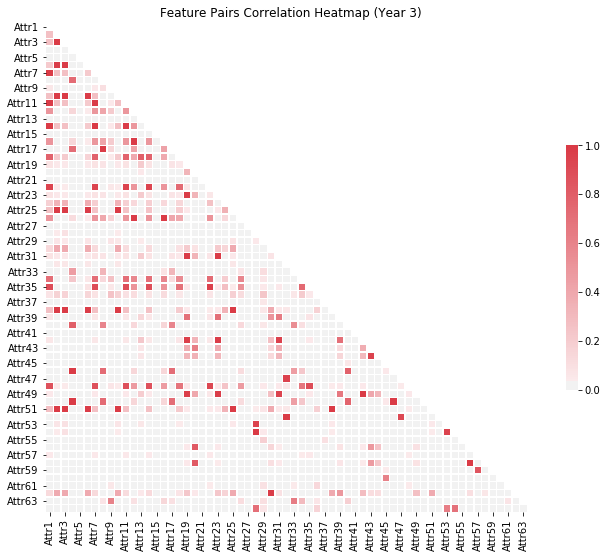

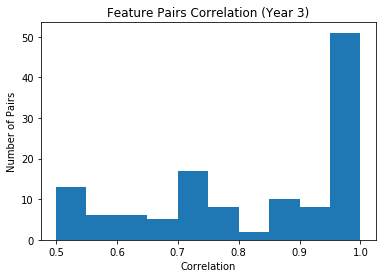

Attr21 Attr24  Attr27 Attr28  Attr37 Attr41 Attr45 Attr53 Attr54  \
solvent       -      2     5.0      2    78.0      2      6      2      2   
bankrupt      1      -     2.0      -     5.0      -      -      -      -   
total         2      2     7.0      2    83.0      2      7      2      2   

         Attr60 Attr64  
solvent       6      2  
bankrupt      -      -  
total         7      2

Attr1 Attr3 Attr4 Attr5 Attr7 Attr11 Attr14 Attr15 Attr18 Attr22  \
class                                                                     
0        1.0     -     -     -     -      -      -      -      -      -   
1        2.0     2     2     3     2      2      2      1      2      2   

       ...   Attr50 Attr51  Attr52 Attr53 Attr54 Attr55 Attr57 Attr60 Attr61  \
class  ...                                                                     
0      ...        -      -       -      -      -    1.0      -      -      -   
1      ...        1      2       2      2      2    2.0      2      1      1   

      Attr63  
class         
0          -  
1          2  

[2 rows x 32 columns]

Feature pairs above 0.999 correlation
Attr8   Attr17    0.999999
Attr7   Attr14    0.999997
Attr4   Attr46    0.999948
Attr43  Attr44    0.999934
Attr39  Attr56    0.999295
Attr2   Attr10    0.999293
dtype: float64


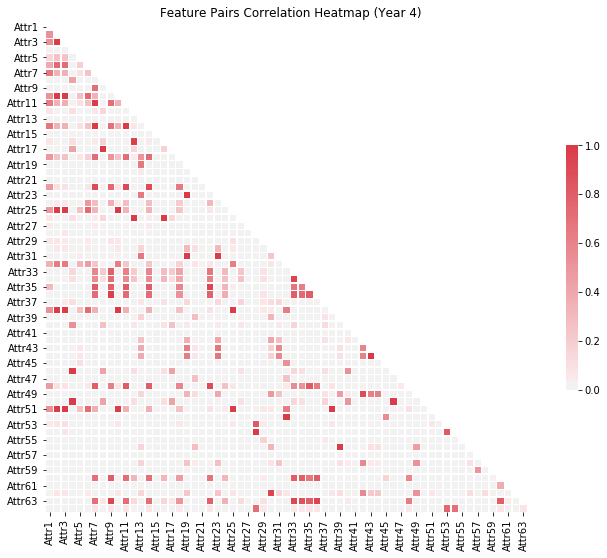

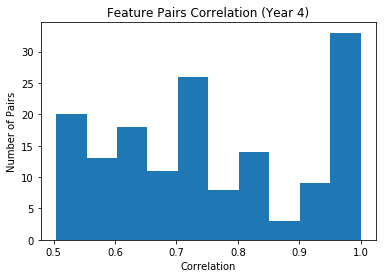

Attr21 Attr24  Attr27 Attr28  Attr37 Attr41 Attr45 Attr53 Attr54  \
solvent       -      2     5.0      2    70.0      1      4      2      2   
bankrupt      2      -     2.0      -     6.0      -      -      -      -   
total         2      2     7.0      2    76.0      1      5      2      2   

         Attr60 Attr64  
solvent       4      2  
bankrupt      -      -  
total         5      2

Attr9 Attr20 Attr21 Attr27 Attr28  Attr29 Attr31 Attr33 Attr37 Attr39  \
class                                                                          
0        2.0      1      -      -      -     6.0      -      -      -      -   
1        5.0      -      5      1      1     5.0      1      1      2      2   

       ...   Attr43 Attr44 Attr45 Attr48 Attr49 Attr51 Attr55  Attr56 Attr58  \
class  ...                                                                     
0      ...        -      -      -      1      -      1    1.0       -      -   
1      ...        1      1      2      -      1      -    2.0       1      2   

      Attr59  
class         
0          -  
1          1  

[2 rows x 21 columns]

Feature pairs above 0.999 correlation
Attr7   Attr14    1.000000
Attr8   Attr17    0.999978
Attr16  Attr26    0.999948
Attr45  Attr60    0.999896
Attr4   Attr46    0.999713
Attr19  Attr23    0.999684
Attr22  Attr35    0.999354
        Attr48    0.999149
dtype: float64


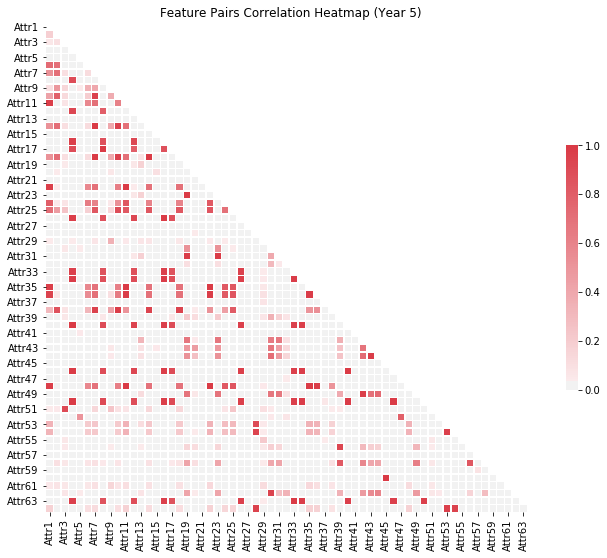

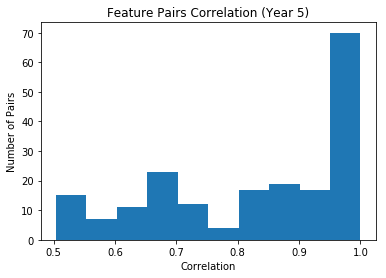

1      2      3     4     5
# samples       7027  10173  10503  9792  5910
% bankrupt         4      4      5     5     7
% correlated      10     10      6     8    10
% missing          1      2      1     1     1
% outliers         1      1      1     1     1
% solvent         96     96     95    95    93
% uncorrelated    90     90     94    92    90

In [11]:
data_summary = {}
for year, df in data_raw.items():
    display(HTML('<h3>Year {}</h3>'.format(year)))

    n_samples = df.shape[0]
    solvent_pct = df[df['class'] == 0].shape[0] / n_samples
    bankrupt_pct = df[df['class'] == 1].shape[0] / n_samples

    # Find percentage of missing values for each feature
    df_miss_pct = df.isna().sum().sum() / df.size
    
    # - Calculate total missing
    df_missing_agg = df.isna().sum() / df.count()
    df_missing_by_total = pd.DataFrame(df_missing_agg[df_missing_agg > 0.01] * 100, columns=['total']).round(0).T

    # - Calculate missing by class
    df_missing = df.groupby('class').apply(lambda df_class: df_class.isna().sum() / df.count())
    df_missing_by_class = pd.DataFrame(df_missing[df_missing > 0.01].dropna(axis=1, how='all') * 100).round(0).fillna('-')
    df_missing_by_class.index = ['solvent', 'bankrupt']

    # - Combine total and paritioned results
    display(HTML('<h4>missing attributes (%)</h4>'))
    display(pd.concat([df_missing_by_class, df_missing_by_total]))

    # Find percentage of values over 2 standard deviations for each feature
    find_outliers = lambda df_: df_[(np.abs(df_-df_.mean()) > (2*df_.std()))].count() / df_.count()    
    df_outliers = df.groupby('class').apply(find_outliers)

    display(HTML('<h4>attributes with outliers (%)</h4>'))
    display(pd.DataFrame(df_outliers[df_outliers > 0.01].dropna(axis=1, how='all') * 100).round(0).fillna('-'))

    # Labels are irrelevant for aggregate analysis, remove them
    df = df.drop('class', axis=1)

    # Plot correlation heatmap
    plot_corr_heatmap(df.corr().abs(), 'Feature Pairs Correlation Heatmap (Year {})'.format(year))
    
    # Find percentage of values over 1 standard deviation for each year
    df_outliers_pct = df[(np.abs(df-df.mean()) > df.std())].count().sum() / df.size

    # Find highly correlated feature pairs
    corr = df.corr().abs()
    corr.loc[:,:] = np.tril(corr.values, k=-1)
    corr = corr.unstack().dropna()

    n_triu = len(np.triu_indices(df.shape[1])[0])
    n_tril = len(np.tril_indices(df.shape[1],-1)[0])
    n_corr_pct = len(corr[corr >= 0.5]) / n_tril
    n_uncorr_pct = (len(corr[corr < 0.5]) - n_triu) / n_tril

    data_summary[year] = {
        '# samples'       : n_samples,
        '% outliers'      : np.int(np.round(df_outliers_pct * 100, 0)),
        '% missing'       : np.int(np.round(df_miss_pct * 100, 0)),
        '% solvent'       : np.int(np.round(solvent_pct * 100, 0)),
        '% bankrupt'      : np.int(np.round(bankrupt_pct * 100, 0)),
        '% correlated'    : np.int(np.round(n_corr_pct * 100, 0)),
        '% uncorrelated'  : np.int(np.round(n_uncorr_pct * 100, 0)),
    }
    
    print('Feature pairs above 0.999 correlation')
    print(corr[corr>0.999].sort_values(ascending=False))

    plt.figure()
    plt.hist(corr[corr>=0.5],10)
    plt.title('Feature Pairs Correlation (Year {})'.format(year))
    plt.xlabel('Correlation')
    plt.ylabel('Number of Pairs')
    plt.show()

display(HTML('<h3>Summary</h3>'))
display(pd.DataFrame(data_summary))

### Data Cleaning

In [12]:
# Compute missing values statistics
stats_missing = pd.DataFrame(df.isna().sum() / df.count() for _, df in data_raw.items()).round(2)
# Find features with over 10% missing values in all years
over_missrate = stats_missing.loc[:, (stats_missing > 0.1).all(axis=0)]
over_missrate.index += 1
over_missrate.index.name = 'year'
over_missrate

Attr37
year        
1       0.64
2       0.80
3       0.82
4       0.83
5       0.76

In [13]:
feature_transformer = FeatureTransformer(data_raw, over_missrate.columns)

In [14]:
# Find remaining number of features after cleaning
n_features = next(iter(data_raw.values())).shape[1] - 1
n_features

64

## Model Selection

In [15]:
# Fixed parameters, change these to fine-tune training speed vs performance trade-off
fixed_params = {
    'n_splits': 10, # 2 / 10
    'max_iter': 50000, # 10 / 50000
    'n_estimators': np.arange(9,12), # [1] / np.arange(9,12)
}

In [16]:
# Dictionary of experiments to execute when evaluating different model combinations
model_search = {
    'Logistic Regression' : {
        #####################################################
        # Baseline model against which to compare performance
        'Baseline': {
            'data': feature_transformer.mean_by_class,
            'pipe': [
                ('scale', QuantileTransformer()),
                ('estimator', SGDClassifier(loss='log', penalty='none', max_iter=fixed_params['max_iter'], shuffle=True, random_state=0, eta0=0.1, learning_rate='constant', class_weight='balanced')),
            ],
            'params': {
                'estimator__tol': 10.0 ** -np.arange(3,8),
                'estimator__eta0': 10.0 ** -np.arange(1,6)
            }
        },
        ##################################
        # Models to handle class imbalance
        'SMOTE': {
            'data': feature_transformer.mean_by_class,
            'pipe': [
                ('scale', QuantileTransformer()),
                ('resample', SMOTE(random_state=0)),
                ('estimator', SGDClassifier(loss='log', penalty='none', max_iter=fixed_params['max_iter'], shuffle=True, random_state=0, eta0=0.1, learning_rate='constant')),
            ],
            'params': {
                'estimator__tol': 10.0 ** -np.arange(3,8),
                'estimator__eta0': 10.0 ** -np.arange(1,6),
            }                    
        },
        'Undersample': {
            'data': feature_transformer.mean_by_class,
            'pipe': [
                ('scale', QuantileTransformer()),
                ('resample', RandomUnderSampler(random_state=0)),
                ('estimator', SGDClassifier(loss='log', penalty='none', max_iter=fixed_params['max_iter'], shuffle=True, random_state=0, eta0=0.1, learning_rate='constant')),
            ],
            'params': {
                'estimator__tol': 10.0 ** -np.arange(3,8),
                'estimator__eta0': 10.0 ** -np.arange(1,6),
            }                    
        },
        ########################################
        # Models to scale / normalise input data
        'Min-Max Scaler': {
            'data': feature_transformer.mean_by_class,
            'pipe': [
                ('scale', MinMaxScaler()),
                ('estimator', SGDClassifier(loss='log', penalty='none', max_iter=fixed_params['max_iter'], shuffle=True, random_state=0, eta0=0.1, learning_rate='constant', class_weight='balanced')),
            ],
            'params': {
                'estimator__tol': 10.0 ** -np.arange(3,8),
                'estimator__eta0': 10.0 ** -np.arange(1,6),
            }                    
        },
        'Normaliser': {
            'data': feature_transformer.mean_by_class,
            'pipe': [
                ('scale', Normalizer()),
                ('estimator', SGDClassifier(loss='log', penalty='none', max_iter=fixed_params['max_iter'], shuffle=True, random_state=0, eta0=0.1, learning_rate='constant', class_weight='balanced')),
            ],
            'params': {
                'estimator__tol': 10.0 ** -np.arange(3,8),
                'estimator__eta0': 10.0 ** -np.arange(1,6),
            }                    
        },                
        'Standard Scaler': {
            'data': feature_transformer.mean_by_class,
            'pipe': [
                ('scale', StandardScaler()),
                ('estimator', SGDClassifier(loss='log', penalty='none', max_iter=fixed_params['max_iter'], shuffle=True, random_state=0, eta0=0.1, learning_rate='constant', class_weight='balanced')),
            ],
            'params': {
                'estimator__tol': 10.0 ** -np.arange(3,8),
                'estimator__eta0': 10.0 ** -np.arange(1,6)
            }
        },
        #########################################################
        # Models which do feature selection / dimension reduction
        'PCA': {
            'data': feature_transformer.mean_by_class,
            'pipe': [
                ('scale', QuantileTransformer()),
                ('pca', PCA(random_state=0)),
                ('estimator', SGDClassifier(loss='log', penalty='none', max_iter=fixed_params['max_iter'], shuffle=True, random_state=0, eta0=0.1, learning_rate='constant', class_weight='balanced')),
            ],
            'params': {
                'pca__n_components': np.arange(4, n_features + 1),
                'estimator__tol': 10.0 ** -np.arange(3,8),
                'estimator__eta0': 10.0 ** -np.arange(1,6)
            }
        },
        'L2 Regularisation': {
            'data': feature_transformer.mean_by_class,
            'pipe': [
                ('scale', QuantileTransformer()),
                ('estimator', SGDClassifier(loss='log', penalty='l2', max_iter=fixed_params['max_iter'], shuffle=True, random_state=0, eta0=0.1, learning_rate='constant', class_weight='balanced')),
            ],
            'params': {
                'estimator__tol': 10.0 ** -np.arange(3,8),
                'estimator__eta0': 10.0 ** -np.arange(1,6)
            }
        },
        'kBest Features': {
            'data': feature_transformer.mean_by_class,
            'pipe': [
                ('select', SelectKBest(score_func=f_classif)),
                ('scale', QuantileTransformer()),
                ('estimator', SGDClassifier(loss='log', penalty='none', max_iter=fixed_params['max_iter'], shuffle=True, random_state=0, eta0=0.1, learning_rate='constant', class_weight='balanced')),
            ],
            'params': {
                'select__k': np.arange(4, n_features + 1),
                'estimator__tol': 10.0 ** -np.arange(3,8),
                'estimator__eta0': 10.0 ** -np.arange(1,6)
            }                    
        },
        #################################
        # Models to impute missing values
        'Mean Imputation': {
            'data': feature_transformer.mean,
            'pipe': [
                ('scale', QuantileTransformer()),
                ('estimator', SGDClassifier(loss='log', penalty='none', max_iter=fixed_params['max_iter'], shuffle=True, random_state=0, eta0=0.1, learning_rate='constant', class_weight='balanced')),
            ],
            'params': {
                'estimator__tol': 10.0 ** -np.arange(3,8),
                'estimator__eta0': 10.0 ** -np.arange(1,6)
            }
        },
        'Median Imputation': {
            'data': feature_transformer.median,
            'pipe': [
                ('scale', QuantileTransformer()),
                ('estimator', SGDClassifier(loss='log', penalty='none', max_iter=fixed_params['max_iter'], shuffle=True, random_state=0, eta0=0.1, learning_rate='constant', class_weight='balanced')),
            ],
            'params': {
                'estimator__tol': 10.0 ** -np.arange(3,8),
                'estimator__eta0': 10.0 ** -np.arange(1,6)
            }
        },
        'Median by Class Imputation': {
            'data': feature_transformer.median_by_class,
            'pipe': [
                ('scale', QuantileTransformer()),
                ('estimator', SGDClassifier(loss='log', penalty='none', max_iter=fixed_params['max_iter'], shuffle=True, random_state=0, eta0=0.1, learning_rate='constant', class_weight='balanced')),
            ],
            'params': {
                'estimator__tol': 10.0 ** -np.arange(3,8),
                'estimator__eta0': 10.0 ** -np.arange(1,6)
            }
        },        
    },
    
    'Decision Tree' : {
        #####################################################
        # Baseline model against which to compare performance
        'Baseline': {
            'data': feature_transformer.mean_by_class,
            'pipe': [
                ('estimator', BaggingClassifier(DecisionTreeClassifier(criterion='entropy', random_state=0), random_state=0)),
            ],
            'params': {
                'estimator__n_estimators': fixed_params['n_estimators'],
                'estimator__max_features': 0.1 * np.arange(7,11),
                'estimator__max_samples': 0.1 * np.arange(7,11),
            }
        },
        ##################################
        # Models to handle class imbalance
        'SMOTE': {
            'data': feature_transformer.mean_by_class,
            'pipe': [
                ('resample', SMOTE(random_state=0)),
                ('estimator', BaggingClassifier(DecisionTreeClassifier(criterion='entropy', random_state=0), random_state=0)),
            ],
            'params': {
                'estimator__n_estimators': fixed_params['n_estimators'],
                'estimator__max_features': 0.1 * np.arange(7,11),
                'estimator__max_samples': 0.1 * np.arange(7,11),
            }                    
        },
        'Undersample': {
            'data': feature_transformer.mean_by_class,
            'pipe': [
                ('scale', QuantileTransformer()),
                ('resample', RandomUnderSampler(random_state=0)),
                ('estimator', BaggingClassifier(DecisionTreeClassifier(criterion='entropy', random_state=0), random_state=0)),
            ],
            'params': {
                'estimator__n_estimators': fixed_params['n_estimators'],
                'estimator__max_features': 0.1 * np.arange(7,11),
                'estimator__max_samples': 0.1 * np.arange(7,11),
            }                    
        },
        #########################################################
        # Models which do feature selection / dimension reduction
        'PCA': {
            'data': feature_transformer.mean_by_class,
            'pipe': [
                ('pca', PCA(random_state=0)),
                ('estimator', BaggingClassifier(DecisionTreeClassifier(criterion='entropy', random_state=0), random_state=0)),
            ],
            'params': {
                'pca__n_components': np.arange(4, n_features + 1),
                'estimator__n_estimators': fixed_params['n_estimators'],
                'estimator__max_features': 0.1 * np.arange(7,11),
                'estimator__max_samples': 0.1 * np.arange(7,11),
            }
        },
        'kBest Features': {
            'data': feature_transformer.mean_by_class,
            'pipe': [
                ('select', SelectKBest(score_func=f_classif)),
                ('estimator', BaggingClassifier(DecisionTreeClassifier(criterion='entropy', random_state=0), random_state=0)),
            ],
            'params': {
                'select__k': np.arange(4, n_features + 1),
                'estimator__n_estimators': fixed_params['n_estimators'],
                'estimator__max_features': 0.1 * np.arange(7,11),
                'estimator__max_samples': 0.1 * np.arange(7,11),
            }                    
        },
        #################################
        # Models to impute missing values
        'Mean Imputation': {
            'data': feature_transformer.mean,
            'pipe': [
                ('estimator', BaggingClassifier(DecisionTreeClassifier(criterion='entropy', random_state=0), random_state=0)),
            ],
            'params': {
                'estimator__n_estimators': fixed_params['n_estimators'],
                'estimator__max_features': 0.1 * np.arange(7,11),
                'estimator__max_samples': 0.1 * np.arange(7,11),
            }
        },
        'Median Imputation': {
            'data': feature_transformer.median,
            'pipe': [
                ('estimator', BaggingClassifier(DecisionTreeClassifier(criterion='entropy', random_state=0), random_state=0)),
            ],
            'params': {
                'estimator__n_estimators': fixed_params['n_estimators'],
                'estimator__max_features': 0.1 * np.arange(7,11),
                'estimator__max_samples': 0.1 * np.arange(7,11),
            }
        },
        'Median by Class Imputation': {
            'data': feature_transformer.median_by_class,
            'pipe': [
                ('estimator', BaggingClassifier(DecisionTreeClassifier(criterion='entropy', random_state=0), random_state=0)),
            ],
            'params': {
                'estimator__n_estimators': fixed_params['n_estimators'],
                'estimator__max_features': 0.1 * np.arange(7,11),
                'estimator__max_samples': 0.1 * np.arange(7,11),
            }
        },        
    },
}

In [17]:
# Execute all the experiments and produce metrics to evaluate performance
best_params = {}
results_experiments = {}

for model, experiments in model_search.items():
    for experiment, setup in experiments.items():
        for year, df in setup['data']().items():
            # Features
            X = df.iloc[:,:-1]
            # Labels
            y = df.iloc[:,-1]

            # Split the data into a training and testing set to train the model and evaluate performance
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

            # Search for the optimal parameters using a sample of the parameter space
            # (Replace with GridSearchCV to attempt all possible combinations)
            clf = RandomizedSearchCV(Pipeline(steps=setup['pipe']),
                                     param_distributions=setup['params'],
                                     scoring='roc_auc',
                                     refit=True,
                                     n_jobs=-1,
                                     cv=StratifiedKFold(n_splits=fixed_params['n_splits'], random_state=0),
                                     verbose=False,
                                     random_state=0,
                                     return_train_score=False)

            # Train the model
            clf.fit(X_train, y_train)
            # Predict labels
            y_hat = clf.predict(X_test)
            # Probabilities of belonging to solvent/bankrupt classes
            y_score = clf.predict_proba(X_test)
            
            # Add clf.best_params_ to the best_params dictionary.
            # First check if the best_params dictionary needs to be initialised
            if model not in best_params:
                best_params[model] = {}

            if experiment not in best_params[model]:
                best_params[model][experiment] = {}

            best_params[model][experiment][year] = clf.best_params_

            # Add results to the results_experiments dictionary
            # First check if the results_experiments dictionary needs to be initialised
            if model not in results_experiments:
                results_experiments[model] = {}
            
            if experiment not in results_experiments[model]:
                results_experiments[model][experiment] = [[]]*len(data_raw)

            year_idx = np.int(year)-1
            results_experiments[model][experiment][year_idx] = {
                'y': y_test,
                'y_hat': y_hat,
                'y_score': y_score[:,1],
            }


C:\Users\ab.ACX\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [18]:
# Find the optimal parameters of the baseline models for each year
for model, experiments in best_params.items():

    df_best_params = pd.DataFrame([ best_params_ for year, best_params_ in experiments['Baseline'].items() ])
    df_best_params.index += 1
    df_best_params.index.name = 'year'

    print(model)
    display(df_best_params)

Logistic Regression


estimator__eta0  estimator__tol
year                                 
1               0.010          0.0010
2               0.001          0.0001
3               0.010          0.0010
4               0.010          0.0010
5               0.010          0.0010

Decision Tree


estimator__max_features  estimator__max_samples  estimator__n_estimators
year                                                                          
1                         0.9                     0.9                       11
2                         0.9                     0.7                       11
3                         1.0                     0.8                       10
4                         0.9                     0.9                       11
5                         0.9                     0.9                       11

## Custom Models Evaluation

Refer to `CustomClassifiers.py` for the models implementation code.

In [19]:
# Compare the performance of the custom and sklearn implementations
results_custom_vs_sklearn = {}
for year, df in feature_transformer.mean_by_class().items():

    LR = {
        'max_iter': fixed_params['max_iter'],
        'tol'     : best_params['Logistic Regression']['Baseline'][year]['estimator__tol'],
        'eta0'    : best_params['Logistic Regression']['Baseline'][year]['estimator__eta0']
    }
    
    DT = {
        'n_estimators': best_params['Decision Tree']['Baseline'][year]['estimator__n_estimators'],
        'max_features': best_params['Decision Tree']['Baseline'][year]['estimator__max_features'],
        'max_samples': best_params['Decision Tree']['Baseline'][year]['estimator__max_samples'],
    }

    models = {
        # Classifier
        'Logistic Regression' : {
            # Experiments
            'sklearn' : [
                QuantileTransformer(),
                SGDClassifier(loss='log', penalty='none', max_iter=LR['max_iter'], tol=LR['tol'], shuffle=True, random_state=0, eta0=LR['eta0'], learning_rate='constant', class_weight='balanced'),
            ],
            'custom' : [
               QuantileTransformer(),
               CustomLogitRegression(max_epochs=LR['max_iter'], alpha=LR['eta0'], min_gain=LR['tol'])
            ],
        },
        'Decision Tree' : {
            'sklearn' : [
                BaggingClassifier(DecisionTreeClassifier(criterion='entropy', random_state=0), n_estimators=DT['n_estimators'], max_features=DT['max_features'], max_samples=DT['max_samples'], random_state=0)
            ],
            'custom' : [
                CustomBagging(base_estimator=CustomDecisionTree(),n_estimators=DT['n_estimators'], base_n_features=DT['max_features'], base_n_samples=DT['max_samples'])
            ],
        }        
    }

    # Features
    X = df.iloc[:,:-1]
    # Labels
    y = df.iloc[:,-1]

    # Split the data into a training and testing set to train the model and evaluate performance
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

    for model, experiments in models.items():
        for experiment, pipeline in experiments.items():
            scores = cross_validate(estimator=make_pipeline(*pipeline),
                                    X=X_train, y=y_train,
                                    scoring='roc_auc',
                                    cv=StratifiedKFold(n_splits=fixed_params['n_splits'], random_state=0),
                                    n_jobs=-1,
                                    verbose=0,
                                    return_train_score=False,
                                    return_estimator=True)

            # Pick up the best estimator
            clf = scores['estimator'][np.argmax(scores['test_score'])]

            # Train the model
            clf.fit(X_train, y_train)
            # Predict labels
            y_hat = clf.predict(X_test)
            # Probabilities of belonging to solvent/bankrupt classes
            y_score = clf.predict_proba(X_test)

            # Add results to the results_custom_vs_sklearn dictionary
            # First check if the results_custom_vs_sklearn dictionary needs to be initialised
            if model not in results_custom_vs_sklearn:
                results_custom_vs_sklearn[model] = {}
            
            if experiment not in results_custom_vs_sklearn[model]:
                results_custom_vs_sklearn[model][experiment] = [[]]*len(data_raw)

            year_idx = np.int(year)-1
            results_custom_vs_sklearn[model][experiment][year_idx] = {
                'y': y_test,
                'y_hat': y_hat,
                'y_score': y_score[:,1],
            }

## Results

### Experiments Models

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Logistic Regression | Baseline)
ACC: 0.9075391180654339
Sensitivity: 0.8518518518518519
Specificity: 0.9097633136094675
F1-Score: 0.4144144144144144
AUC: 0.9424172693403463


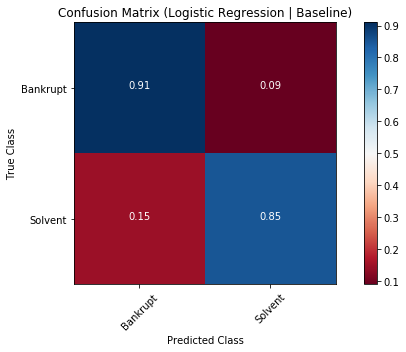

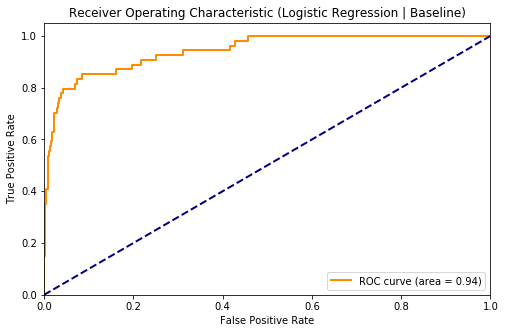

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Logistic Regression | Baseline)
ACC: 0.830958230958231
Sensitivity: 0.5875
Specificity: 0.8409207161125319
F1-Score: 0.2146118721461187
AUC: 0.7863299232736574


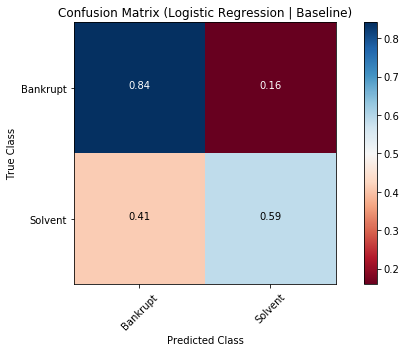

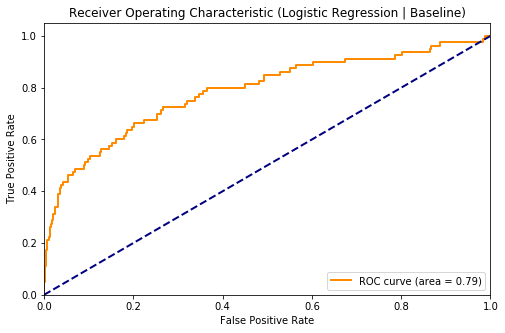

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Logistic Regression | Baseline)
ACC: 0.8648262732032366
Sensitivity: 0.6868686868686869
Specificity: 0.8736263736263736
F1-Score: 0.32380952380952377
AUC: 0.8780815144451508


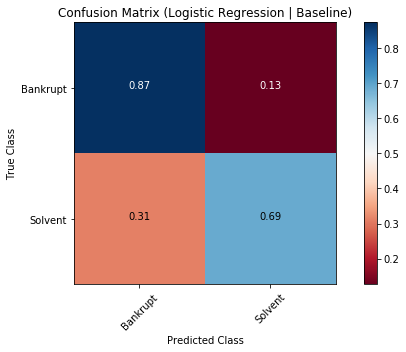

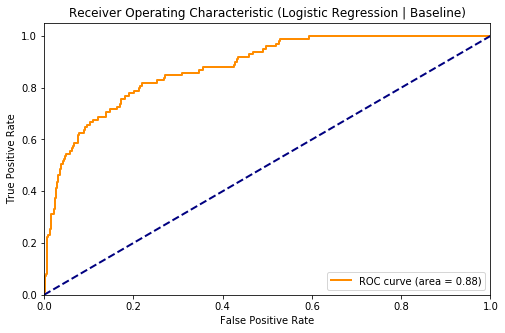

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Logistic Regression | Baseline)
ACC: 0.8683001531393568
Sensitivity: 0.6796116504854369
Specificity: 0.8787715517241379
F1-Score: 0.35175879396984927
AUC: 0.8622782055574154


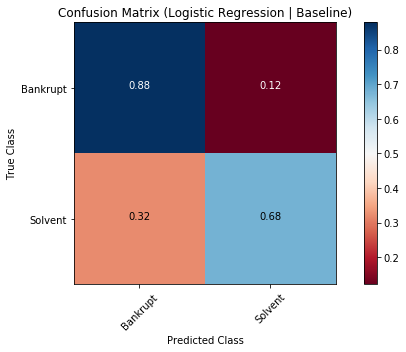

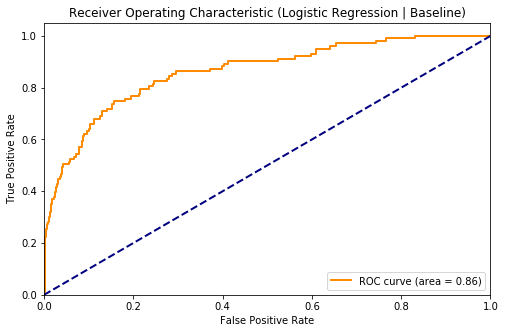

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Logistic Regression | Baseline)
ACC: 0.8485617597292724
Sensitivity: 0.8780487804878049
Specificity: 0.8463636363636363
F1-Score: 0.4458204334365325
AUC: 0.9168736141906872


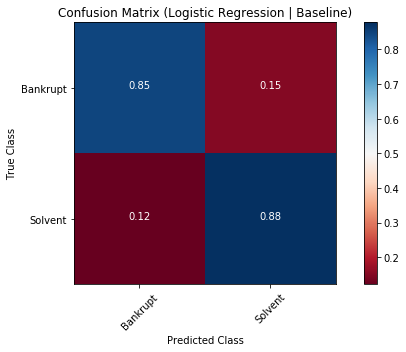

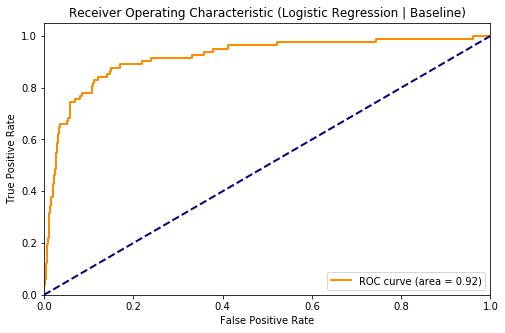

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Logistic Regression | Baseline)
ACC: 0.8623747552689163
Sensitivity: 0.7248803827751196
Specificity: 0.8693284936479129
F1-Score: 0.3364797334813992
AUC: 0.8749201828196957


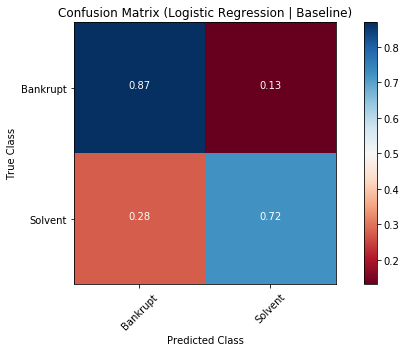

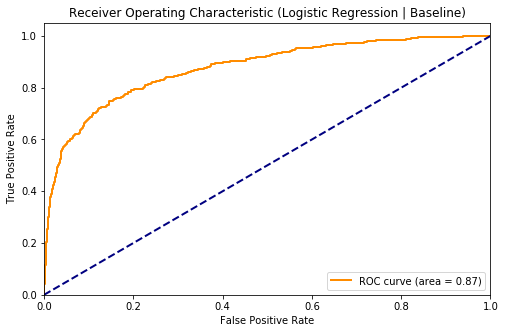

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Logistic Regression | SMOTE)
ACC: 0.8961593172119487
Sensitivity: 0.8518518518518519
Specificity: 0.8979289940828402
F1-Score: 0.3865546218487395
AUC: 0.9429377602454525


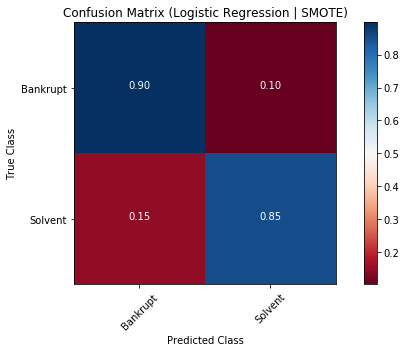

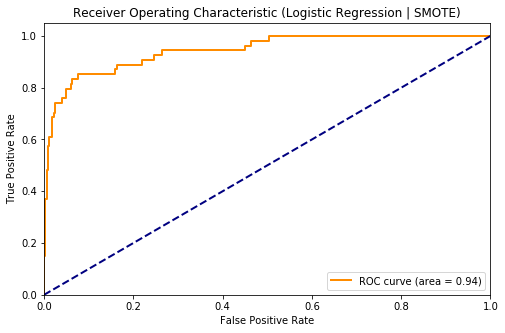

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Logistic Regression | SMOTE)
ACC: 0.8624078624078624
Sensitivity: 0.6125
Specificity: 0.8726342710997442
F1-Score: 0.25925925925925924
AUC: 0.7952046035805627


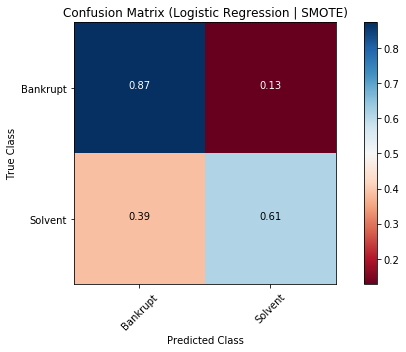

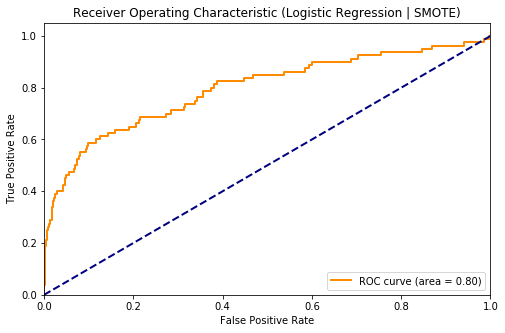

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Logistic Regression | SMOTE)
ACC: 0.8024750118990956
Sensitivity: 0.797979797979798
Specificity: 0.8026973026973027
F1-Score: 0.27574171029668415
AUC: 0.8904075722257542


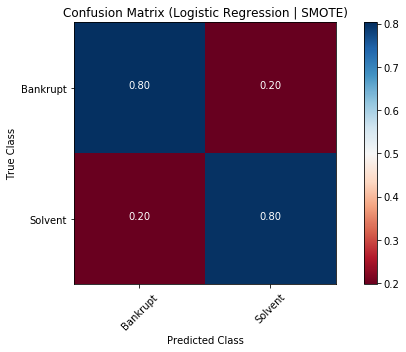

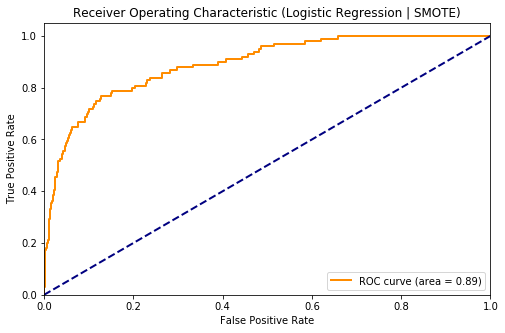

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Logistic Regression | SMOTE)
ACC: 0.809086268504339
Sensitivity: 0.7864077669902912
Specificity: 0.8103448275862069
F1-Score: 0.30223880597014924
AUC: 0.8644752259792435


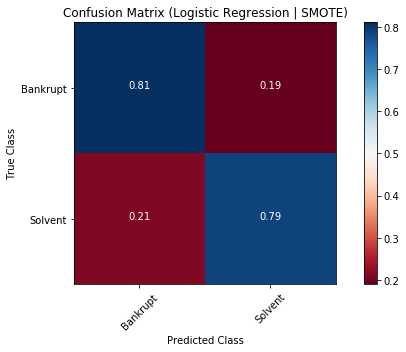

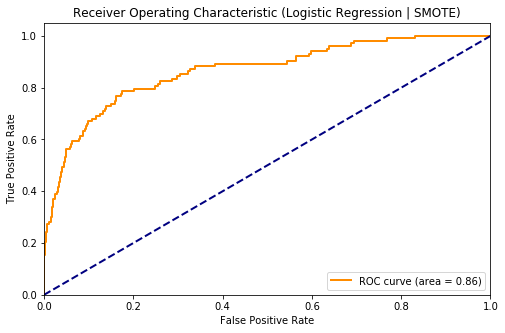

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Logistic Regression | SMOTE)
ACC: 0.8671742808798646
Sensitivity: 0.8414634146341463
Specificity: 0.8690909090909091
F1-Score: 0.4677966101694916
AUC: 0.9083481152993348


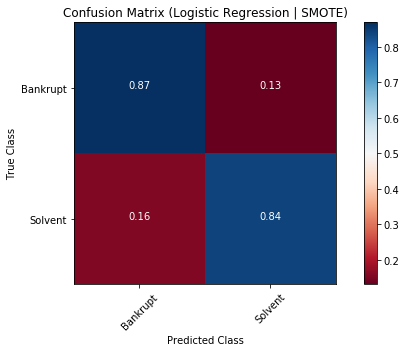

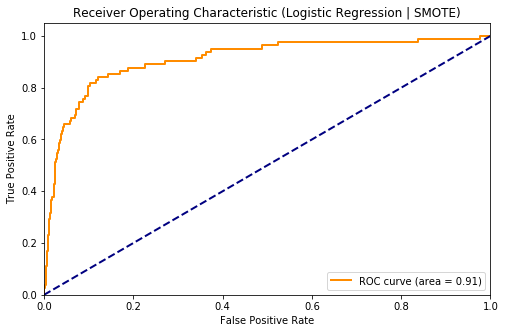

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Logistic Regression | SMOTE)
ACC: 0.8419900955890821
Sensitivity: 0.7751196172248804
Specificity: 0.8453720508166969
F1-Score: 0.32079207920792074
AUC: 0.8787175412545554


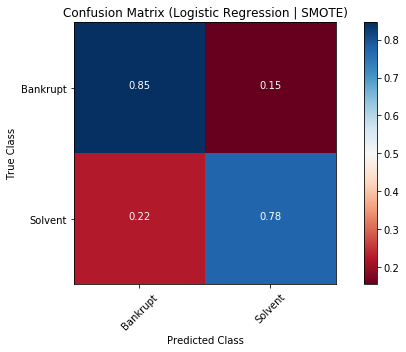

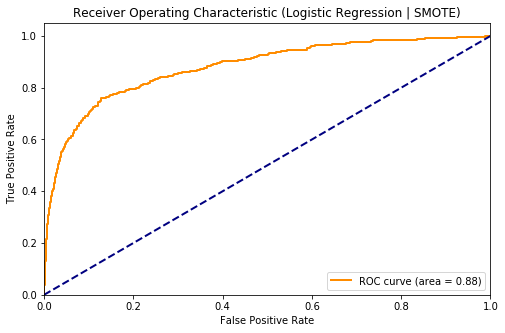

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Logistic Regression | Undersample)
ACC: 0.9324324324324325
Sensitivity: 0.7962962962962963
Specificity: 0.9378698224852071
F1-Score: 0.4751381215469613
AUC: 0.9336100153407846


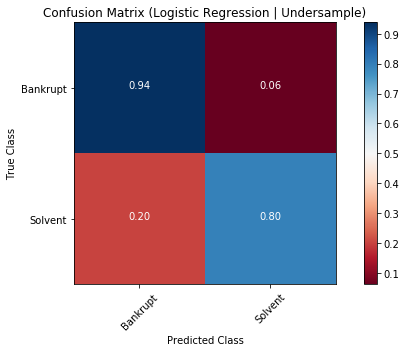

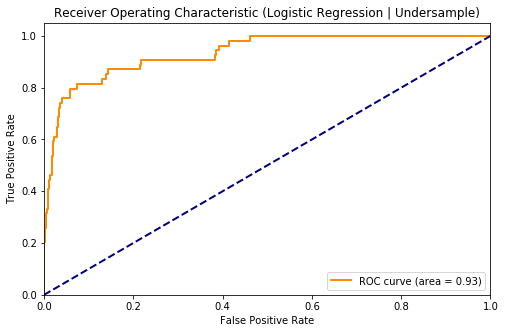

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Logistic Regression | Undersample)
ACC: 0.7896805896805896
Sensitivity: 0.625
Specificity: 0.7964194373401534
F1-Score: 0.1893939393939394
AUC: 0.7757289002557545


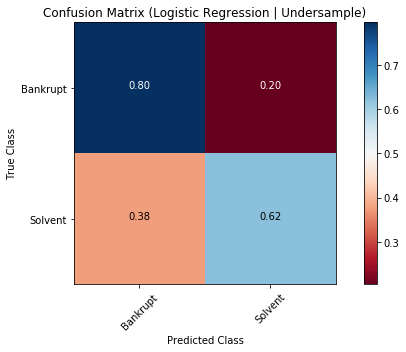

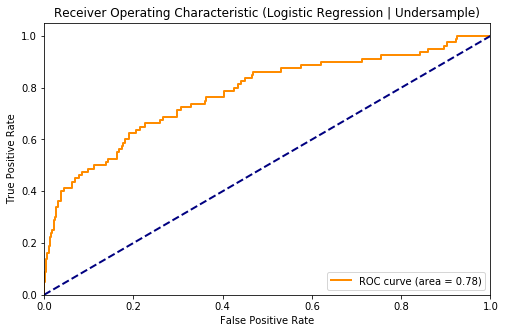

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Logistic Regression | Undersample)
ACC: 0.803426939552594
Sensitivity: 0.7777777777777778
Specificity: 0.8046953046953047
F1-Score: 0.271604938271605
AUC: 0.8717898263352809


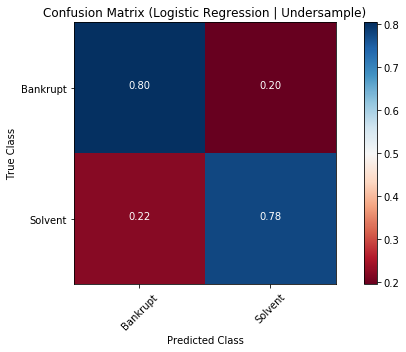

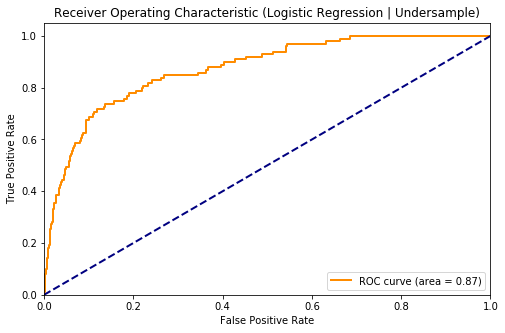

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Logistic Regression | Undersample)
ACC: 0.7728432873915263
Sensitivity: 0.7669902912621359
Specificity: 0.7731681034482759
F1-Score: 0.2620232172470978
AUC: 0.855708068295949


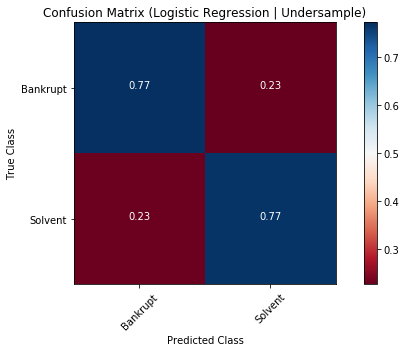

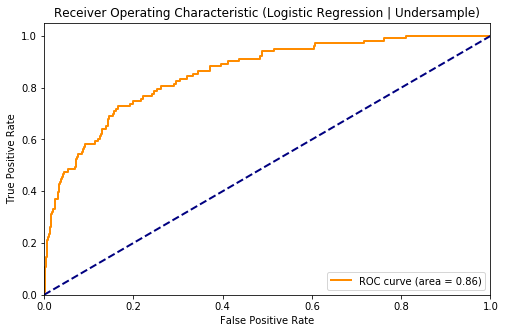

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Logistic Regression | Undersample)
ACC: 0.8654822335025381
Sensitivity: 0.8292682926829268
Specificity: 0.8681818181818182
F1-Score: 0.4610169491525424
AUC: 0.9086807095343682


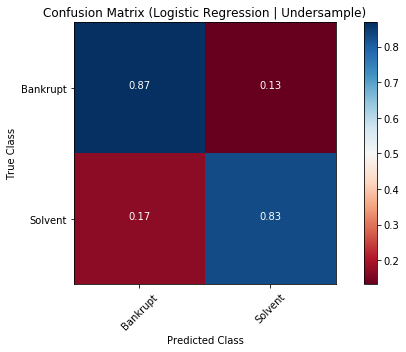

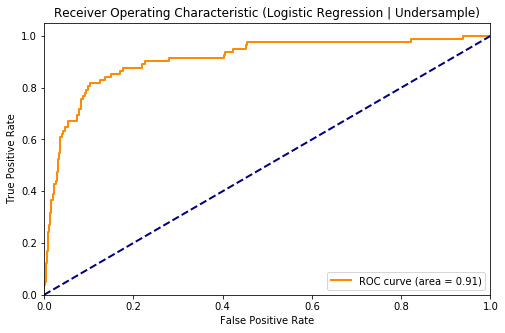

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Logistic Regression | Undersample)
ACC: 0.8226419440285616
Sensitivity: 0.7583732057416268
Specificity: 0.825892316999395
F1-Score: 0.29162833486660533
AUC: 0.8674971126876754


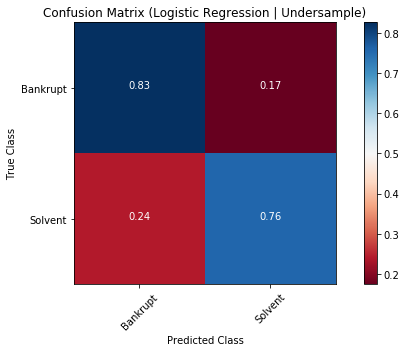

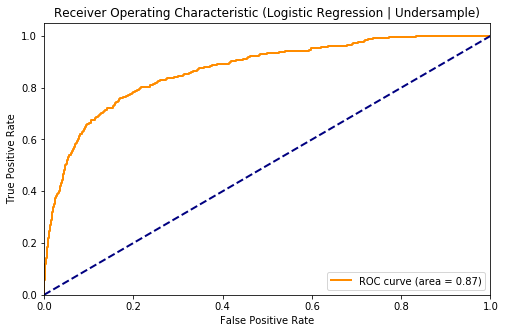

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Logistic Regression | Min-Max Scaler)
ACC: 0.03911806543385491
Sensitivity: 1.0
Specificity: 0.0007396449704142012
F1-Score: 0.07402330363262508
AUC: 0.703635218058295


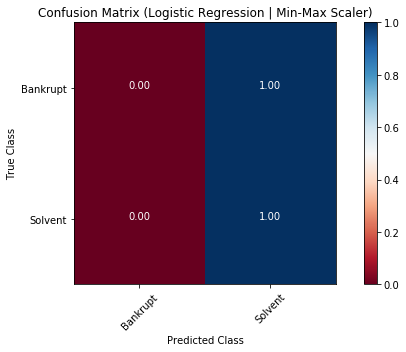

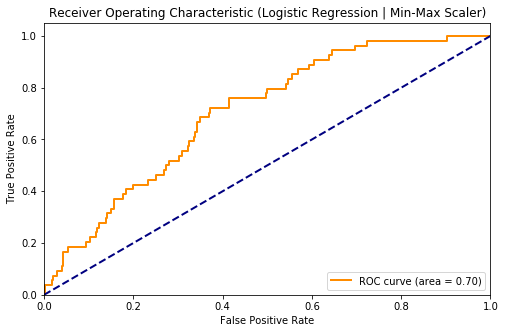

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Logistic Regression | Min-Max Scaler)
ACC: 0.040294840294840296
Sensitivity: 1.0
Specificity: 0.0010230179028132991
F1-Score: 0.07572172266919074
AUC: 0.6225255754475704


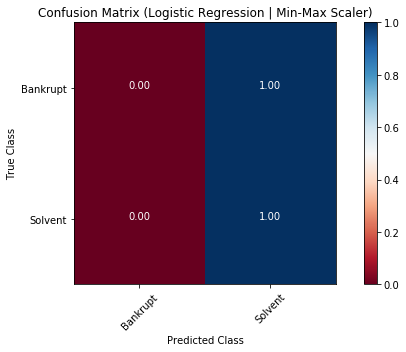

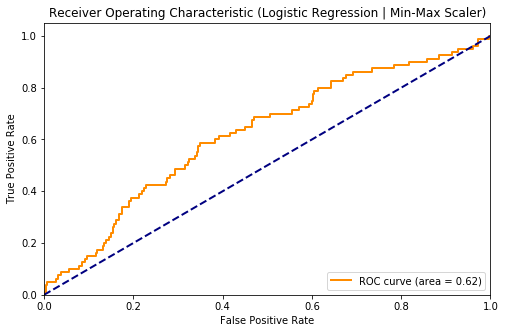

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Logistic Regression | Min-Max Scaler)
ACC: 0.9252736792003807
Sensitivity: 0.050505050505050504
Specificity: 0.9685314685314685
F1-Score: 0.05988023952095808
AUC: 0.6438763256945075


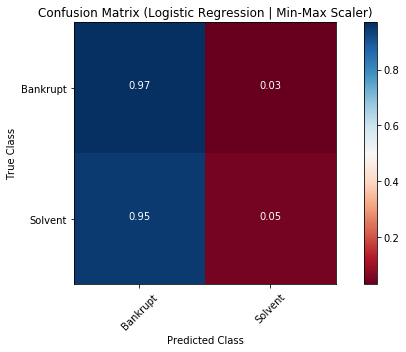

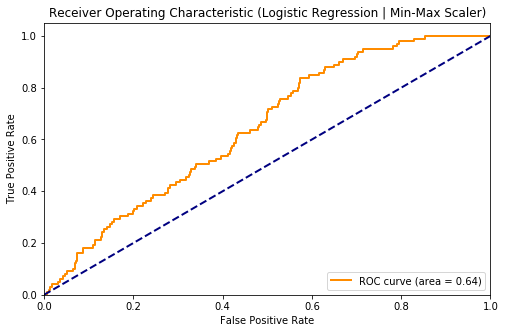

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Logistic Regression | Min-Max Scaler)
ACC: 0.05410923940786115
Sensitivity: 1.0
Specificity: 0.0016163793103448276
F1-Score: 0.10004856726566293
AUC: 0.7599232089052561


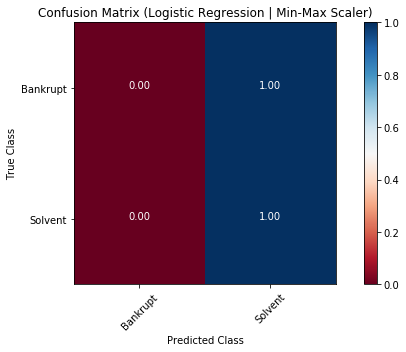

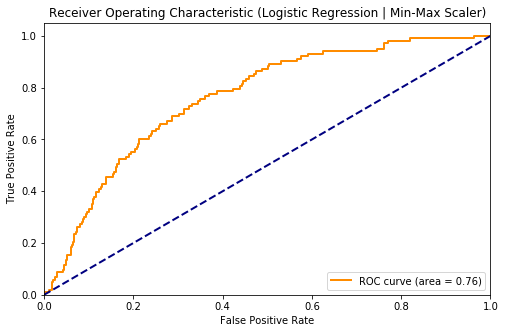

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Logistic Regression | Min-Max Scaler)
ACC: 0.7470389170896785
Sensitivity: 0.47560975609756095
Specificity: 0.7672727272727272
F1-Score: 0.20689655172413793
AUC: 0.6662416851441242


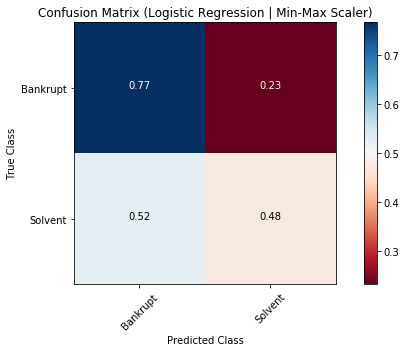

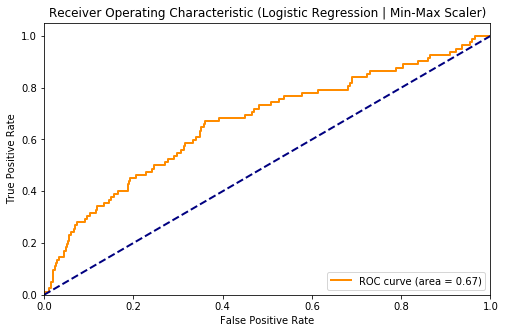

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Logistic Regression | Min-Max Scaler)
ACC: 0.35356443625475065
Sensitivity: 0.6722488038277512
Specificity: 0.33744706594071383
F1-Score: 0.09101214574898786
AUC: 0.5133065298124043


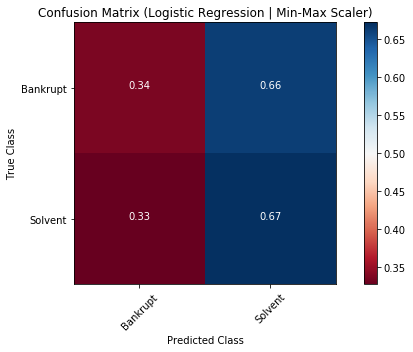

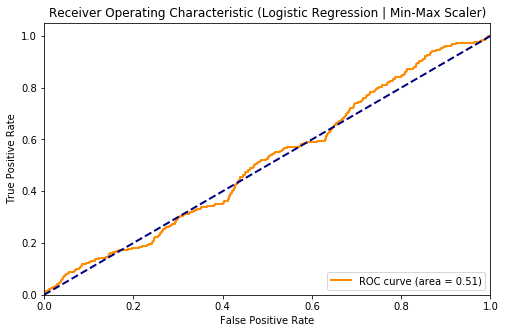

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Logistic Regression | Normaliser)
ACC: 0.7610241820768137
Sensitivity: 0.4444444444444444
Specificity: 0.7736686390532544
F1-Score: 0.125
AUC: 0.702238110891957


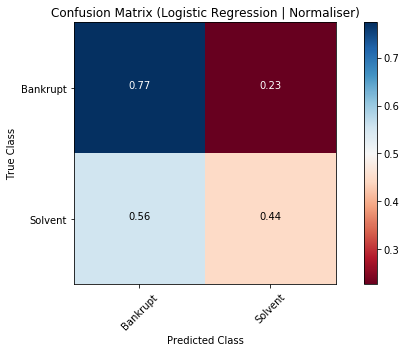

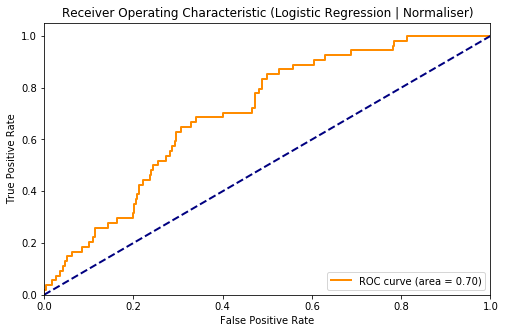

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Logistic Regression | Normaliser)
ACC: 0.7208845208845209
Sensitivity: 0.4
Specificity: 0.7340153452685422
F1-Score: 0.10126582278481013
AUC: 0.6322058823529412


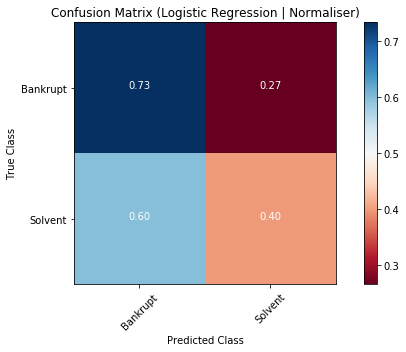

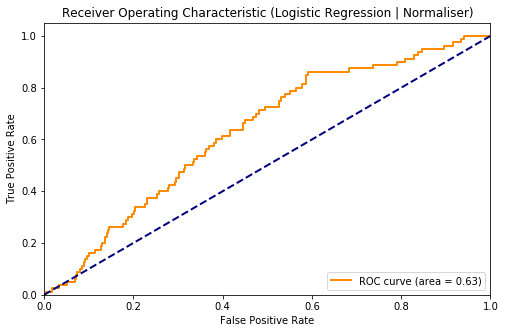

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Logistic Regression | Normaliser)
ACC: 0.7482151356496907
Sensitivity: 0.5353535353535354
Specificity: 0.7587412587412588
F1-Score: 0.16692913385826771
AUC: 0.7000625636989273


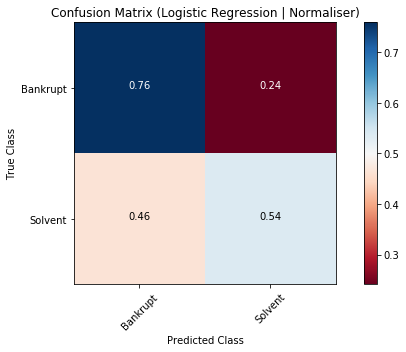

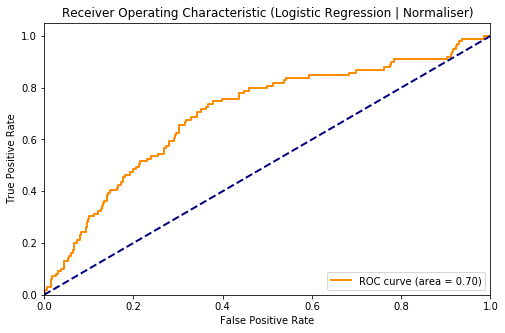

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Logistic Regression | Normaliser)
ACC: 0.6477794793261868
Sensitivity: 0.6407766990291263
Specificity: 0.6481681034482759
F1-Score: 0.16058394160583944
AUC: 0.696042224640107


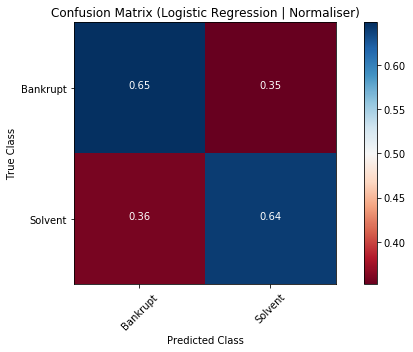

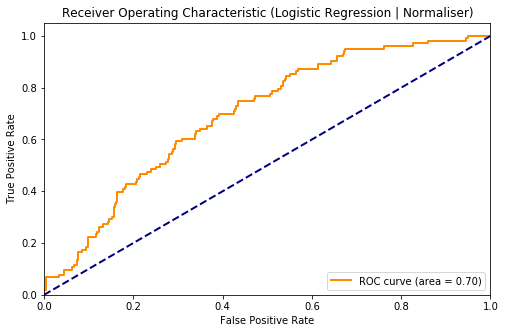

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Logistic Regression | Normaliser)
ACC: 0.8028764805414551
Sensitivity: 0.6463414634146342
Specificity: 0.8145454545454546
F1-Score: 0.3126843657817109
AUC: 0.7975388026607538


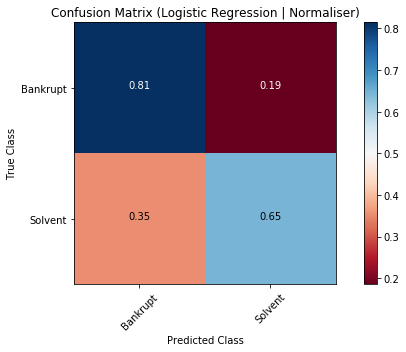

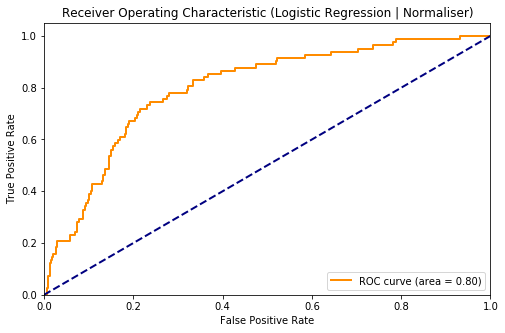

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Logistic Regression | Normaliser)
ACC: 0.7286652078774617
Sensitivity: 0.5454545454545454
Specificity: 0.7379310344827587
F1-Score: 0.16216216216216217
AUC: 0.6966544806166546


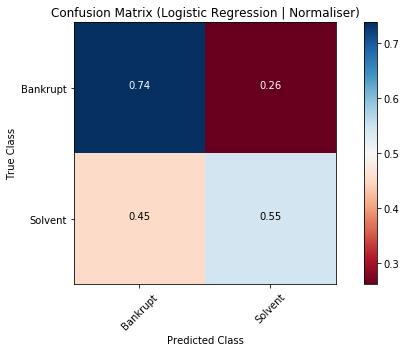

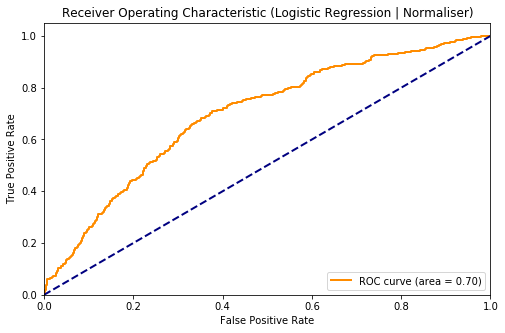

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Logistic Regression | Standard Scaler)
ACC: 0.7453769559032717
Sensitivity: 0.7962962962962963
Specificity: 0.7433431952662722
F1-Score: 0.19369369369369369
AUC: 0.8125821827744905


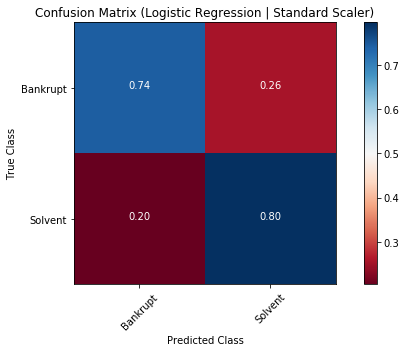

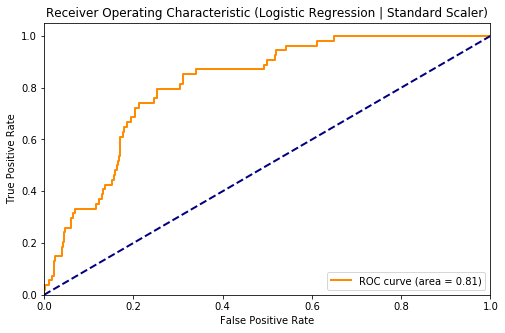

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Logistic Regression | Standard Scaler)
ACC: 0.7090909090909091
Sensitivity: 0.6
Specificity: 0.7135549872122762
F1-Score: 0.1395348837209302
AUC: 0.6786413043478261


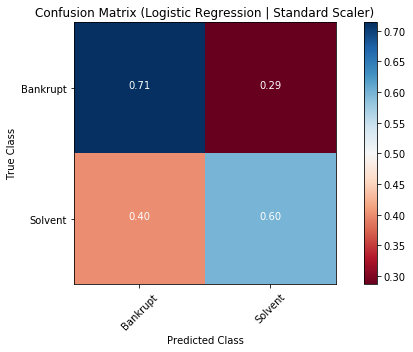

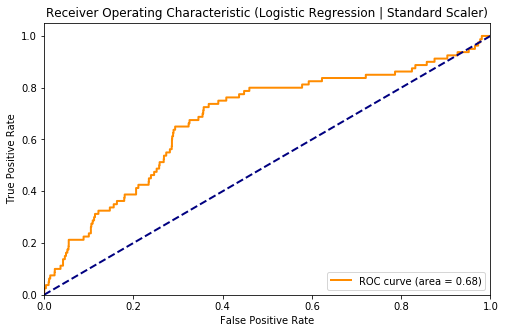

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Logistic Regression | Standard Scaler)
ACC: 0.7686815801999048
Sensitivity: 0.6060606060606061
Specificity: 0.7767232767232767
F1-Score: 0.198019801980198
AUC: 0.7577725304998033


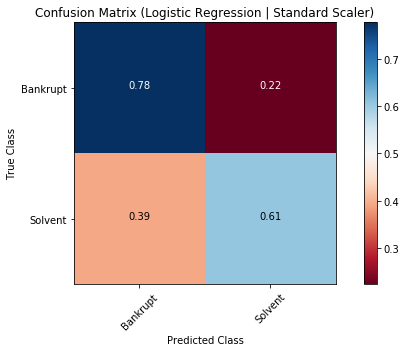

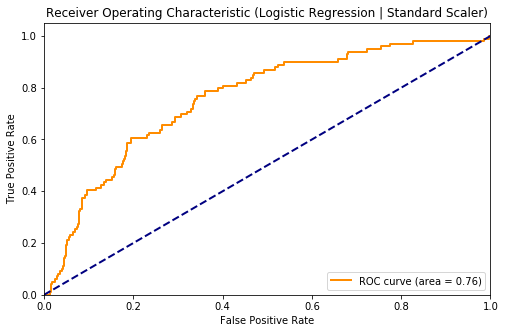

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Logistic Regression | Standard Scaler)
ACC: 0.7187340479836651
Sensitivity: 0.6796116504854369
Specificity: 0.7209051724137931
F1-Score: 0.20260492040520983
AUC: 0.7552362320053565


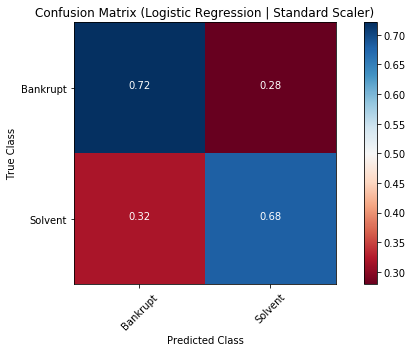

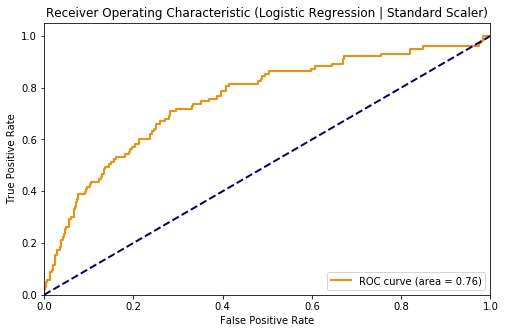

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Logistic Regression | Standard Scaler)
ACC: 0.8155668358714044
Sensitivity: 0.6707317073170732
Specificity: 0.8263636363636364
F1-Score: 0.3353658536585366
AUC: 0.806729490022173


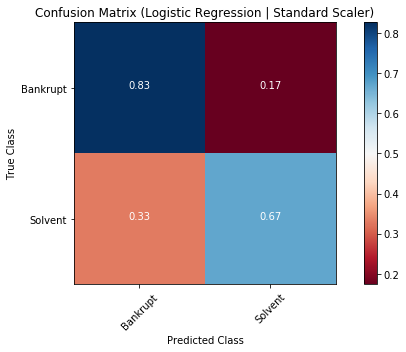

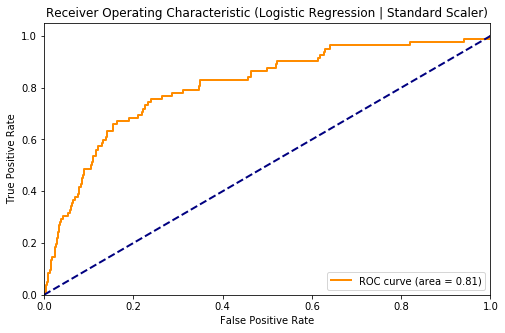

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Logistic Regression | Standard Scaler)
ACC: 0.7460555107681677
Sensitivity: 0.6602870813397129
Specificity: 0.7503932244404113
F1-Score: 0.2002176278563656
AUC: 0.7508509973167535


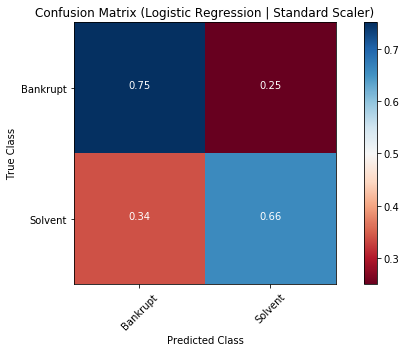

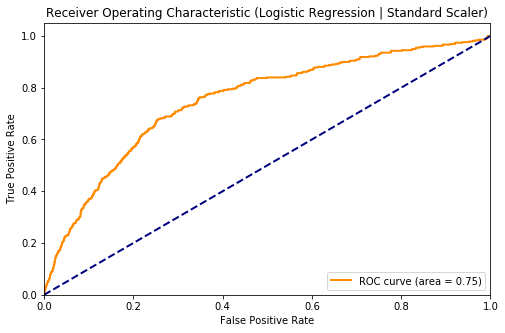

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Logistic Regression | PCA)
ACC: 0.9018492176386913
Sensitivity: 0.8518518518518519
Specificity: 0.9038461538461539
F1-Score: 0.39999999999999997
AUC: 0.9418693841770764


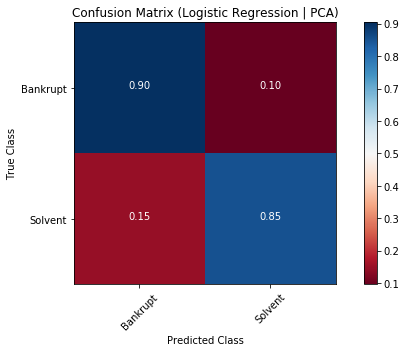

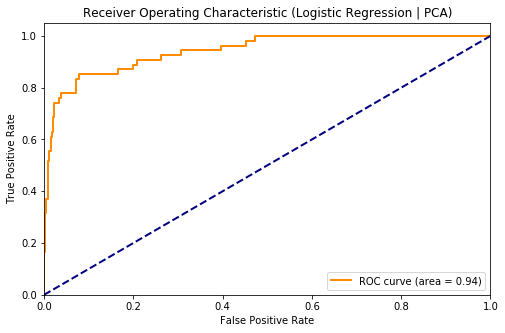

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Logistic Regression | PCA)
ACC: 0.8117936117936118
Sensitivity: 0.6
Specificity: 0.8204603580562659
F1-Score: 0.20041753653444674
AUC: 0.7849040920716113


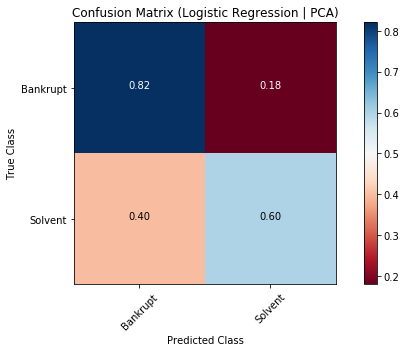

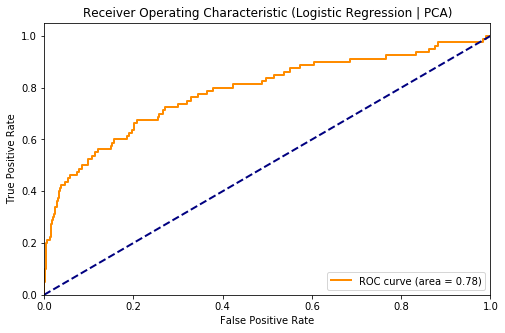

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Logistic Regression | PCA)
ACC: 0.814850071394574
Sensitivity: 0.7878787878787878
Specificity: 0.8161838161838162
F1-Score: 0.2862385321100917
AUC: 0.8729452365816002


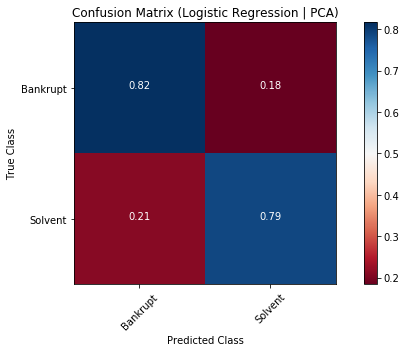

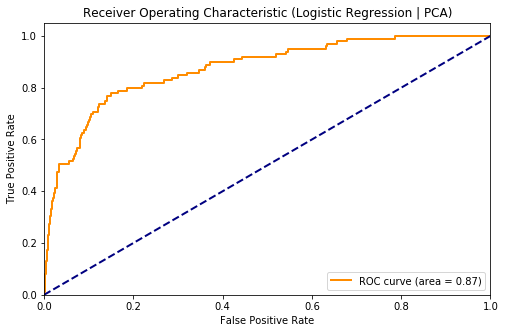

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Logistic Regression | PCA)
ACC: 0.8254211332312404
Sensitivity: 0.7766990291262136
Specificity: 0.828125
F1-Score: 0.3187250996015936
AUC: 0.865939906260462


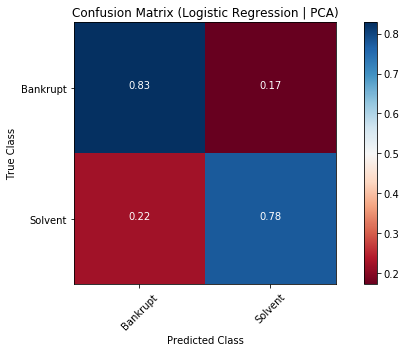

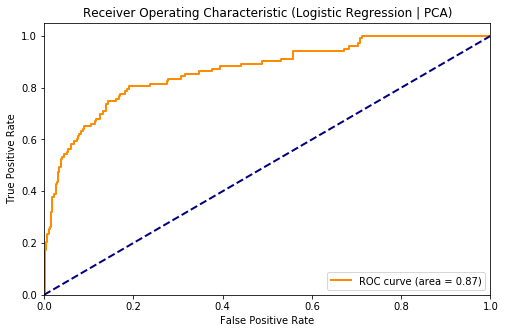

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Logistic Regression | PCA)
ACC: 0.8510998307952623
Sensitivity: 0.8780487804878049
Specificity: 0.8490909090909091
F1-Score: 0.45
AUC: 0.9152439024390243


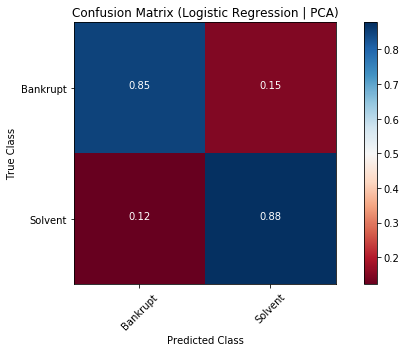

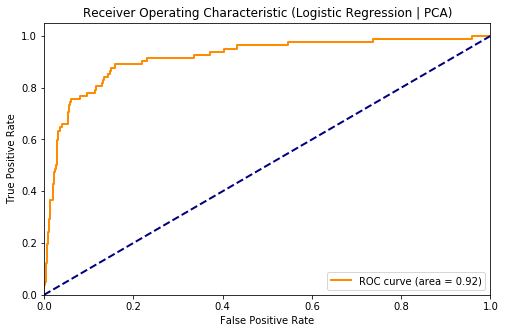

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Logistic Regression | PCA)
ACC: 0.8355407117355753
Sensitivity: 0.7751196172248804
Specificity: 0.8385964912280702
F1-Score: 0.31213872832369943
AUC: 0.8768404264249141


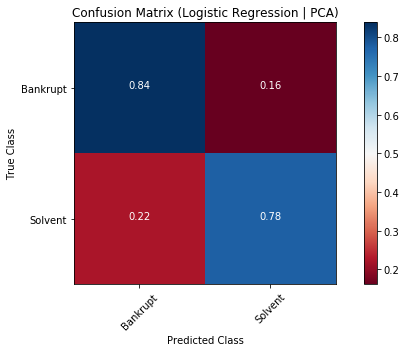

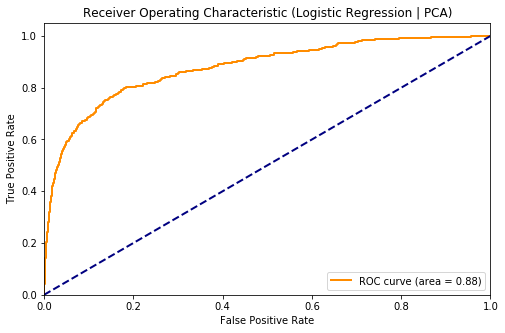

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Logistic Regression | L2 Regularisation)
ACC: 0.9082503556187767
Sensitivity: 0.8518518518518519
Specificity: 0.9105029585798816
F1-Score: 0.416289592760181
AUC: 0.9426227262765724


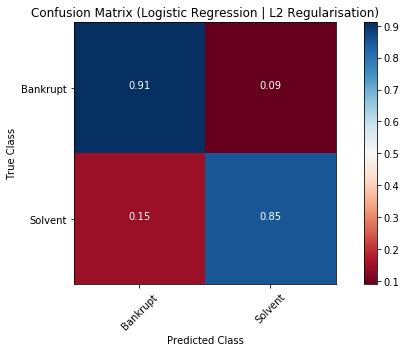

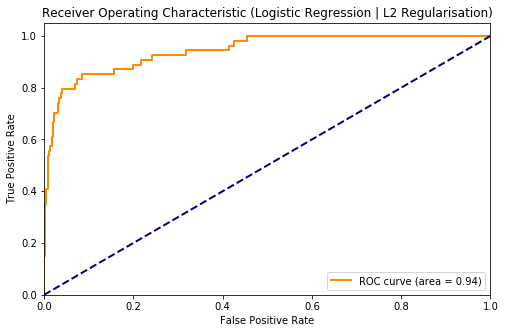

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Logistic Regression | L2 Regularisation)
ACC: 0.830958230958231
Sensitivity: 0.5875
Specificity: 0.8409207161125319
F1-Score: 0.2146118721461187
AUC: 0.7861445012787724


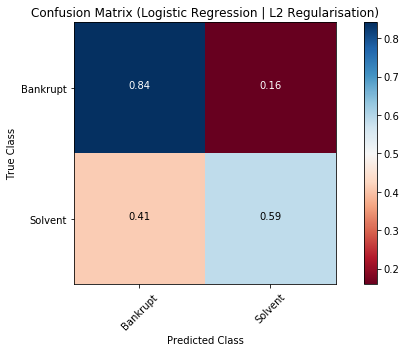

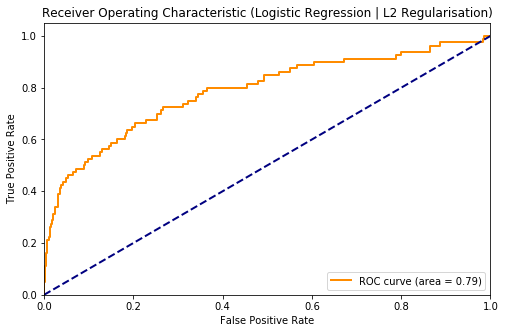

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Logistic Regression | L2 Regularisation)
ACC: 0.8676820561637315
Sensitivity: 0.6868686868686869
Specificity: 0.8766233766233766
F1-Score: 0.3285024154589372
AUC: 0.8775870594052413


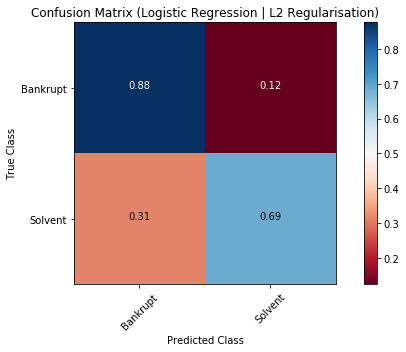

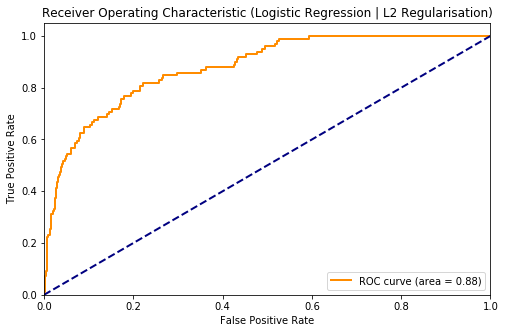

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Logistic Regression | L2 Regularisation)
ACC: 0.8698315467075038
Sensitivity: 0.6796116504854369
Specificity: 0.8803879310344828
F1-Score: 0.35443037974683544
AUC: 0.8617027954469366


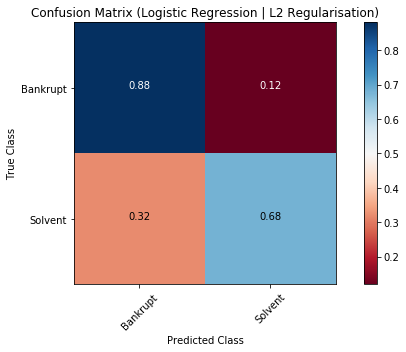

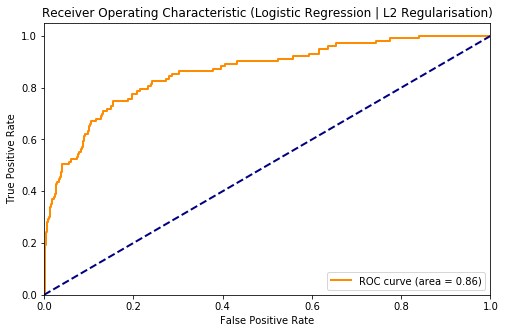

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Logistic Regression | L2 Regularisation)
ACC: 0.8451776649746193
Sensitivity: 0.8780487804878049
Specificity: 0.8427272727272728
F1-Score: 0.44036697247706424
AUC: 0.9164855875831486


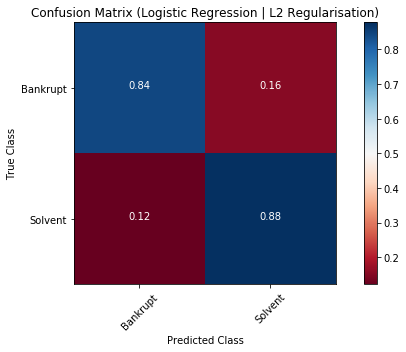

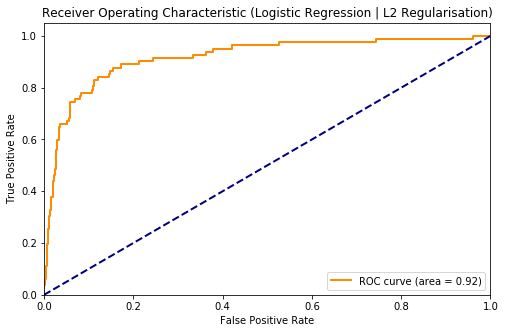

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Logistic Regression | L2 Regularisation)
ACC: 0.863065760681792
Sensitivity: 0.7248803827751196
Specificity: 0.8700544464609801
F1-Score: 0.3376044568245125
AUC: 0.8743844018559846


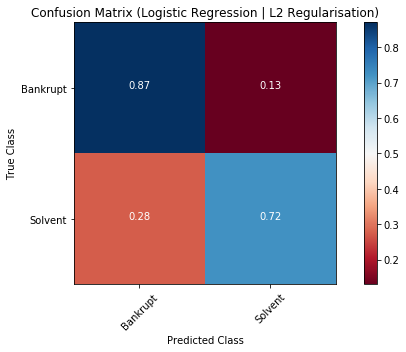

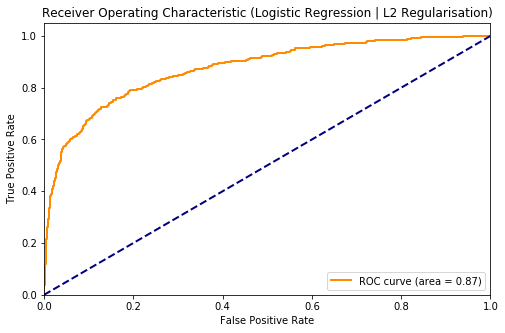

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Logistic Regression | kBest Features)
ACC: 0.8748221906116643
Sensitivity: 0.8148148148148148
Specificity: 0.8772189349112426
F1-Score: 0.33333333333333337
AUC: 0.9341168091168092


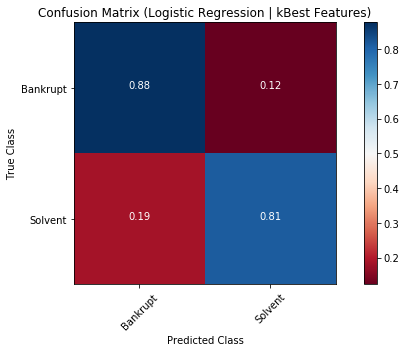

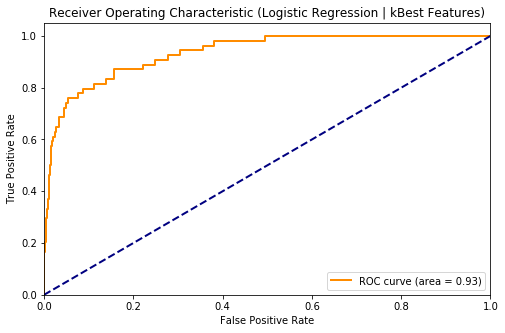

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Logistic Regression | kBest Features)
ACC: 0.8746928746928747
Sensitivity: 0.575
Specificity: 0.8869565217391304
F1-Score: 0.26512968299711814
AUC: 0.793113810741688


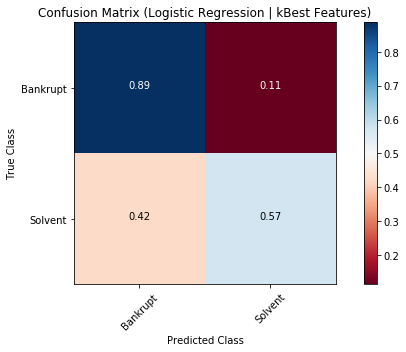

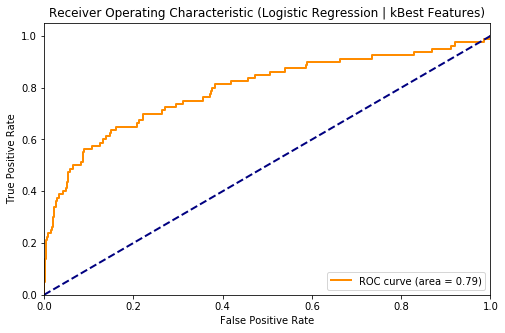

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Logistic Regression | kBest Features)
ACC: 0.8129462160875773
Sensitivity: 0.7676767676767676
Specificity: 0.8151848151848152
F1-Score: 0.27889908256880735
AUC: 0.878419560237742


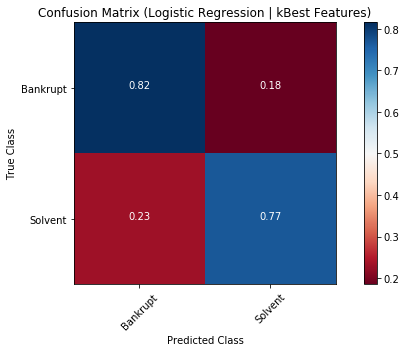

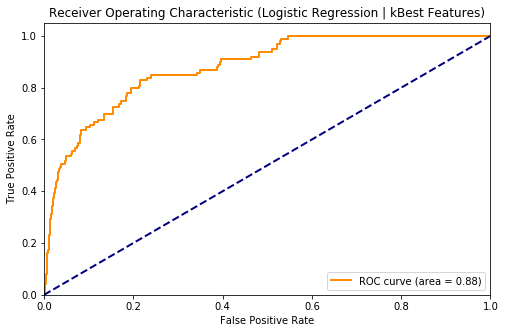

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Logistic Regression | kBest Features)
ACC: 0.8688106176620725
Sensitivity: 0.6796116504854369
Specificity: 0.8793103448275862
F1-Score: 0.3526448362720403
AUC: 0.859599933043187


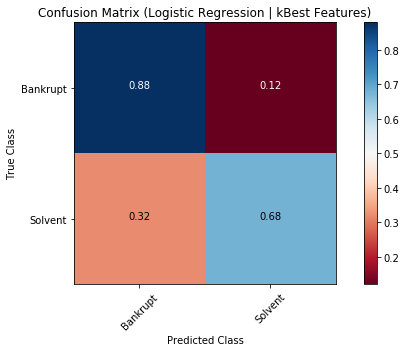

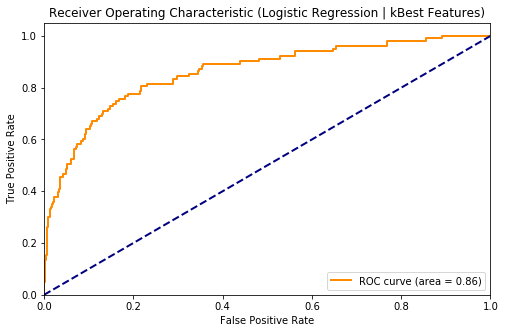

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Logistic Regression | kBest Features)
ACC: 0.8705583756345178
Sensitivity: 0.7195121951219512
Specificity: 0.8818181818181818
F1-Score: 0.4354243542435424
AUC: 0.8769844789356986


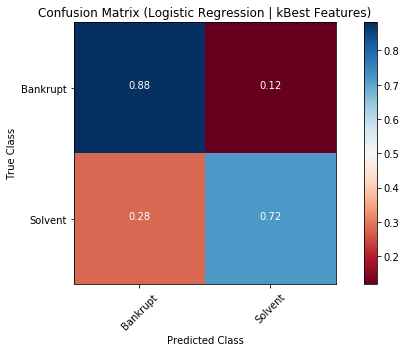

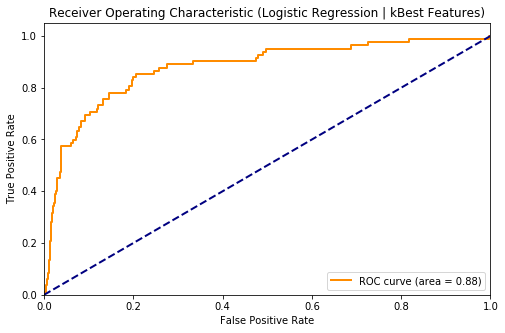

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Logistic Regression | kBest Features)
ACC: 0.857883220085224
Sensitivity: 0.7057416267942583
Specificity: 0.8655777374470659
F1-Score: 0.3234649122807018
AUC: 0.8646448244022032


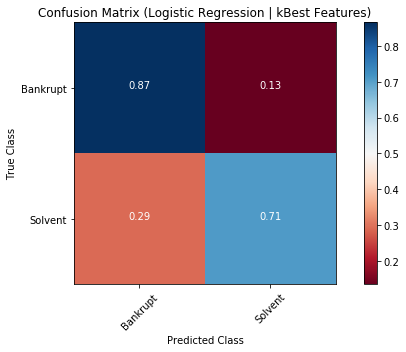

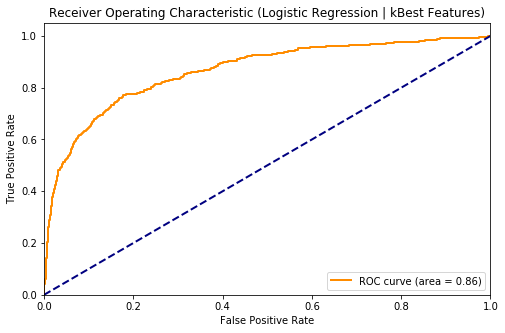

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Logistic Regression | Mean Imputation)
ACC: 0.883357041251778
Sensitivity: 0.7962962962962963
Specificity: 0.8868343195266272
F1-Score: 0.344
AUC: 0.9373082401928556


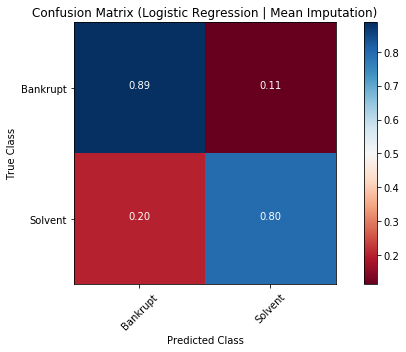

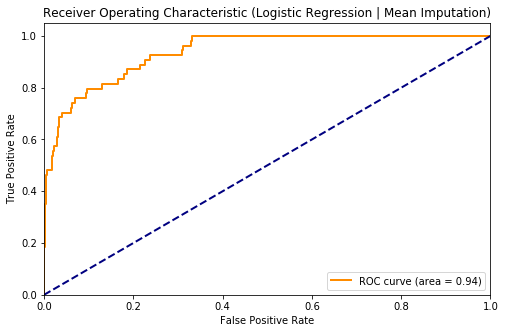

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Logistic Regression | Mean Imputation)
ACC: 0.8643734643734644
Sensitivity: 0.55
Specificity: 0.8772378516624041
F1-Score: 0.24175824175824173
AUC: 0.7729539641943733


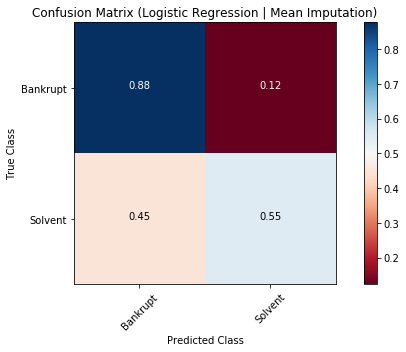

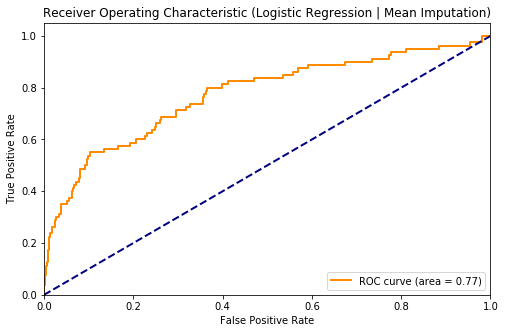

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Logistic Regression | Mean Imputation)
ACC: 0.7696335078534031
Sensitivity: 0.797979797979798
Specificity: 0.7682317682317682
F1-Score: 0.24610591900311526
AUC: 0.8850745214381578


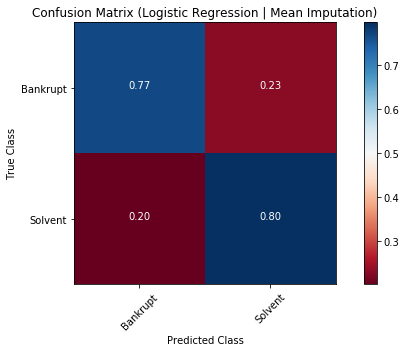

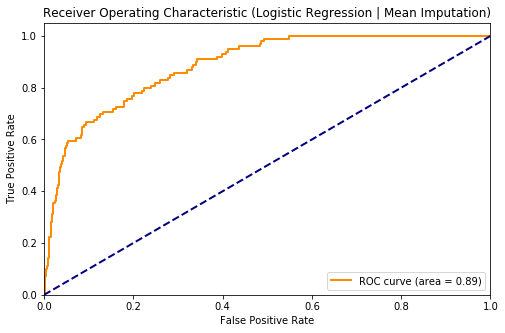

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Logistic Regression | Mean Imputation)
ACC: 0.8024502297090352
Sensitivity: 0.6990291262135923
Specificity: 0.8081896551724138
F1-Score: 0.2711864406779661
AUC: 0.8568170405088718


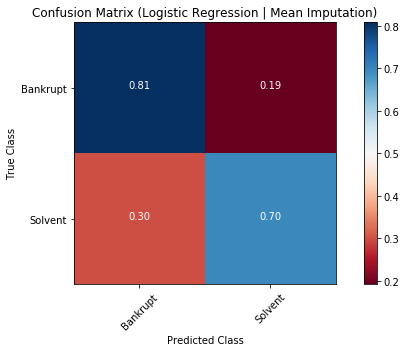

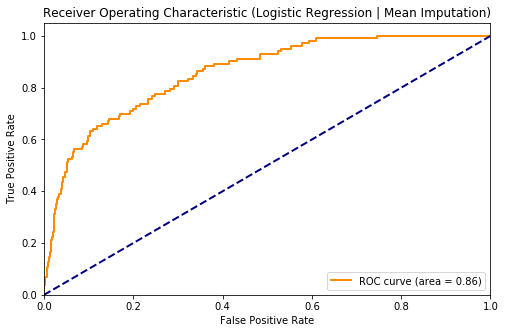

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Logistic Regression | Mean Imputation)
ACC: 0.8291032148900169
Sensitivity: 0.7926829268292683
Specificity: 0.8318181818181818
F1-Score: 0.391566265060241
AUC: 0.8951219512195122


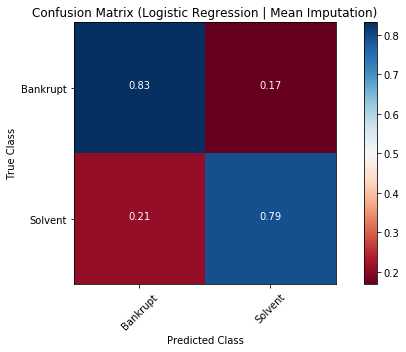

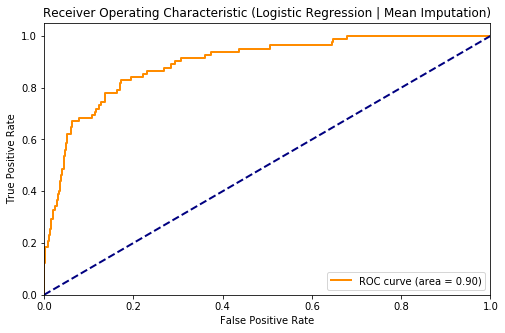

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Logistic Regression | Mean Imputation)
ACC: 0.8257514683865024
Sensitivity: 0.7248803827751196
Specificity: 0.8308529945553539
F1-Score: 0.28598395469561116
AUC: 0.8669538058973535


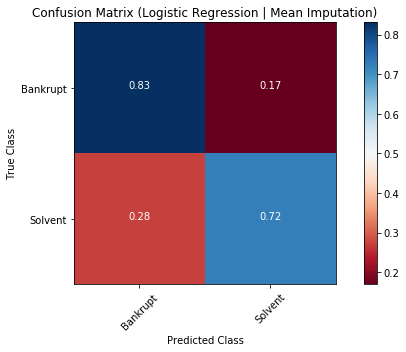

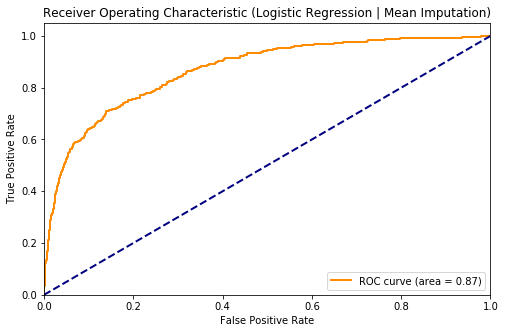

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Logistic Regression | Median Imputation)
ACC: 0.6102418207681366
Sensitivity: 0.9444444444444444
Specificity: 0.5968934911242604
F1-Score: 0.15692307692307694
AUC: 0.865302432610125


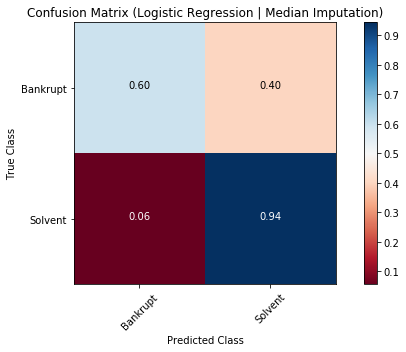

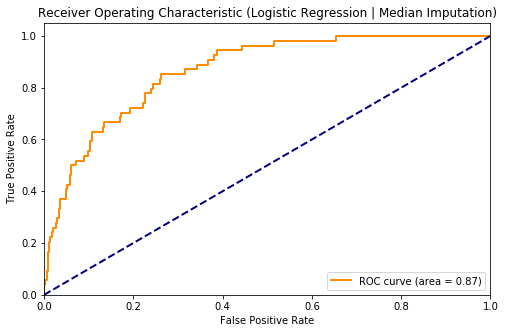

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Logistic Regression | Median Imputation)
ACC: 0.8093366093366093
Sensitivity: 0.4625
Specificity: 0.8235294117647058
F1-Score: 0.1601731601731602
AUC: 0.7161125319693095


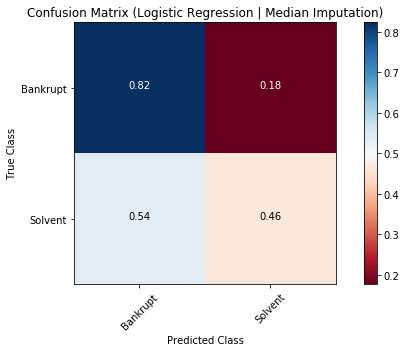

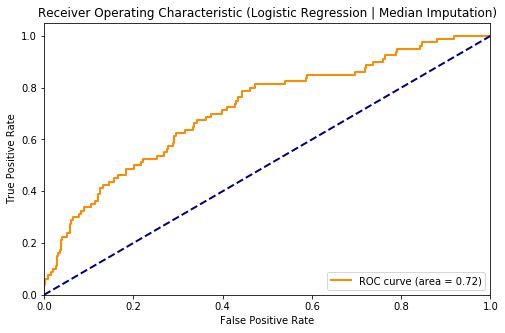

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Logistic Regression | Median Imputation)
ACC: 0.6915754402665397
Sensitivity: 0.8181818181818182
Specificity: 0.6853146853146853
F1-Score: 0.19999999999999998
AUC: 0.8476170294352112


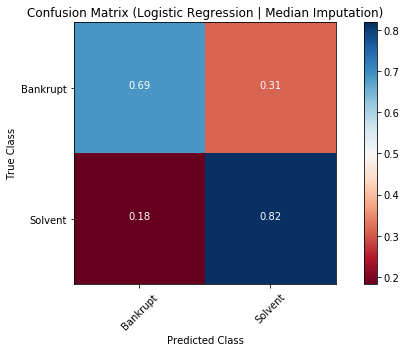

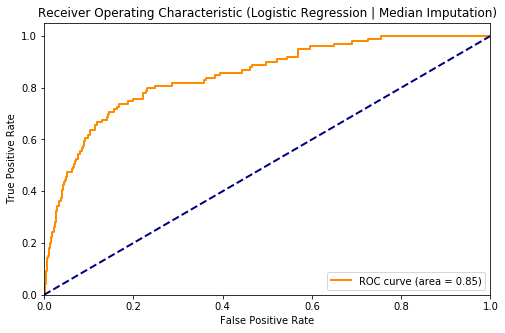

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Logistic Regression | Median Imputation)
ACC: 0.7891781521184278
Sensitivity: 0.7281553398058253
Specificity: 0.7925646551724138
F1-Score: 0.2664298401420959
AUC: 0.8304946434549716


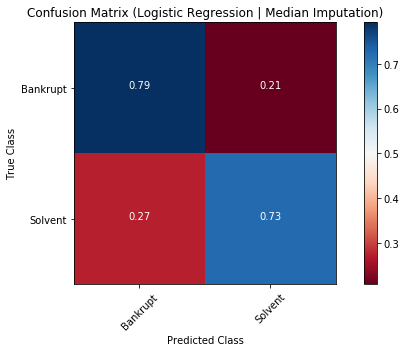

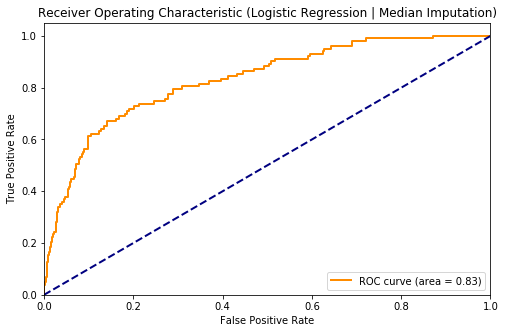

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Logistic Regression | Median Imputation)
ACC: 0.8764805414551607
Sensitivity: 0.7439024390243902
Specificity: 0.8863636363636364
F1-Score: 0.45522388059701496
AUC: 0.8871618625277161


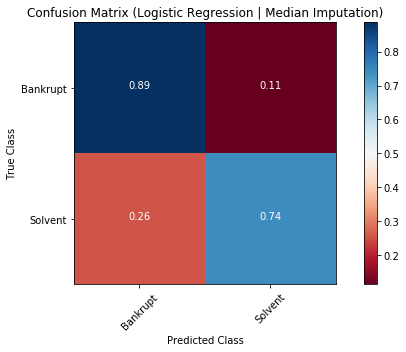

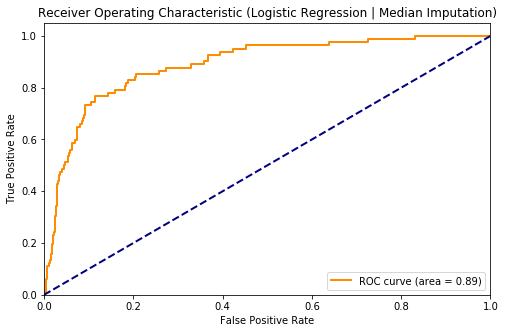

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Logistic Regression | Median Imputation)
ACC: 0.7531959000345503
Sensitivity: 0.7296650717703349
Specificity: 0.7543859649122807
F1-Score: 0.22157646204140935
AUC: 0.8149989724352127


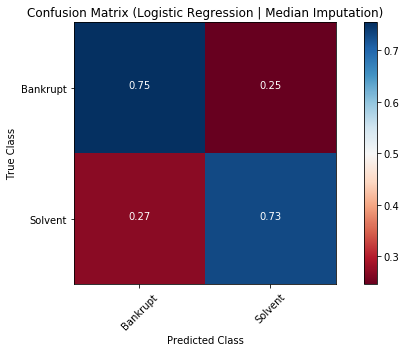

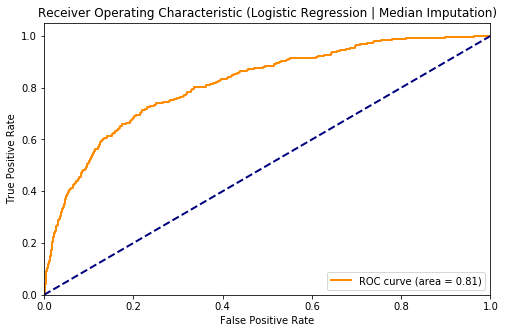

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Logistic Regression | Median by Class Imputation)
ACC: 0.6735419630156472
Sensitivity: 0.9074074074074074
Specificity: 0.6642011834319527
F1-Score: 0.17594254937163376
AUC: 0.8853139381985535


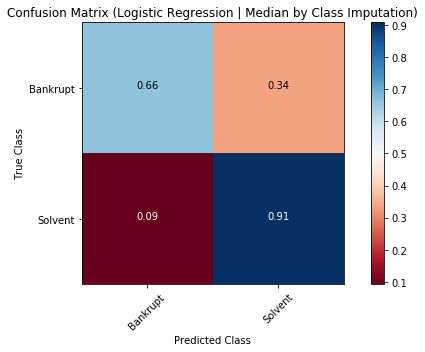

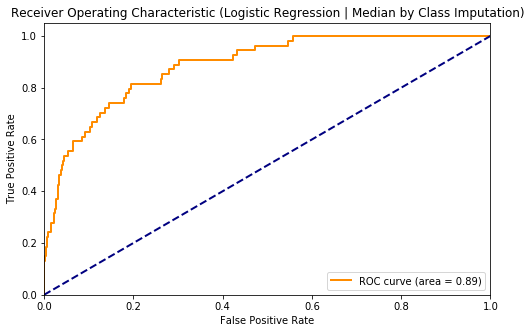

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Logistic Regression | Median by Class Imputation)
ACC: 0.8383292383292383
Sensitivity: 0.525
Specificity: 0.851150895140665
F1-Score: 0.2033898305084746
AUC: 0.7404219948849105


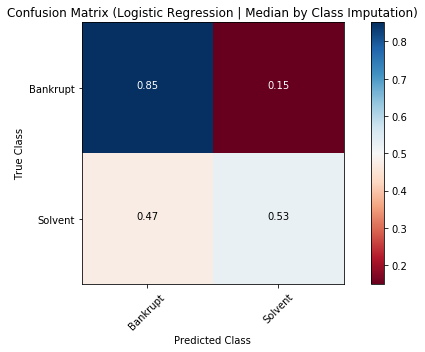

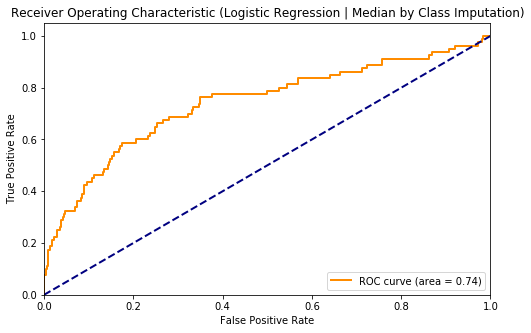

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Logistic Regression | Median by Class Imputation)
ACC: 0.7786768205616373
Sensitivity: 0.7676767676767676
Specificity: 0.7792207792207793
F1-Score: 0.24635332252836306
AUC: 0.8502608502608503


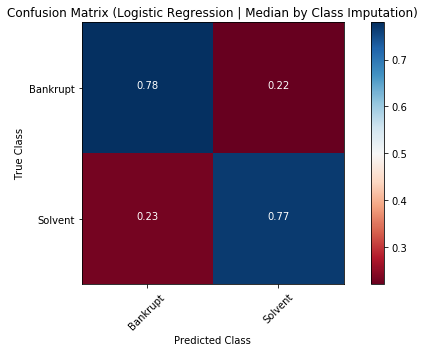

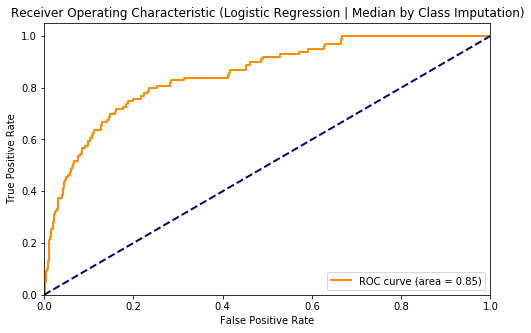

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Logistic Regression | Median by Class Imputation)
ACC: 0.8177641653905053
Sensitivity: 0.7087378640776699
Specificity: 0.8238146551724138
F1-Score: 0.29025844930417494
AUC: 0.8275338968865081


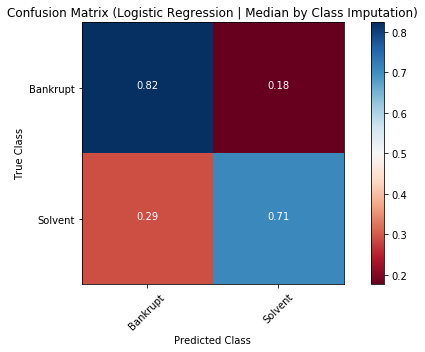

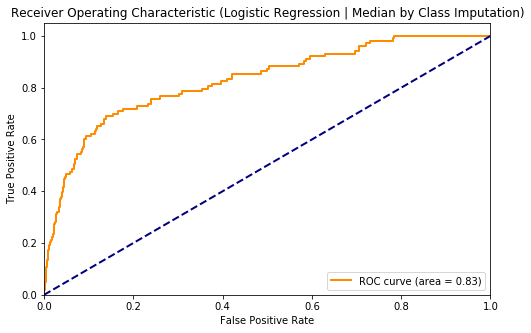

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Logistic Regression | Median by Class Imputation)
ACC: 0.8096446700507615
Sensitivity: 0.8536585365853658
Specificity: 0.8063636363636364
F1-Score: 0.3835616438356164
AUC: 0.9017627494456762


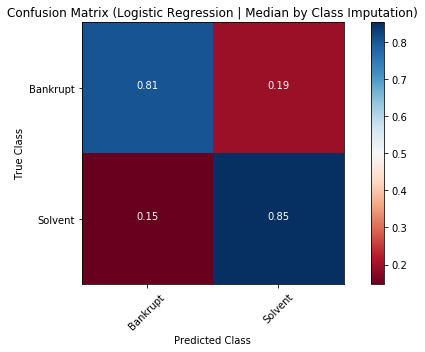

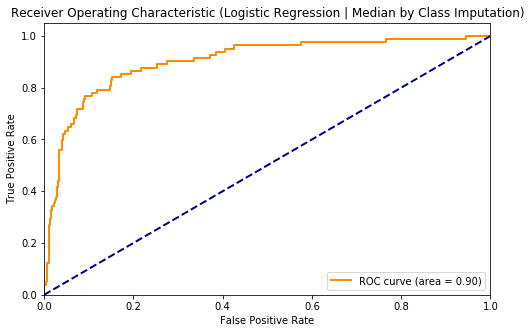

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Logistic Regression | Median by Class Imputation)
ACC: 0.7886675112288379
Sensitivity: 0.7416267942583732
Specificity: 0.7910465819721718
F1-Score: 0.25254582484725047
AUC: 0.8332728372655778


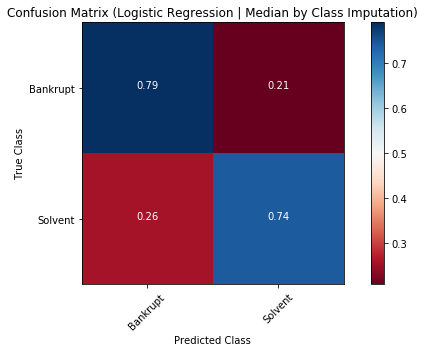

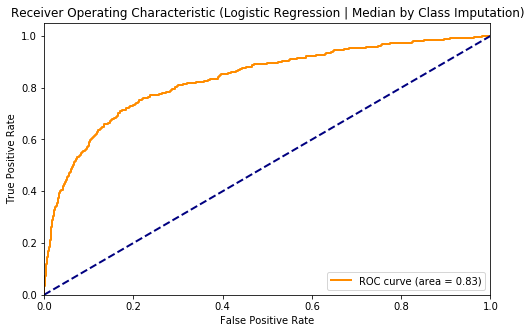

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Decision Tree | Baseline)
ACC: 0.9928876244665719
Sensitivity: 0.8518518518518519
Specificity: 0.9985207100591716
F1-Score: 0.9019607843137256
AUC: 0.9578813280736358


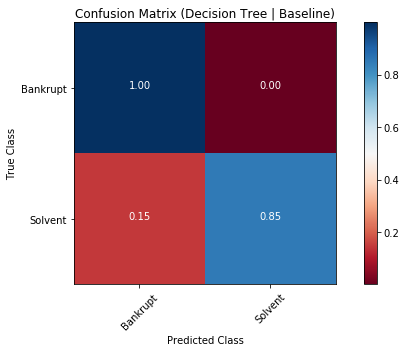

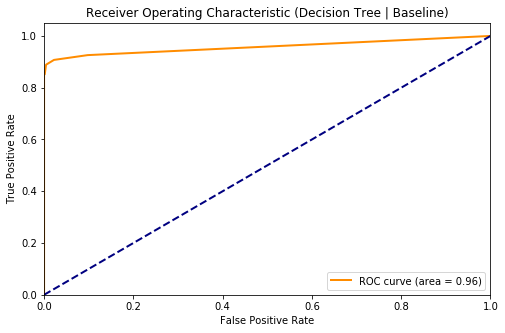

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Decision Tree | Baseline)
ACC: 0.9793611793611794
Sensitivity: 0.4875
Specificity: 0.9994884910485934
F1-Score: 0.65
AUC: 0.882969948849105


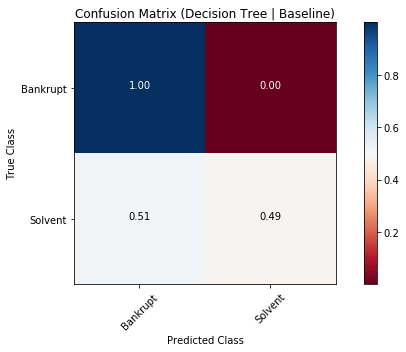

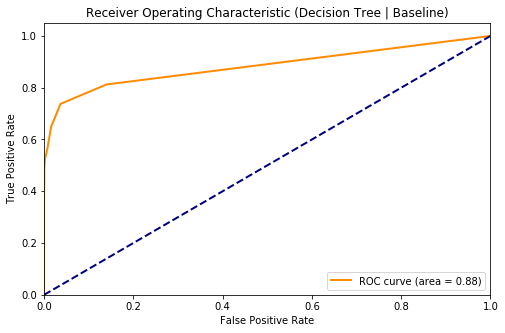

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Decision Tree | Baseline)
ACC: 0.9757258448357925
Sensitivity: 0.5050505050505051
Specificity: 0.999000999000999
F1-Score: 0.6622516556291391
AUC: 0.898487875760603


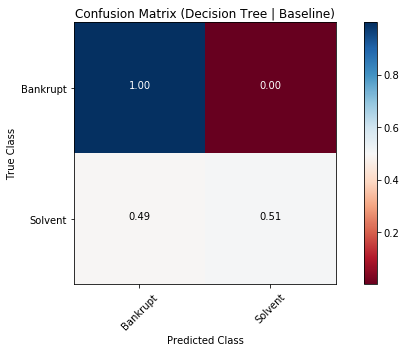

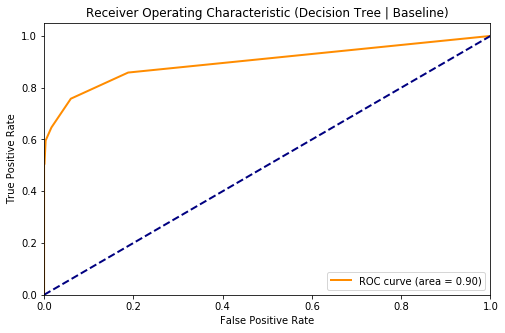

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Decision Tree | Baseline)
ACC: 0.9754977029096478
Sensitivity: 0.5922330097087378
Specificity: 0.9967672413793104
F1-Score: 0.7176470588235293
AUC: 0.9035246484767325


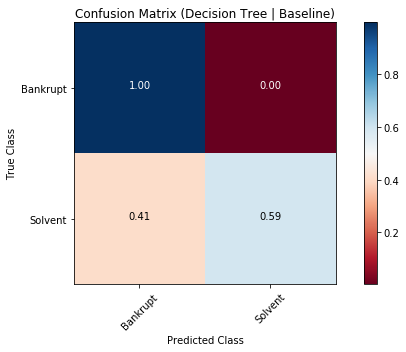

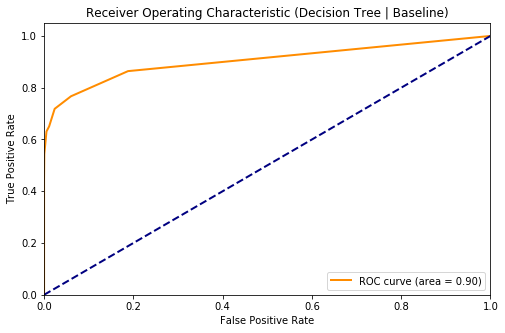

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Decision Tree | Baseline)
ACC: 0.9576988155668359
Sensitivity: 0.573170731707317
Specificity: 0.9863636363636363
F1-Score: 0.6527777777777778
AUC: 0.9083758314855874


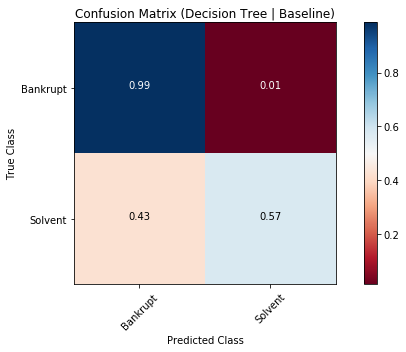

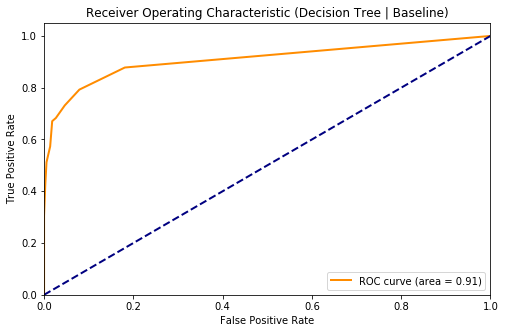

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Decision Tree | Baseline)
ACC: 0.9768513186686629
Sensitivity: 0.5813397129186603
Specificity: 0.996854204476709
F1-Score: 0.7074235807860262
AUC: 0.9085057760719237


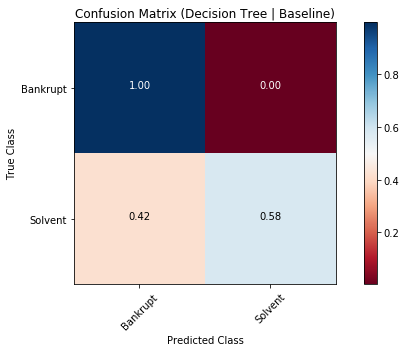

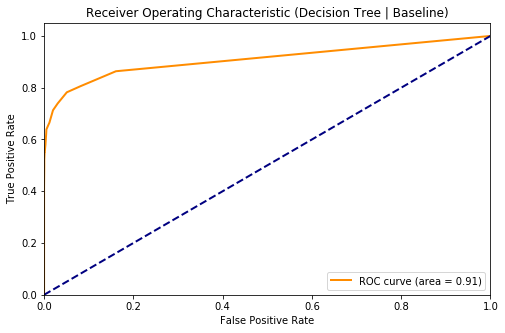

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Decision Tree | SMOTE)
ACC: 0.9879089615931721
Sensitivity: 0.7777777777777778
Specificity: 0.996301775147929
F1-Score: 0.8316831683168316
AUC: 0.9572992000876617


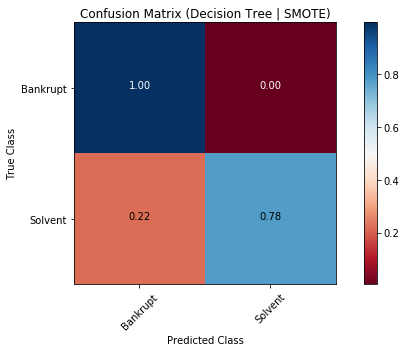

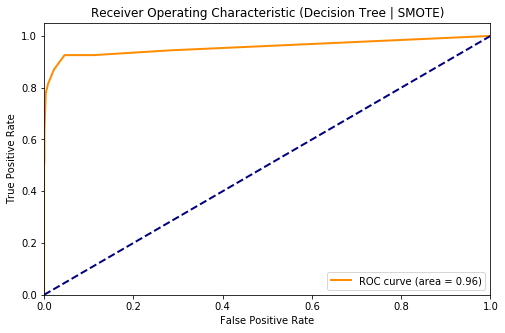

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Decision Tree | SMOTE)
ACC: 0.9769041769041769
Sensitivity: 0.5
Specificity: 0.9964194373401535
F1-Score: 0.6299212598425198
AUC: 0.9245652173913044


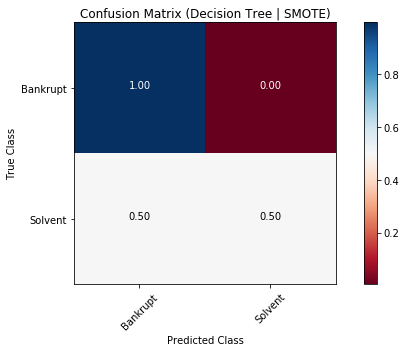

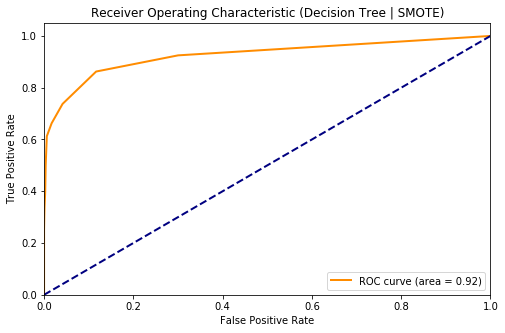

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Decision Tree | SMOTE)
ACC: 0.9757258448357925
Sensitivity: 0.6464646464646465
Specificity: 0.9920079920079921
F1-Score: 0.7150837988826817
AUC: 0.9084627493718402


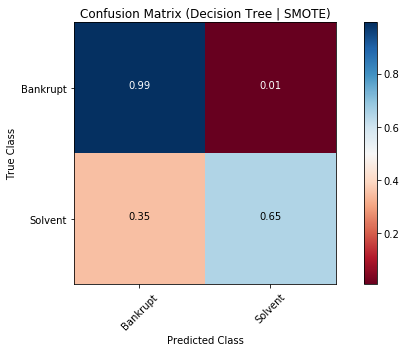

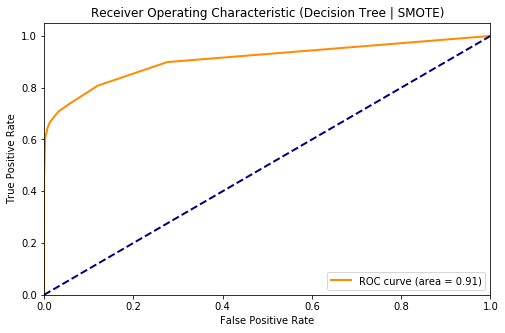

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Decision Tree | SMOTE)
ACC: 0.9709035222052067
Sensitivity: 0.5922330097087378
Specificity: 0.9919181034482759
F1-Score: 0.6815642458100559
AUC: 0.8958507700033479


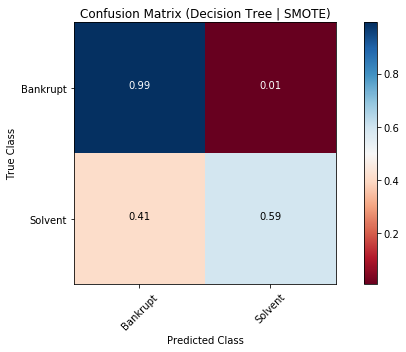

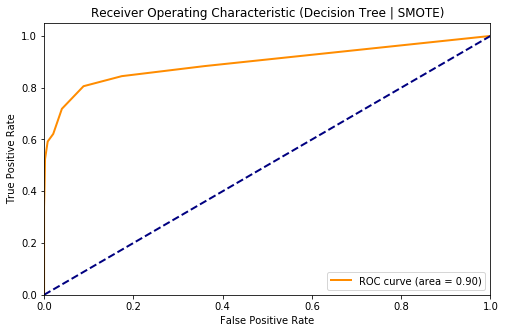

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Decision Tree | SMOTE)
ACC: 0.9483925549915397
Sensitivity: 0.5975609756097561
Specificity: 0.9745454545454545
F1-Score: 0.6163522012578616
AUC: 0.9233647450110865


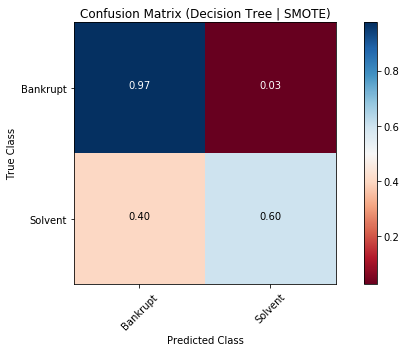

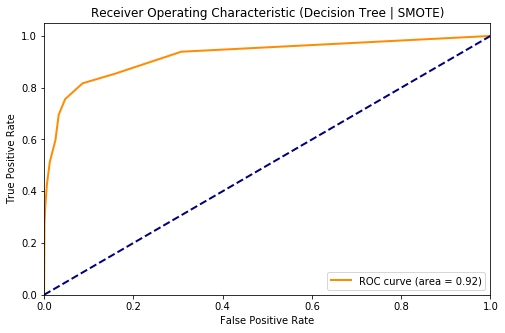

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Decision Tree | SMOTE)
ACC: 0.973165956466659
Sensitivity: 0.6124401913875598
Specificity: 0.9914095583787054
F1-Score: 0.687248322147651
AUC: 0.9179399786382307


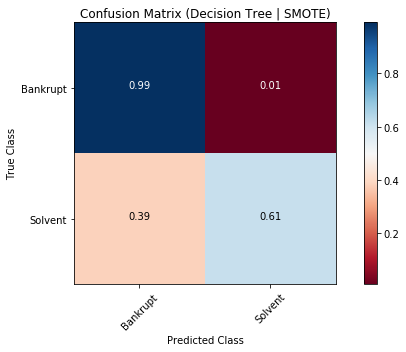

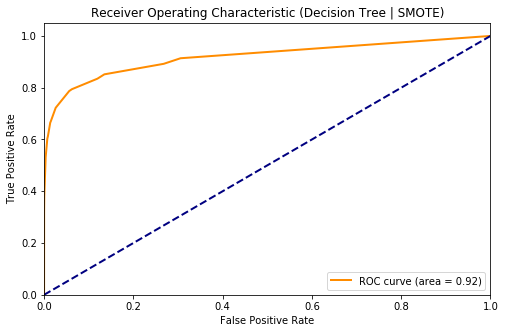

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Decision Tree | Undersample)
ACC: 0.8890469416785206
Sensitivity: 0.8888888888888888
Specificity: 0.8890532544378699
F1-Score: 0.38095238095238093
AUC: 0.9642436445321061


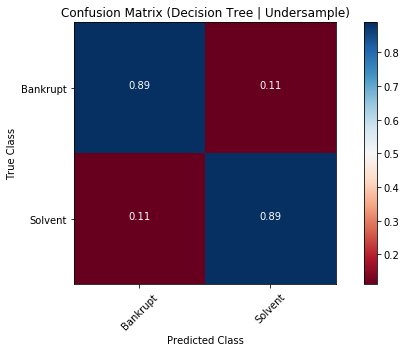

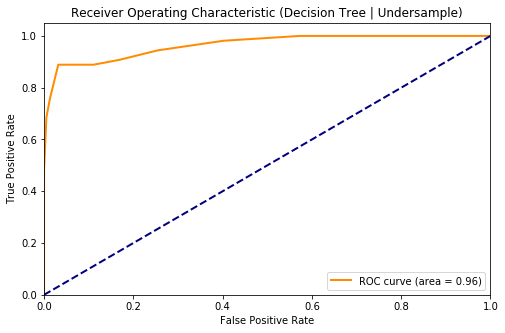

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Decision Tree | Undersample)
ACC: 0.8432432432432433
Sensitivity: 0.7875
Specificity: 0.8455242966751918
F1-Score: 0.28314606741573034
AUC: 0.9119053708439898


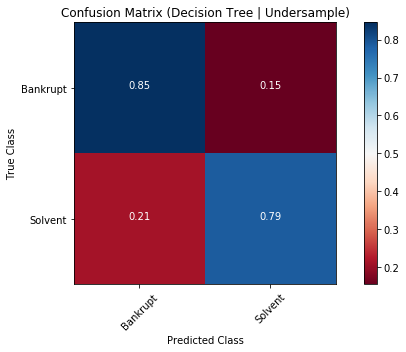

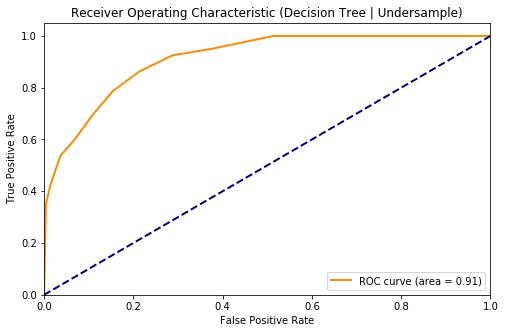

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Decision Tree | Undersample)
ACC: 0.8691099476439791
Sensitivity: 0.7777777777777778
Specificity: 0.8736263736263736
F1-Score: 0.35897435897435903
AUC: 0.9021710612619704


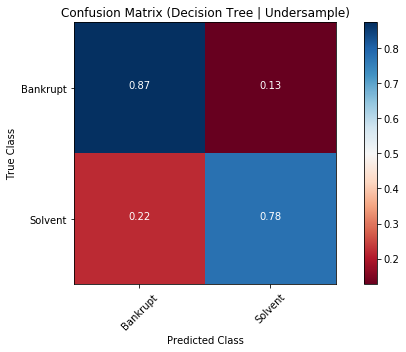

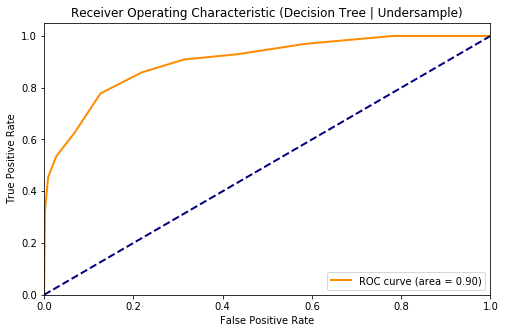

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Decision Tree | Undersample)
ACC: 0.81368044920878
Sensitivity: 0.8155339805825242
Specificity: 0.8135775862068966
F1-Score: 0.3151969981238274
AUC: 0.8991332231335789


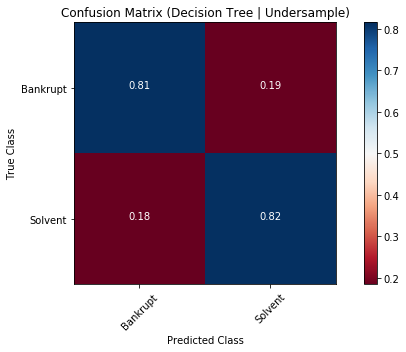

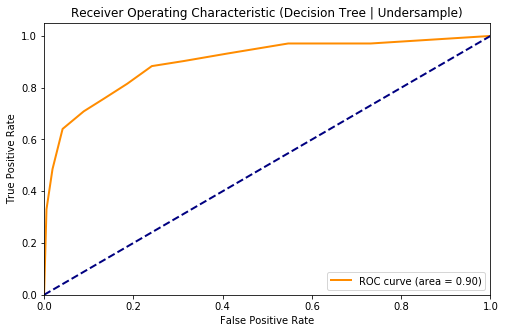

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Decision Tree | Undersample)
ACC: 0.8815566835871405
Sensitivity: 0.7682926829268293
Specificity: 0.89
F1-Score: 0.4736842105263158
AUC: 0.9158536585365855


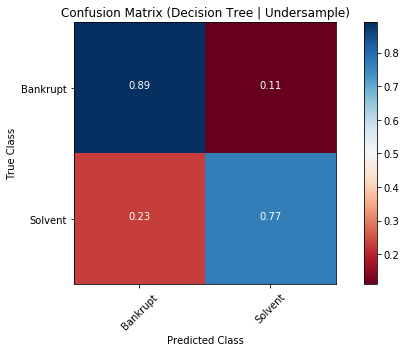

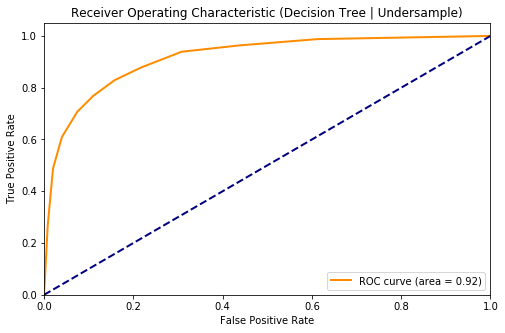

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Decision Tree | Undersample)
ACC: 0.8554647011401589
Sensitivity: 0.8014354066985646
Specificity: 0.8581972171808833
F1-Score: 0.348051948051948
AUC: 0.9151713428100857


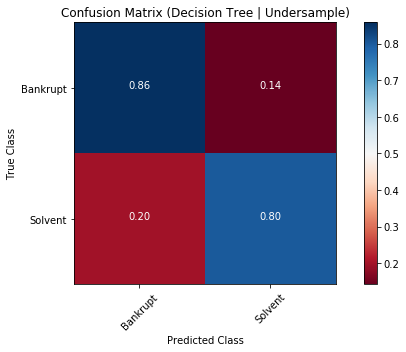

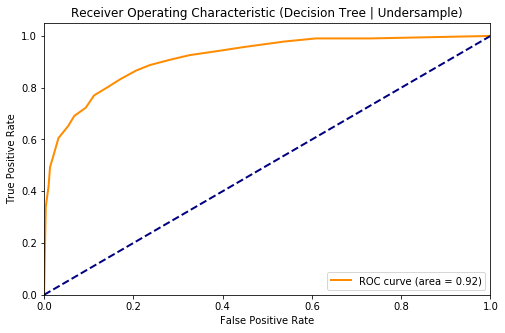

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Decision Tree | PCA)
ACC: 0.9708392603129445
Sensitivity: 0.25925925925925924
Specificity: 0.9992603550295858
F1-Score: 0.40579710144927533
AUC: 0.9392600810870042


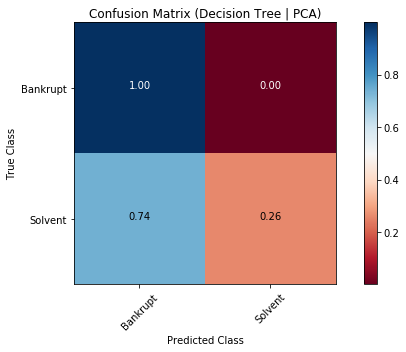

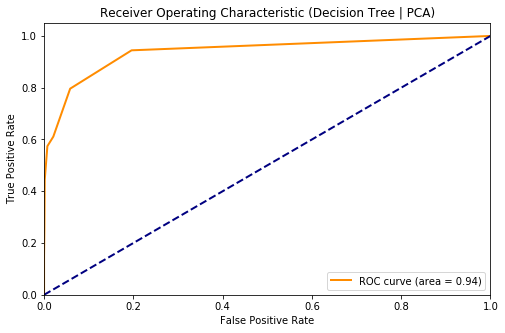

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Decision Tree | PCA)
ACC: 0.9714987714987715
Sensitivity: 0.3625
Specificity: 0.9964194373401535
F1-Score: 0.5
AUC: 0.8525127877237852


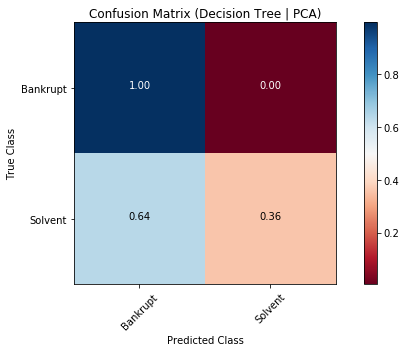

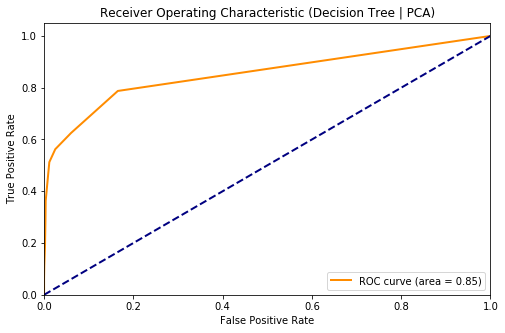

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Decision Tree | PCA)
ACC: 0.9662065683008091
Sensitivity: 0.3333333333333333
Specificity: 0.9975024975024975
F1-Score: 0.48175182481751827
AUC: 0.8509243281970555


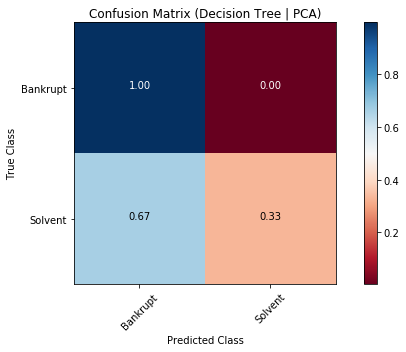

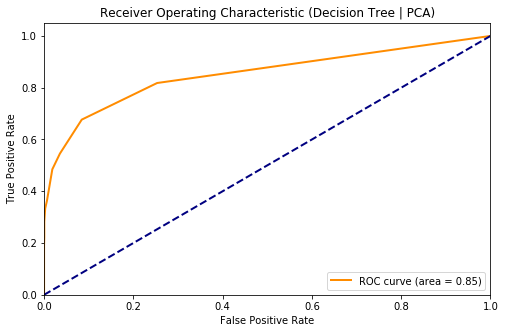

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Decision Tree | PCA)
ACC: 0.9668198060234814
Sensitivity: 0.44660194174757284
Specificity: 0.9956896551724138
F1-Score: 0.5859872611464969
AUC: 0.876187437227988


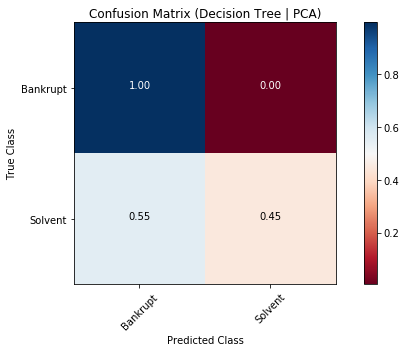

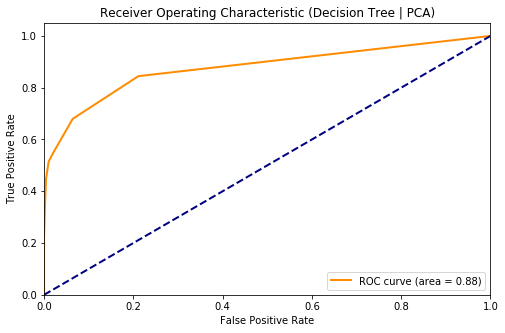

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Decision Tree | PCA)
ACC: 0.9424703891708968
Sensitivity: 0.3048780487804878
Specificity: 0.99
F1-Score: 0.423728813559322
AUC: 0.8659146341463414


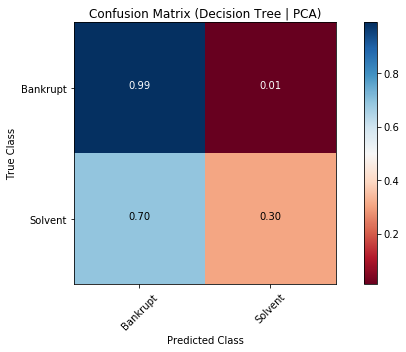

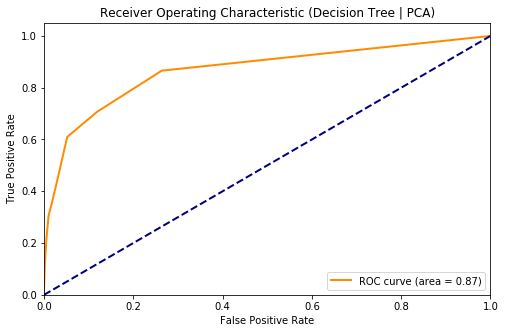

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Decision Tree | PCA)
ACC: 0.9651042266497755
Sensitivity: 0.35167464114832536
Specificity: 0.9961282516636418
F1-Score: 0.49246231155778897
AUC: 0.8745275372890235


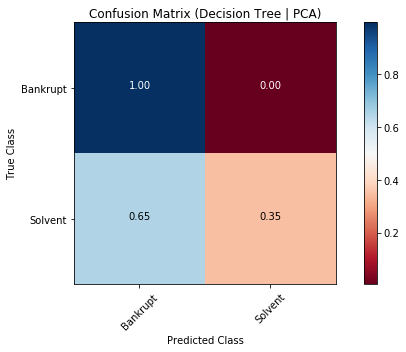

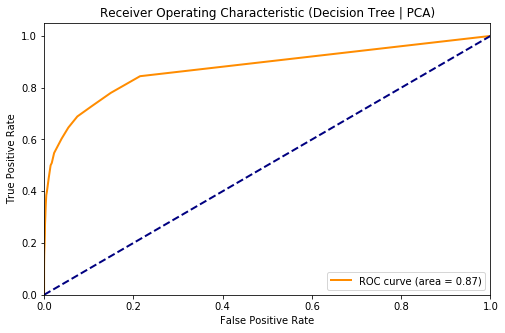

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Decision Tree | kBest Features)
ACC: 0.9943100995732574
Sensitivity: 0.8518518518518519
Specificity: 1.0
F1-Score: 0.92
AUC: 0.9463757396449705


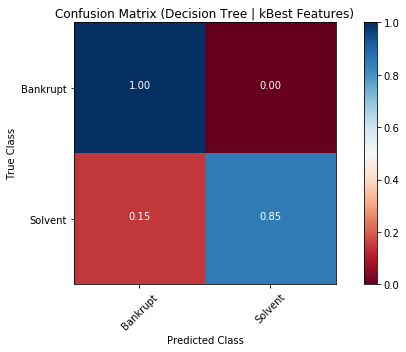

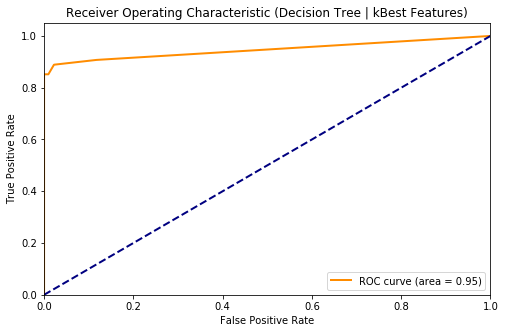

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Decision Tree | kBest Features)
ACC: 0.975921375921376
Sensitivity: 0.4
Specificity: 0.9994884910485934
F1-Score: 0.5663716814159293
AUC: 0.8791400255754475


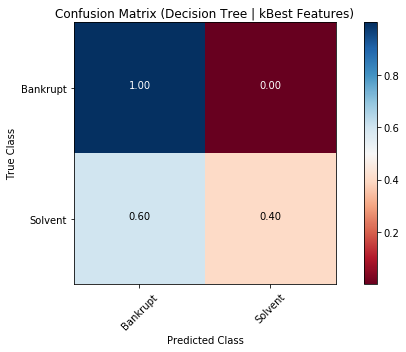

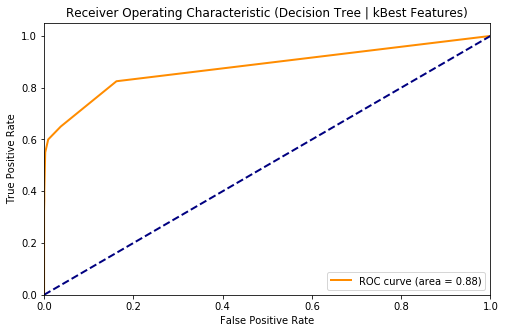

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Decision Tree | kBest Features)
ACC: 0.9738219895287958
Sensitivity: 0.46464646464646464
Specificity: 0.999000999000999
F1-Score: 0.6258503401360545
AUC: 0.8870296370296371


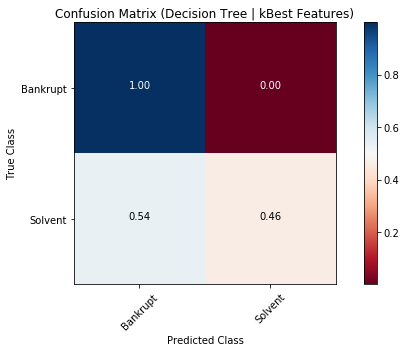

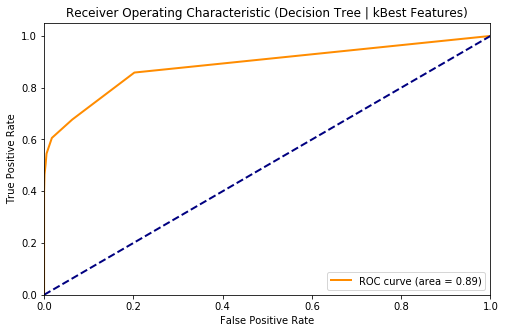

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Decision Tree | kBest Features)
ACC: 0.9770290964777948
Sensitivity: 0.5922330097087378
Specificity: 0.9983836206896551
F1-Score: 0.7305389221556886
AUC: 0.897545614328758


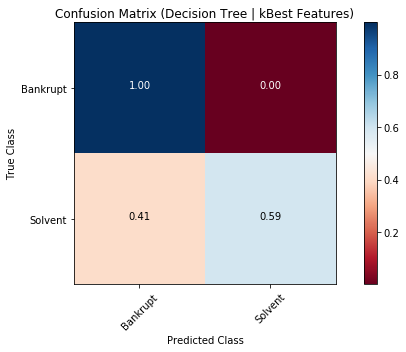

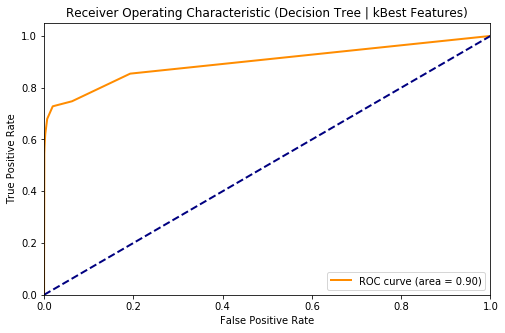

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Decision Tree | kBest Features)
ACC: 0.955160744500846
Sensitivity: 0.5609756097560976
Specificity: 0.9845454545454545
F1-Score: 0.6344827586206897
AUC: 0.9055654101995565


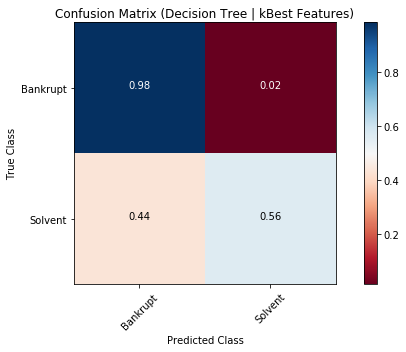

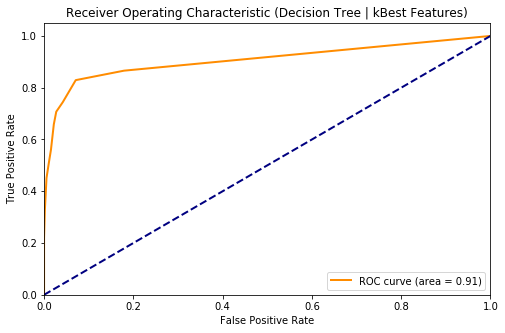

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Decision Tree | kBest Features)
ACC: 0.9758148105493493
Sensitivity: 0.5526315789473685
Specificity: 0.9972171808832426
F1-Score: 0.6875
AUC: 0.9018559846241574


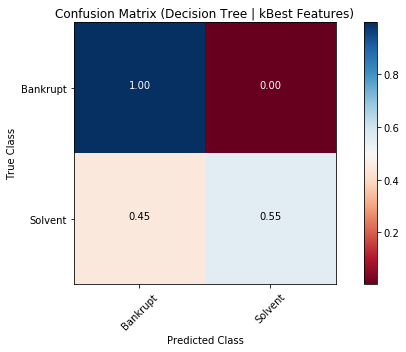

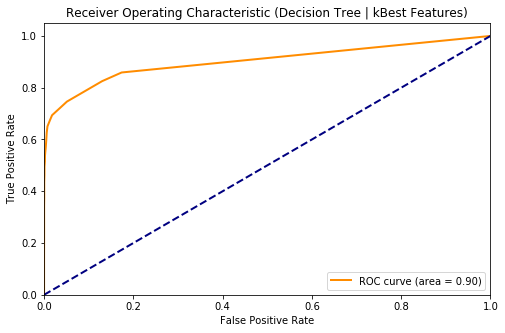

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Decision Tree | Mean Imputation)
ACC: 0.9829302987197724
Sensitivity: 0.6111111111111112
Specificity: 0.9977810650887574
F1-Score: 0.7333333333333334
AUC: 0.8909160639929871


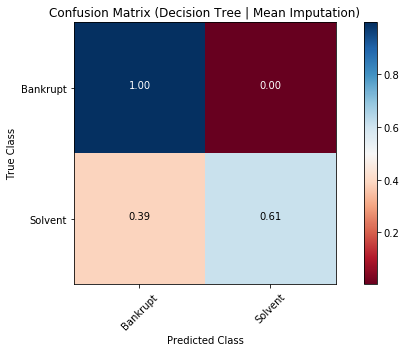

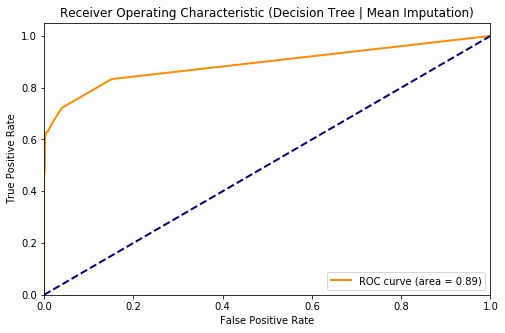

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Decision Tree | Mean Imputation)
ACC: 0.9714987714987715
Sensitivity: 0.325
Specificity: 0.9979539641943734
F1-Score: 0.4727272727272728
AUC: 0.7993414322250639


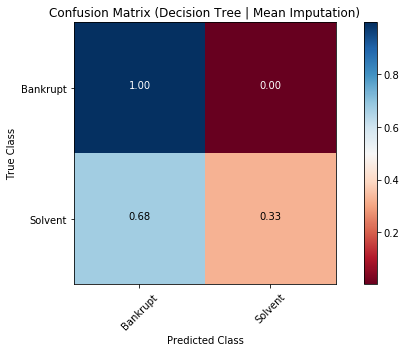

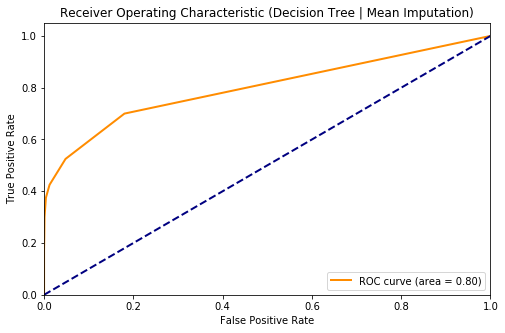

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Decision Tree | Mean Imputation)
ACC: 0.9681104236078059
Sensitivity: 0.36363636363636365
Specificity: 0.998001998001998
F1-Score: 0.5179856115107914
AUC: 0.8617417935599754


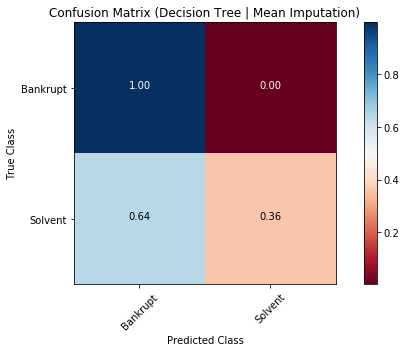

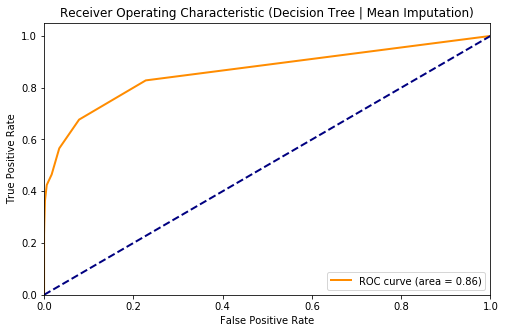

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Decision Tree | Mean Imputation)
ACC: 0.9612046962736089
Sensitivity: 0.3106796116504854
Specificity: 0.9973060344827587
F1-Score: 0.45714285714285713
AUC: 0.8526243932038835


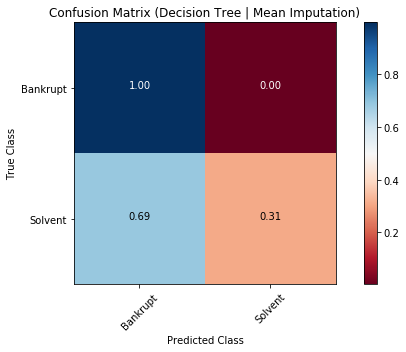

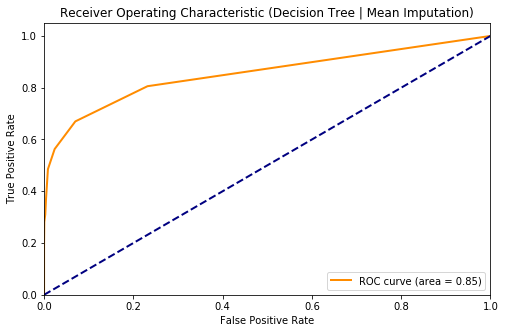

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Decision Tree | Mean Imputation)
ACC: 0.949238578680203
Sensitivity: 0.4146341463414634
Specificity: 0.9890909090909091
F1-Score: 0.53125
AUC: 0.8877217294900221


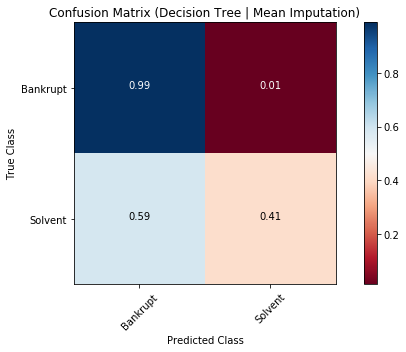

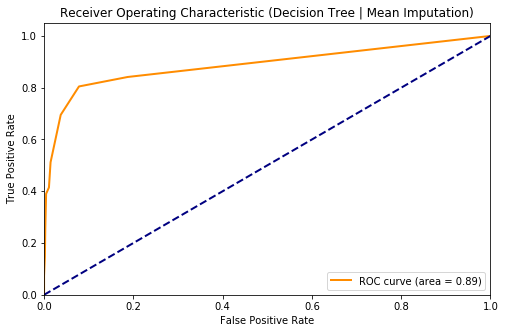

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Decision Tree | Mean Imputation)
ACC: 0.9671772428884027
Sensitivity: 0.38516746411483255
Specificity: 0.9966122202056866
F1-Score: 0.5304777594728171
AUC: 0.8579287477892885


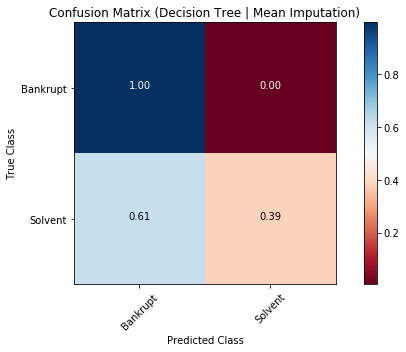

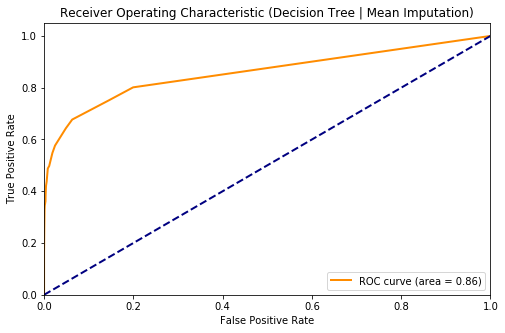

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Decision Tree | Median Imputation)
ACC: 0.9800853485064012
Sensitivity: 0.5
Specificity: 0.9992603550295858
F1-Score: 0.6585365853658536
AUC: 0.8792255643217182


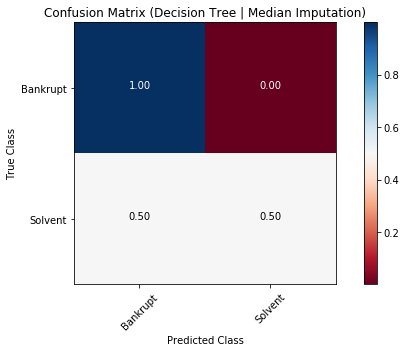

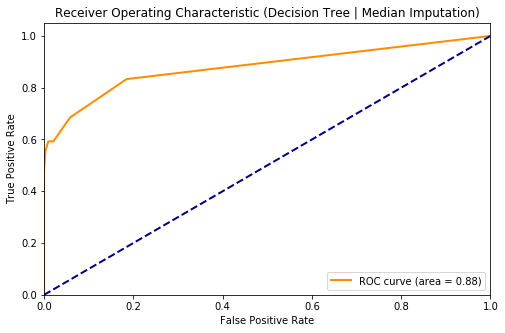

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Decision Tree | Median Imputation)
ACC: 0.9665847665847666
Sensitivity: 0.225
Specificity: 0.9969309462915601
F1-Score: 0.3461538461538462
AUC: 0.7959942455242968


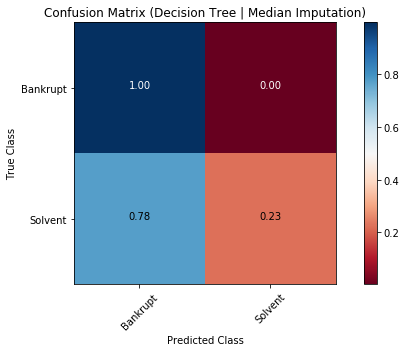

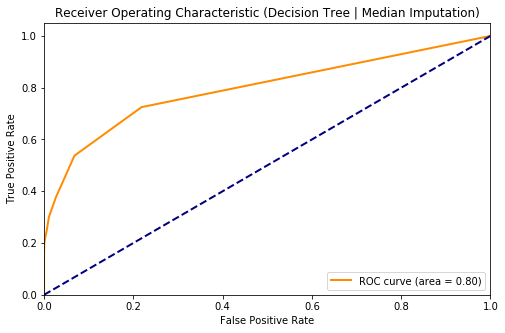

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Decision Tree | Median Imputation)
ACC: 0.9614469300333175
Sensitivity: 0.24242424242424243
Specificity: 0.997002997002997
F1-Score: 0.372093023255814
AUC: 0.8054950100404648


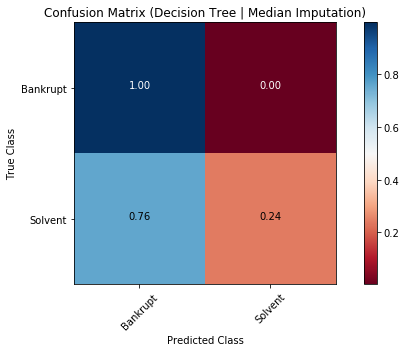

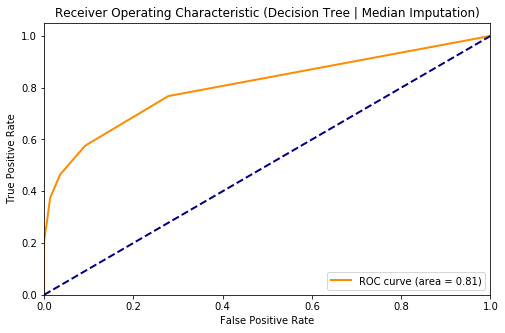

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Decision Tree | Median Imputation)
ACC: 0.9576314446145993
Sensitivity: 0.23300970873786409
Specificity: 0.9978448275862069
F1-Score: 0.366412213740458
AUC: 0.845486692333445


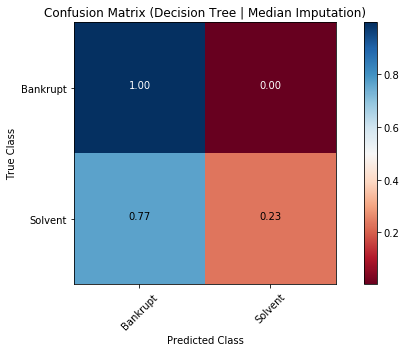

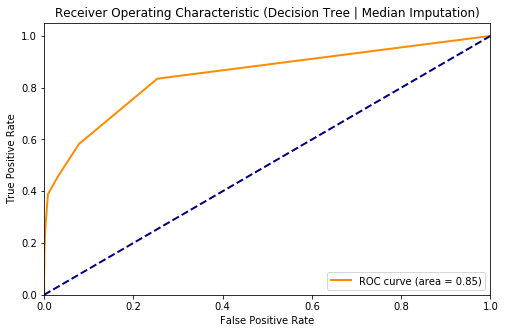

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Decision Tree | Median Imputation)
ACC: 0.949238578680203
Sensitivity: 0.4024390243902439
Specificity: 0.99
F1-Score: 0.523809523809524
AUC: 0.8591241685144124


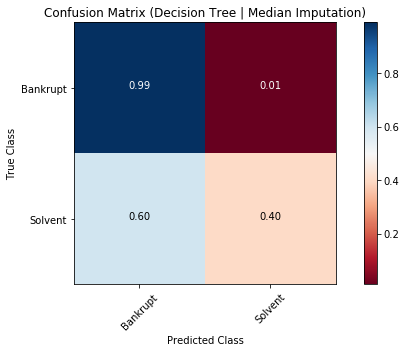

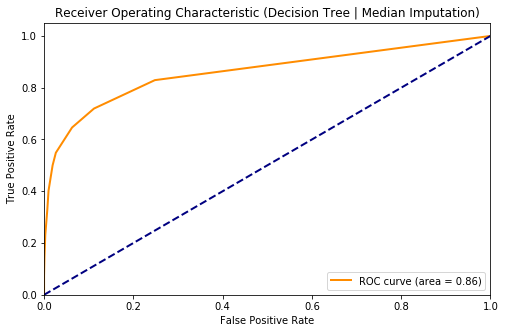

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Decision Tree | Median Imputation)
ACC: 0.9631463779799608
Sensitivity: 0.3014354066985646
Specificity: 0.9966122202056866
F1-Score: 0.44055944055944063
AUC: 0.8366917334583779


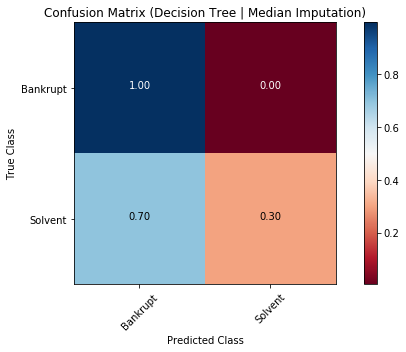

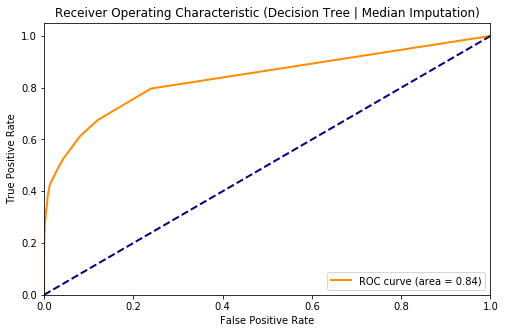

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Decision Tree | Median by Class Imputation)
ACC: 0.9935988620199147
Sensitivity: 0.8518518518518519
Specificity: 0.9992603550295858
F1-Score: 0.9108910891089108
AUC: 0.9722975564321716


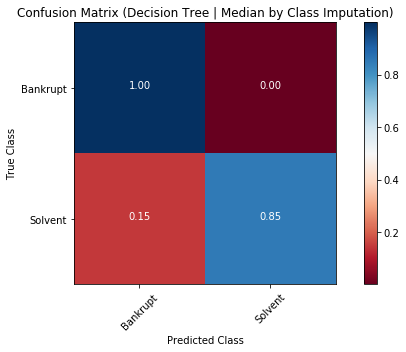

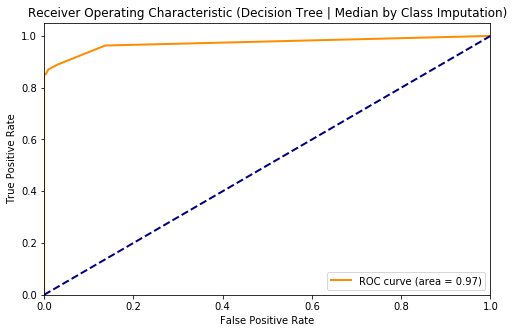

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Decision Tree | Median by Class Imputation)
ACC: 0.9808353808353808
Sensitivity: 0.5625
Specificity: 0.9979539641943734
F1-Score: 0.6976744186046512
AUC: 0.8830722506393862


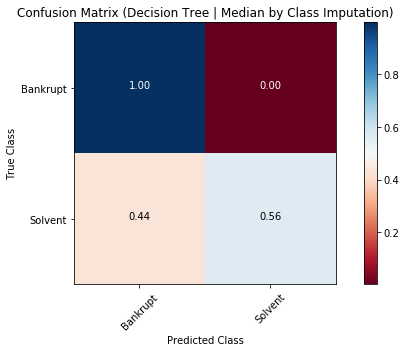

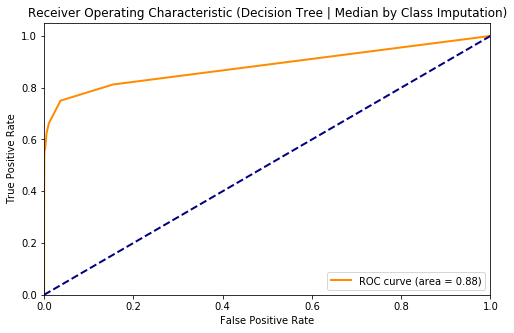

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Decision Tree | Median by Class Imputation)
ACC: 0.97144217039505
Sensitivity: 0.41414141414141414
Specificity: 0.999000999000999
F1-Score: 0.5774647887323944
AUC: 0.8911492547856183


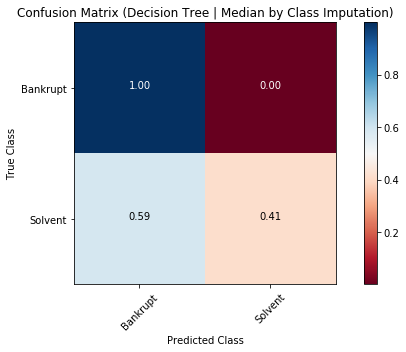

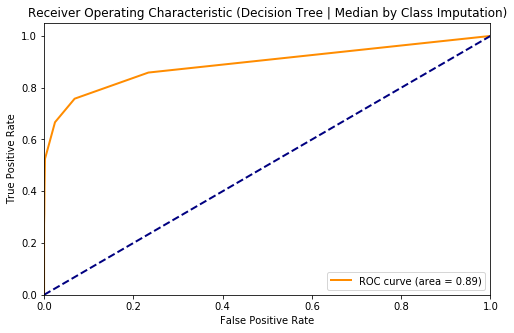

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Decision Tree | Median by Class Imputation)
ACC: 0.9668198060234814
Sensitivity: 0.39805825242718446
Specificity: 0.9983836206896551
F1-Score: 0.5578231292517006
AUC: 0.8879441119852696


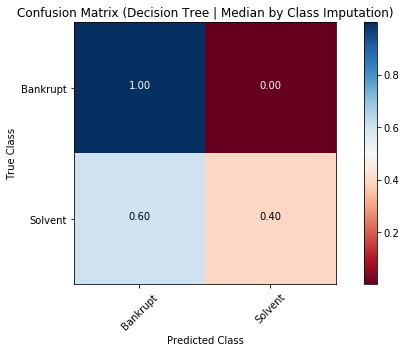

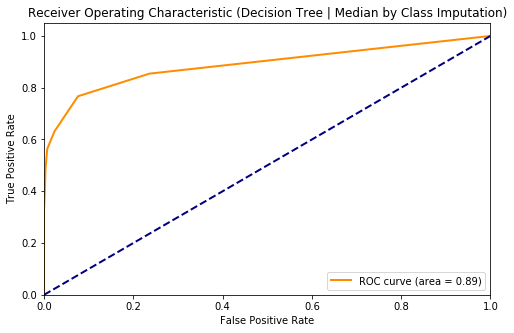

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Decision Tree | Median by Class Imputation)
ACC: 0.9593908629441624
Sensitivity: 0.524390243902439
Specificity: 0.9918181818181818
F1-Score: 0.6417910447761194
AUC: 0.9019844789356983


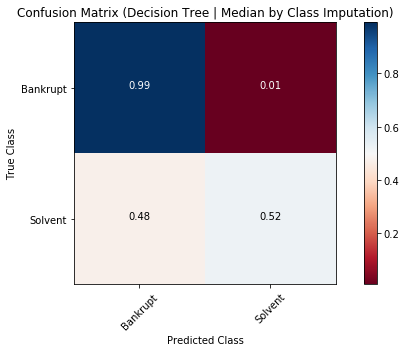

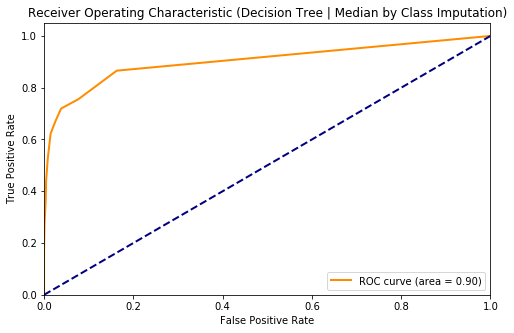

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Decision Tree | Median by Class Imputation)
ACC: 0.9745479672924104
Sensitivity: 0.5167464114832536
Specificity: 0.9977011494252873
F1-Score: 0.66156202143951
AUC: 0.9039326785864183


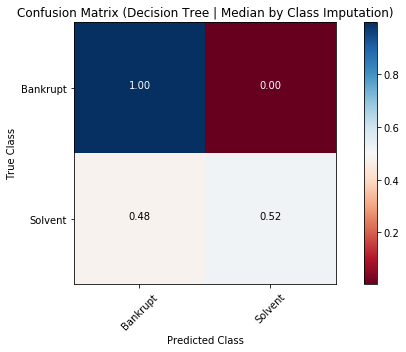

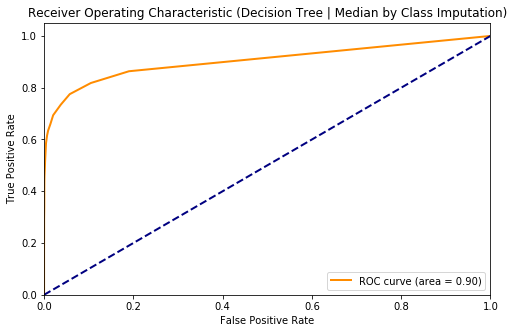

In [20]:
results_experiments_df = print_and_create_results_df(results_experiments)

In [21]:
results_experiments_df.groupby(['model','experiment','year']).mean()

accuracy       auc  \
model               experiment                 year                            
Decision Tree       Baseline                   1          0.992888  0.957881   
                                               2          0.979361  0.882970   
                                               3          0.975726  0.898488   
                                               4          0.975498  0.903525   
                                               5          0.957699  0.908376   
                                               aggregate  0.976851  0.908506   
                    Mean Imputation            1          0.982930  0.890916   
                                               2          0.971499  0.799341   
                                               3          0.968110  0.861742   
                                               4          0.961205  0.852624   
                                               5          0.949239  0.887722   
                                               aggregate  0.967177  0.857929   
                    Median Imputation          1          0.980085  0.879226   
                                               2          0.966585  0.795994   
                                               3          0.961447  0.805495   
                                               4          0.957631  0.845487   
                                               5          0.949239  0.859124   
                                               aggregate  0.963146  0.836692   
                    Median by Class Imputation 1          0.993599  0.972298   
                                               2          0.980835  0.883072   
                                               3          0.971442  0.891149   
                                               4          0.966820  0.887944   
                                               5          0.959391  0.901984   
                                               aggregate  0.974548  0.903933   
                    PCA                        1          0.970839  0.939260   
                                               2          0.971499  0.852513   
                                               3          0.966207  0.850924   
                                               4          0.966820  0.876187   
                                               5          0.942470  0.865915   
                                               aggregate  0.965104  0.874528   
...                                                            ...       ...   
Logistic Regression PCA                        1          0.901849  0.941869   
                                               2          0.811794  0.784904   
                                               3          0.814850  0.872945   
                                               4          0.825421  0.865940   
                                               5          0.851100  0.915244   
                                               aggregate  0.835541  0.876840   
                    SMOTE                      1          0.896159  0.942938   
                                               2          0.862408  0.795205   
                                               3          0.802475  0.890408   
                                               4          0.809086  0.864475   
                                               5          0.867174  0.908348   
                                               aggregate  0.841990  0.878718   
                    Standard Scaler            1          0.745377  0.812582   
                                               2          0.709091  0.678641   
                                               3          0.768682  0.757773   
                                               4          0.718734  0.755236   
                                               5          0.815567  0.806729   
                                               aggregate  

In [22]:
results_experiments_df.to_csv('results_experiments.csv')

### Custom vs sklearn Models

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Logistic Regression | sklearn)
ACC: 0.9075391180654339
Sensitivity: 0.8518518518518519
Specificity: 0.9097633136094675
F1-Score: 0.4144144144144144
AUC: 0.9424172693403463


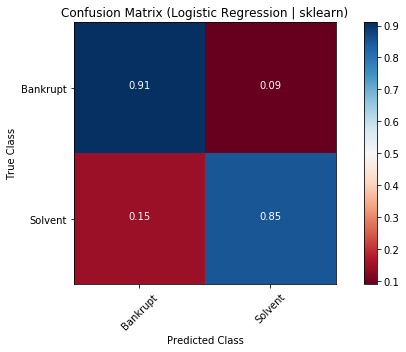

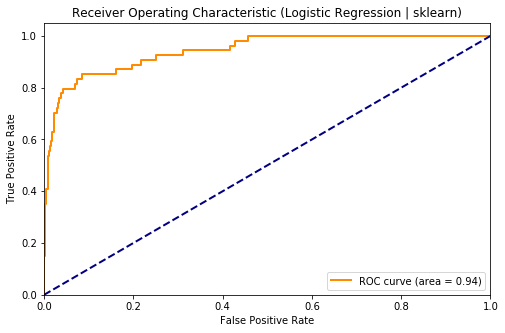

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Logistic Regression | sklearn)
ACC: 0.830958230958231
Sensitivity: 0.5875
Specificity: 0.8409207161125319
F1-Score: 0.2146118721461187
AUC: 0.7863299232736574


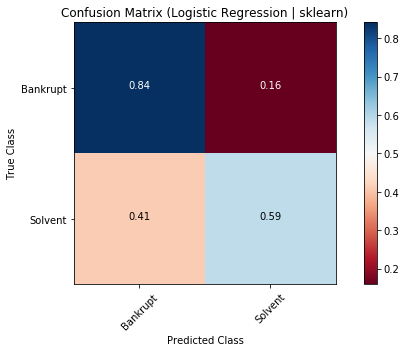

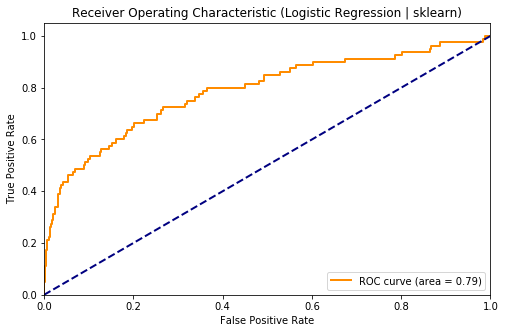

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Logistic Regression | sklearn)
ACC: 0.8648262732032366
Sensitivity: 0.6868686868686869
Specificity: 0.8736263736263736
F1-Score: 0.32380952380952377
AUC: 0.8780815144451508


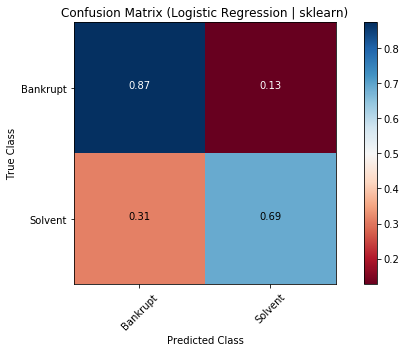

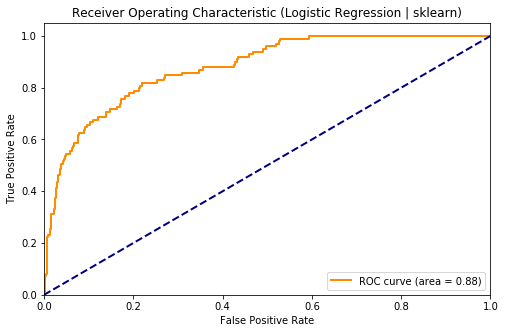

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Logistic Regression | sklearn)
ACC: 0.8683001531393568
Sensitivity: 0.6796116504854369
Specificity: 0.8787715517241379
F1-Score: 0.35175879396984927
AUC: 0.8622782055574154


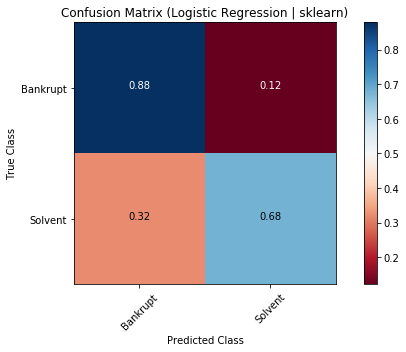

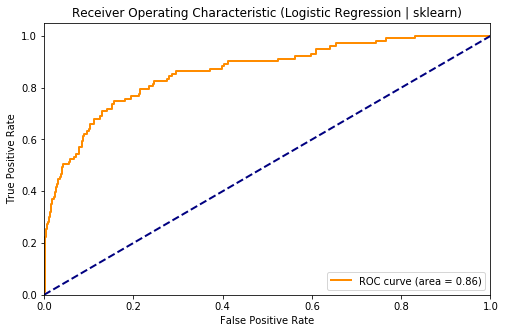

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Logistic Regression | sklearn)
ACC: 0.8485617597292724
Sensitivity: 0.8780487804878049
Specificity: 0.8463636363636363
F1-Score: 0.4458204334365325
AUC: 0.9168736141906872


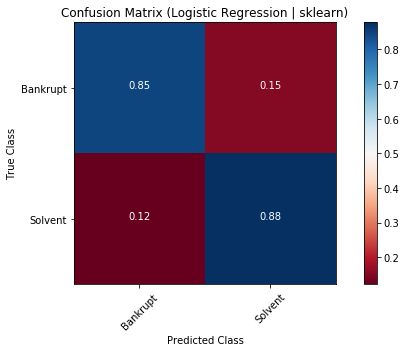

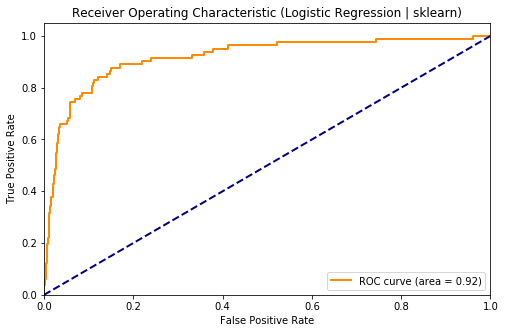

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Logistic Regression | sklearn)
ACC: 0.8623747552689163
Sensitivity: 0.7248803827751196
Specificity: 0.8693284936479129
F1-Score: 0.3364797334813992
AUC: 0.8749201828196957


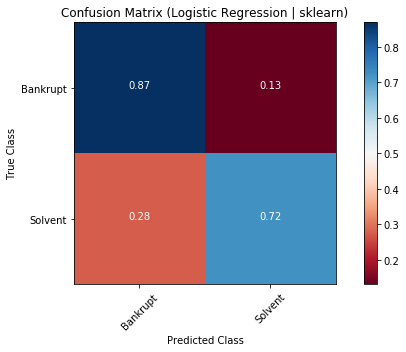

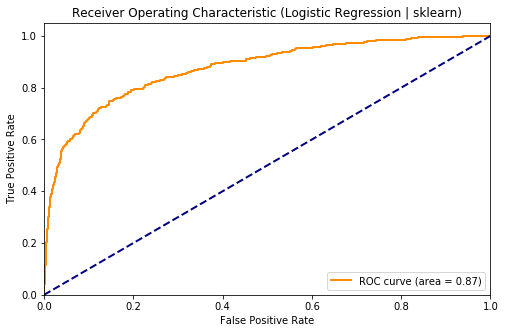

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Logistic Regression | custom)
ACC: 0.8492176386913229
Sensitivity: 0.8703703703703703
Specificity: 0.8483727810650887
F1-Score: 0.3071895424836601
AUC: 0.938034188034188


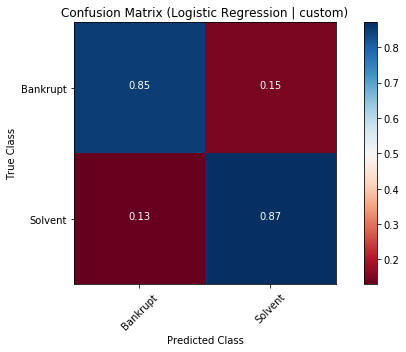

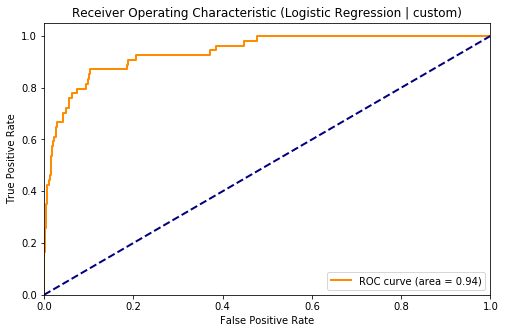

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Logistic Regression | custom)
ACC: 0.6815724815724816
Sensitivity: 0.5375
Specificity: 0.6874680306905371
F1-Score: 0.11716621253405995
AUC: 0.6902173913043478


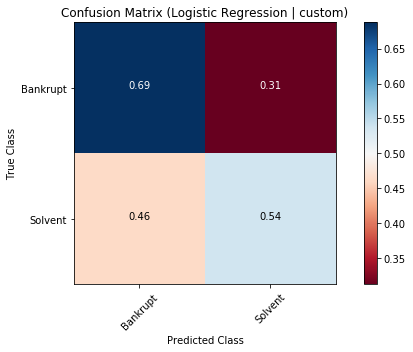

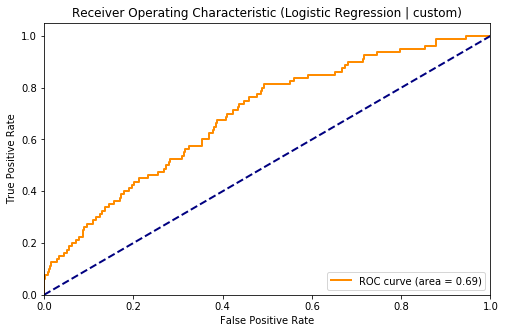

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Logistic Regression | custom)
ACC: 0.7762970014278915
Sensitivity: 0.7777777777777778
Specificity: 0.7762237762237763
F1-Score: 0.2467948717948718
AUC: 0.8705587341950979


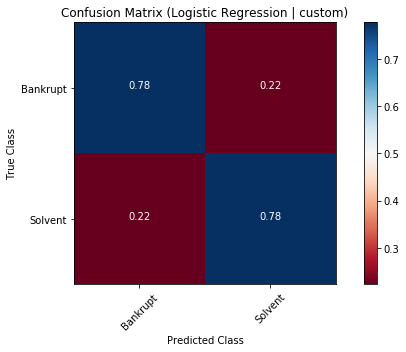

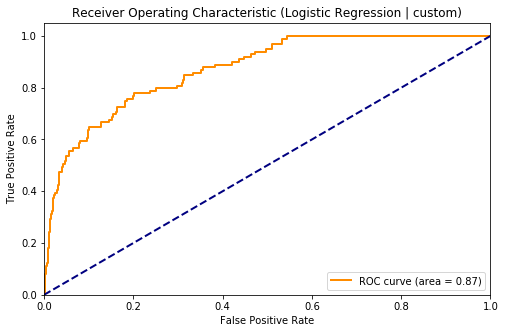

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Logistic Regression | custom)
ACC: 0.7835630423685553
Sensitivity: 0.7766990291262136
Specificity: 0.7839439655172413
F1-Score: 0.273972602739726
AUC: 0.8549548041513223


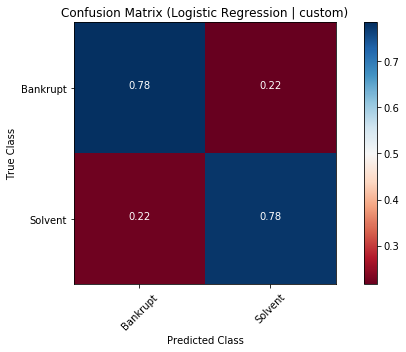

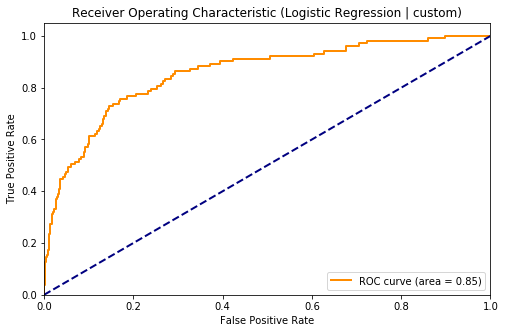

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Logistic Regression | custom)
ACC: 0.8426395939086294
Sensitivity: 0.8048780487804879
Specificity: 0.8454545454545455
F1-Score: 0.41509433962264153
AUC: 0.8986917960088692


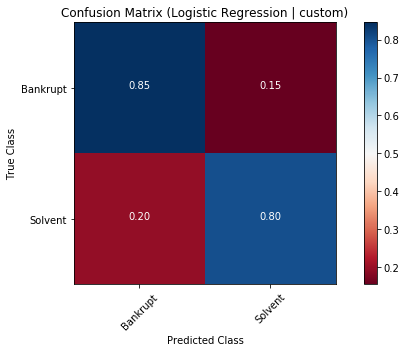

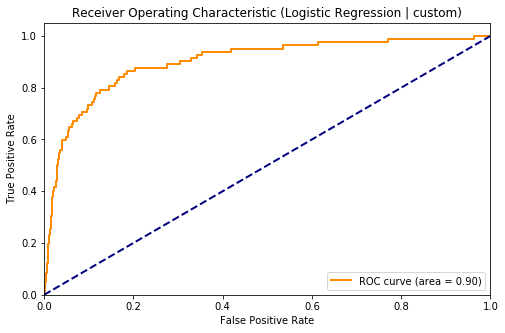

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Logistic Regression | custom)
ACC: 0.7765749165035126
Sensitivity: 0.7488038277511961
Specificity: 0.7779794313369631
F1-Score: 0.24395946999220575
AUC: 0.8560705922536088


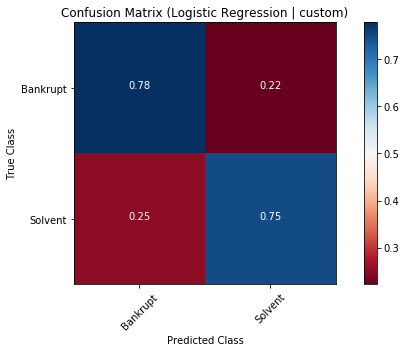

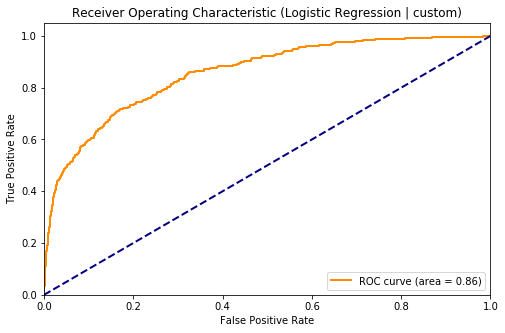

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Decision Tree | sklearn)
ACC: 0.9928876244665719
Sensitivity: 0.8518518518518519
Specificity: 0.9985207100591716
F1-Score: 0.9019607843137256
AUC: 0.9578813280736358


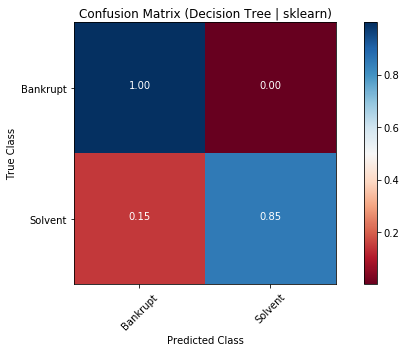

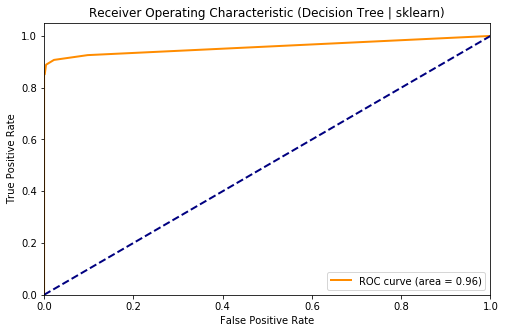

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Decision Tree | sklearn)
ACC: 0.9793611793611794
Sensitivity: 0.4875
Specificity: 0.9994884910485934
F1-Score: 0.65
AUC: 0.882969948849105


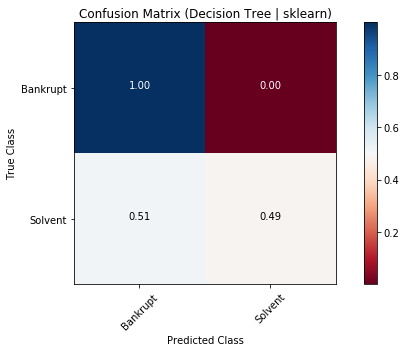

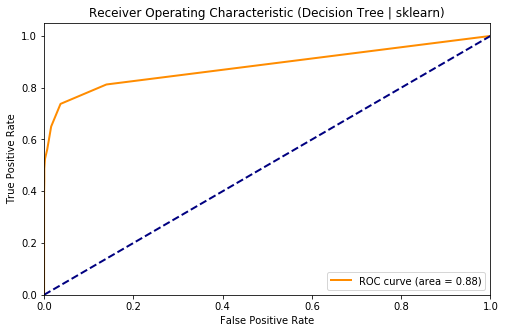

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Decision Tree | sklearn)
ACC: 0.9757258448357925
Sensitivity: 0.5050505050505051
Specificity: 0.999000999000999
F1-Score: 0.6622516556291391
AUC: 0.898487875760603


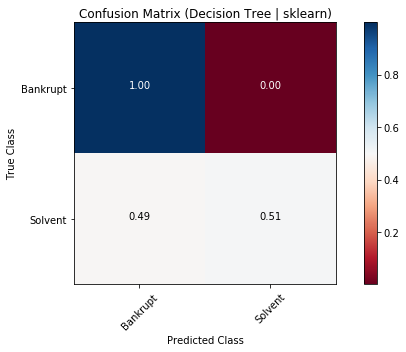

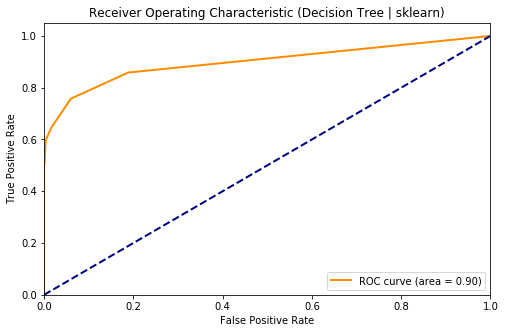

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Decision Tree | sklearn)
ACC: 0.9754977029096478
Sensitivity: 0.5922330097087378
Specificity: 0.9967672413793104
F1-Score: 0.7176470588235293
AUC: 0.9035246484767325


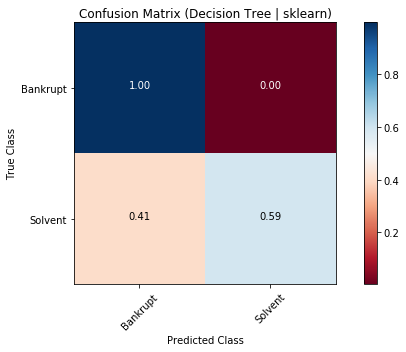

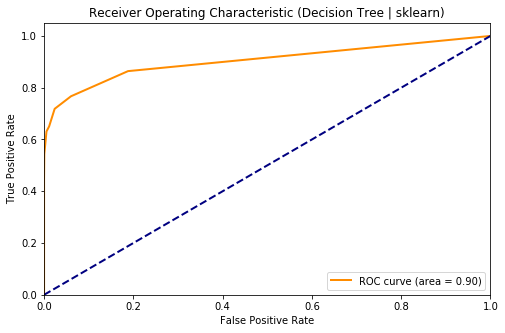

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Decision Tree | sklearn)
ACC: 0.9576988155668359
Sensitivity: 0.573170731707317
Specificity: 0.9863636363636363
F1-Score: 0.6527777777777778
AUC: 0.9083758314855874


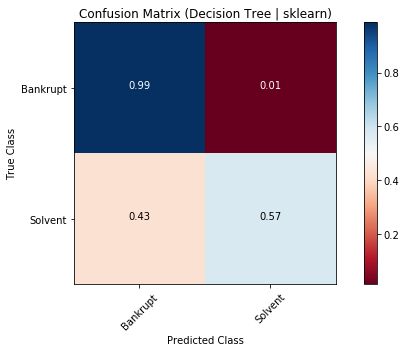

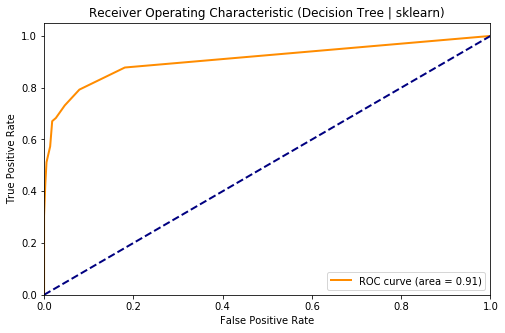

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Decision Tree | sklearn)
ACC: 0.9768513186686629
Sensitivity: 0.5813397129186603
Specificity: 0.996854204476709
F1-Score: 0.7074235807860262
AUC: 0.9085057760719237


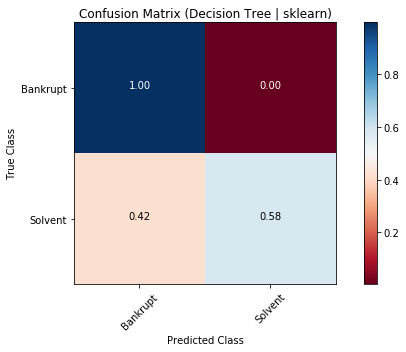

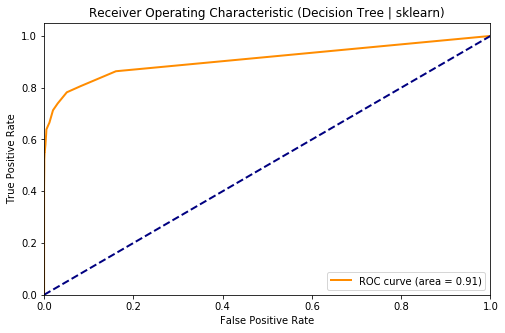

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 0 (Decision Tree | custom)
ACC: 0.9914651493598862
Sensitivity: 0.8888888888888888
Specificity: 0.9955621301775148
F1-Score: 0.8888888888888888
AUC: 0.9768860946745561


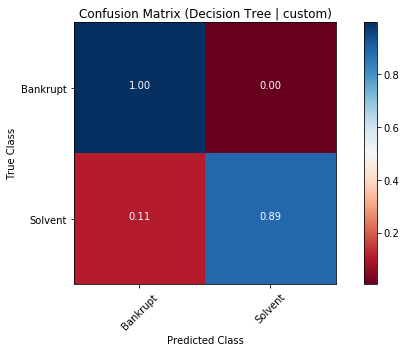

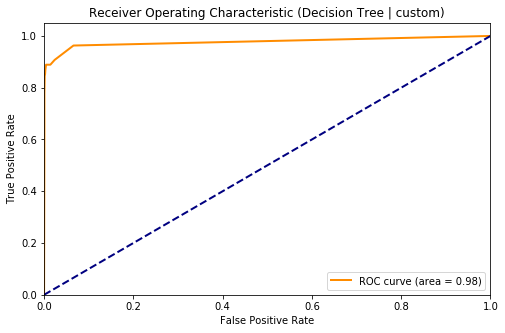

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 1 (Decision Tree | custom)
ACC: 0.9778869778869779
Sensitivity: 0.55
Specificity: 0.9953964194373401
F1-Score: 0.6616541353383459
AUC: 0.8994597186700768


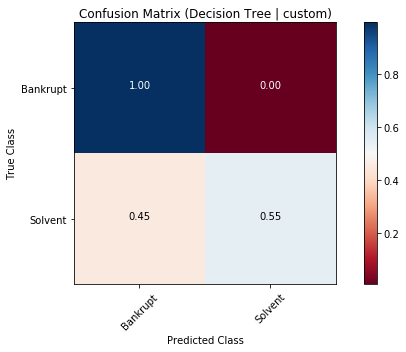

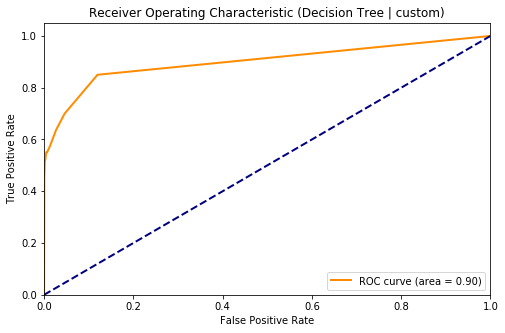

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 2 (Decision Tree | custom)
ACC: 0.9747739171822941
Sensitivity: 0.5858585858585859
Specificity: 0.994005994005994
F1-Score: 0.6863905325443788
AUC: 0.8687297550933915


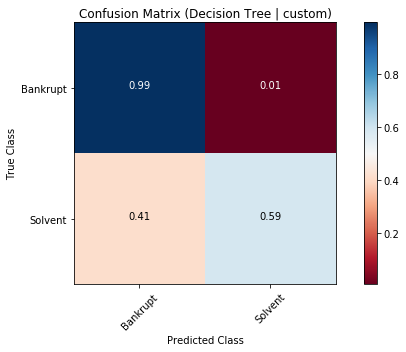

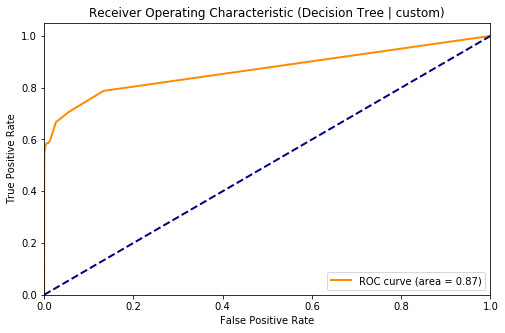

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 3 (Decision Tree | custom)
ACC: 0.9729453802960695
Sensitivity: 0.6310679611650486
Specificity: 0.9919181034482759
F1-Score: 0.7103825136612022
AUC: 0.8951707398727821


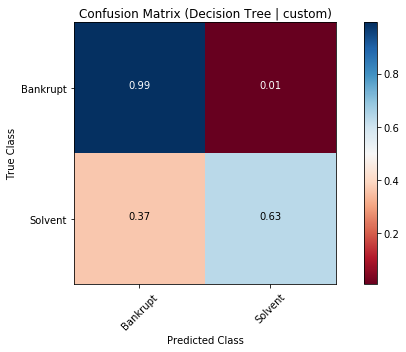

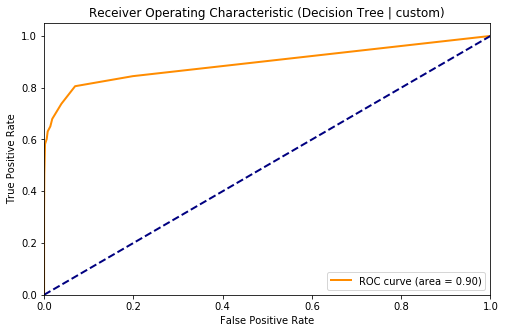

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Year 4 (Decision Tree | custom)
ACC: 0.9593908629441624
Sensitivity: 0.6219512195121951
Specificity: 0.9845454545454545
F1-Score: 0.6799999999999999
AUC: 0.8984922394678492


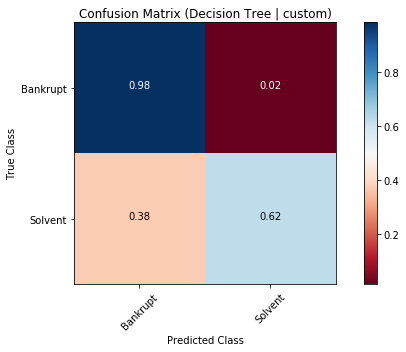

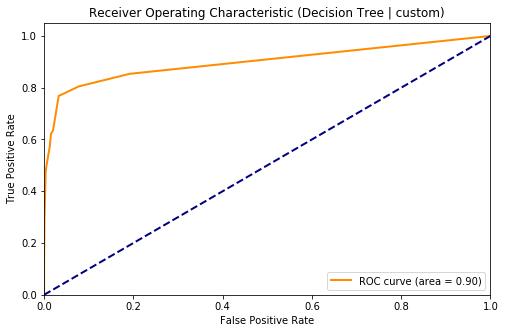

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Aggregate Metrics (Decision Tree | custom)
ACC: 0.9756996429805367
Sensitivity: 0.6363636363636364
Specificity: 0.9928614640048397
F1-Score: 0.7160161507402423
AUC: 0.9026846939159482


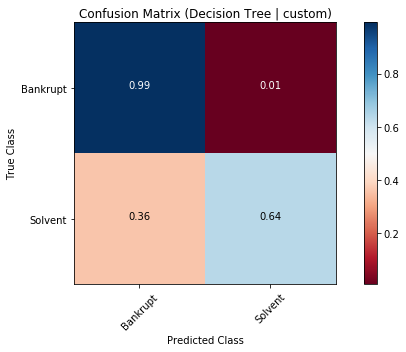

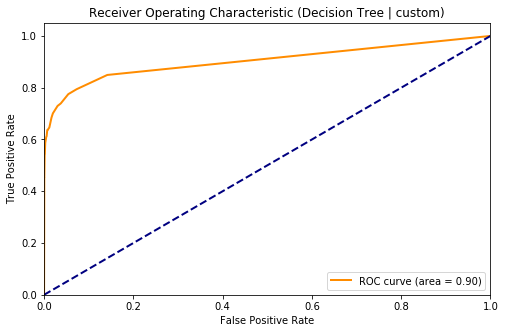

In [23]:
results_custom_vs_sklearn_df = print_and_create_results_df(results_custom_vs_sklearn)

In [24]:
results_custom_vs_sklearn_df.groupby(['model','experiment','year']).mean()

accuracy       auc  f1-score  \
model               experiment year                                      
Decision Tree       custom     1          0.991465  0.976886  0.888889   
                               2          0.977887  0.899460  0.661654   
                               3          0.974774  0.868730  0.686391   
                               4          0.972945  0.895171  0.710383   
                               5          0.959391  0.898492  0.680000   
                               aggregate  0.975700  0.902685  0.716016   
                    sklearn    1          0.992888  0.957881  0.901961   
                               2          0.979361  0.882970  0.650000   
                               3          0.975726  0.898488  0.662252   
                               4          0.975498  0.903525  0.717647   
                               5          0.957699  0.908376  0.652778   
                               aggregate  0.976851  0.908506  0.707424   
Logistic Regression custom     1          0.849218  0.938034  0.307190   
                               2          0.681572  0.690217  0.117166   
                               3          0.776297  0.870559  0.246795   
                               4          0.783563  0.854955  0.273973   
                               5          0.842640  0.898692  0.415094   
                               aggregate  0.776575  0.856071  0.243959   
                    sklearn    1          0.907539  0.942417  0.414414   
                               2          0.830958  0.786330  0.214612   
                               3          0.864826  0.878082  0.323810   
                               4          0.868300  0.862278  0.351759   
                               5          0.848562  0.916874  0.445820   
                               aggregate  0.862375  0.874920  0.336480   

                                          sensitivity  specificity  
model               experiment year                                 
Decision Tree       custom     1             0.888889     0.995562  
                               2             0.550000     0.995396  
                               3             0.585859     0.994006  
                               4             0.631068     0.991918  
                               5             0.621951     0.984545  
                               aggregate     0.636364     0.992861  
                    sklearn    1             0.851852     0.998521  
                               2             0.487500     0.999488  
                               3             0.505051     0.999001  
                               4             0.592233     0.996767  
                               5             0.573171     0.986364  
                               aggregate     0.581340     0.996854  
Logistic Regression custom     1             0.870370     0.848373  
                               2             0.537500     0.687468  
                               3             0.777778     0.776224  
                               4             0.776699     0.783944  
                               5             0.804878     0.845455  
                               aggregate     0.748804     0.777979  
                    sklearn    1             0.851852     0.909763  
                               2             0.587500     0.840921  
                               3             0.686869     0.873626  
                               4             0.679612     0.878772  
                               5             0.878049     0.846364  
                               aggregate     0.724880     0.869328

In [25]:
results_custom_vs_sklearn_df.to_csv('results_custom_vs_sklearn.csv')